# Underwater analysis of SGBM disparity parameters

Some methods needed for analysis:

In [117]:
import numpy as np
import statistics

def read_disparity_results(paths):
    all_hole_counts = []
    all_invalid_percentage = []
    all_speckle_percentage = []
    all_incompletes = []
    all_times = []

    for i in range(len(paths)):
        with open(paths[i],mode = 'r') as file:
            csvFile = csv.reader(file)
            line_number = 0
            last_setting = "-10"
            current_holes = []
            current_invalid_percentage = []
            current_speckle_percentage = []
            current_incompletes = []
            current_times = []
            append_index = 0

            for lines in csvFile:
                if line_number != 0:
                    # get setting value
                    setting = str(lines[7])

                    if(setting != last_setting and last_setting != "-10" and i == 0):
                        all_hole_counts.append(current_holes)
                        all_invalid_percentage.append(current_invalid_percentage)
                        all_speckle_percentage.append(current_speckle_percentage)
                        all_incompletes.append(current_incompletes)
                        all_times.append(current_times)
                        current_holes = []
                        current_invalid_percentage = []
                        current_speckle_percentage = []
                        current_incompletes = []
                        current_times = []
                        
                        current_holes.append(float(lines[2]))
                        current_invalid_percentage.append(float(lines[3]))
                        current_speckle_percentage.append(float(lines[4]))
                        current_incompletes.append(float(lines[5]))
                        current_times.append(float(lines[6]))
                        
                    elif(setting != last_setting and last_setting != "-10"):
                        append_index = append_index+1
                        all_hole_counts[append_index].append(float(lines[2]))
                        all_invalid_percentage[append_index].append(float(lines[3]))
                        all_speckle_percentage[append_index].append(float(lines[4]))
                        all_incompletes[append_index].append(float(lines[5]))
                        all_times[append_index].append(float(lines[6]))
                        
                    elif(i == 0):
                        current_holes.append(float(lines[2]))
                        current_invalid_percentage.append(float(lines[3]))
                        current_speckle_percentage.append(float(lines[4]))
                        current_incompletes.append(float(lines[5]))
                        current_times.append(float(lines[6]))
                    else:
                        all_hole_counts[append_index].append(float(lines[2]))
                        all_invalid_percentage[append_index].append(float(lines[3]))
                        all_speckle_percentage[append_index].append(float(lines[4]))
                        all_incompletes[append_index].append(float(lines[5]))
                        all_times[append_index].append(float(lines[6]))
                    last_setting = setting
                line_number = line_number+1
            if(i == 0):
                all_hole_counts.append(current_holes)
                all_invalid_percentage.append(current_invalid_percentage)
                all_speckle_percentage.append(current_speckle_percentage)
                all_incompletes.append(current_incompletes)
                all_times.append(current_times)
    return all_hole_counts, all_invalid_percentage, all_speckle_percentage,all_incompletes,all_times

def line_graph_median_and_quantiles(x_values,medians,percentiles_25,percentiles_75,labels, use_log, x_label, y_label, title, save, colors,save_title=""):

    plt.rcParams.update({'font.size': 28})
    plt.rcParams["figure.figsize"] = (13,10)
    lw = 3
    if(use_log == True):
        plt.xscale("log")

    for i in range(len(medians)):
        plt.plot(x_values,medians[i],marker='.', markersize=20,color=colors[i],label=labels[i],linewidth=lw)
        plt.fill_between(x_values, percentiles_25[i],percentiles_75[i], alpha=0.2)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if(len(medians) > 1):
        plt.legend()
    if(save == True):
        plt.savefig(save_title)#,bbox_inches='tight')
    plt.show()

def find_median_and_quartiles(environment_data, start = 0):
    medians = []
    percentiles_25 = []
    percentiles_75 = []
    
    for i in range(len(environment_data)):
        temp_medians = []
        temp_percentiles_25 = []
        temp_percentiles_75 = []

        for j in range(start,len(environment_data[0])):
            if(len(environment_data[i][j]) == 0):
                temp_medians.append(0)
                temp_percentiles_25.append(0)
                temp_percentiles_75.append(0)
            else:    
                temp_medians.append(statistics.median(environment_data[i][j]))
                temp_percentiles_25.append(np.percentile(environment_data[i][j], 25))
                temp_percentiles_75.append(np.percentile(environment_data[i][j], 75))
        medians.append(temp_medians)
        percentiles_25.append(temp_percentiles_25)
        percentiles_75.append(temp_percentiles_75)
        
    return medians, percentiles_25, percentiles_75

def show_double_grouped_boxplots(upper_group,settings, input_data, colors, setting_name, y_label,title,save = False,save_title=""):
    groups = []
    plt.rcParams.update({'font.size': 25})
    plt.rcParams["figure.figsize"] = (16,10)
    lw = 3
    for i in range(len(upper_group)):
        dictionary = {}
        for j in range(len(settings)):
            print(settings[j])
            #print("Median: " statistics.median(input_data[i][j]))
            print("Quantiles: ")
            print(np.quantile(input_data[i][j],[0.25,0.5,0.75]))
            
            dictionary.update({settings[j]:input_data[i][j]})
        temp_dataframe = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in dictionary.items() ]))
        groups.append(temp_dataframe)

    x_range = 0
    x_position = 0
    if(len(groups) > 1):
        x_range = np.arange(len(groups)) / (len(groups)-1)
        x_position = (x_range*0.5)+0.75

    plt.grid(zorder=0)
    for i,data in enumerate(groups):
        temp_data = np.array(data)
        temp_data = [np.nan_to_num(group,nan=np.nanmean(group)) for group in temp_data]
        if(len(groups) > 1):
            current_plot = plt.boxplot(np.array(temp_data),sym='',whis=[0,100],widths=0.6/len(groups),tick_labels=list(groups[0]),vert=False,zorder=3,patch_artist=True,positions=[x_position[i]+j*1 for j in range(len(data.T))])
        else:
            current_plot = plt.boxplot(np.array(temp_data),sym='',whis=[0,100],widths=0.6/len(groups),tick_labels=list(groups[0]),vert=False,zorder=3,patch_artist=True)
            
        k = i % len(colors)
        for box in current_plot['boxes']:
            box.set(facecolor=colors[k])
        for element in ['fliers','means','medians']:
            plt.setp(current_plot[element],color='black')
        for element in ['whiskers','caps']:
            plt.setp(current_plot[element],color = 'black')
            plt.setp(current_plot[element],color = 'black')

    
    legend_titles = []
    for i in range(len(groups)):
        j = i % len(upper_group)
        k = i % len(colors)
        legend_titles.append(Patch(facecolor=colors[k], label=upper_group[j]))
    if(len(groups) > 1):
        plt.legend(handles=legend_titles, fontsize=8)
    plt.xlabel(y_label) #plt.xlabel(setting_name)
    #plt.xticks(np.arange(len(list(groups[0])))+1,rotation=30)
    plt.ylabel(setting_name)
    plt.title(title)
    #plt.xlim([0.5, len(list(groups[0])) + 0.5])
    #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    #plt.subplots_adjust(left=0.2, right=0.9)
    if(save == True):
        plt.savefig(save_title,bbox_inches='tight')
    plt.show()

## Speckle range (Done)

In [63]:
import csv

# Paths
path = ["../Data/Disparity_settings/speckleRange.csv"]

# Other variables
settings = [0,1,2,3,4,5,6,7,8,9,10]

# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

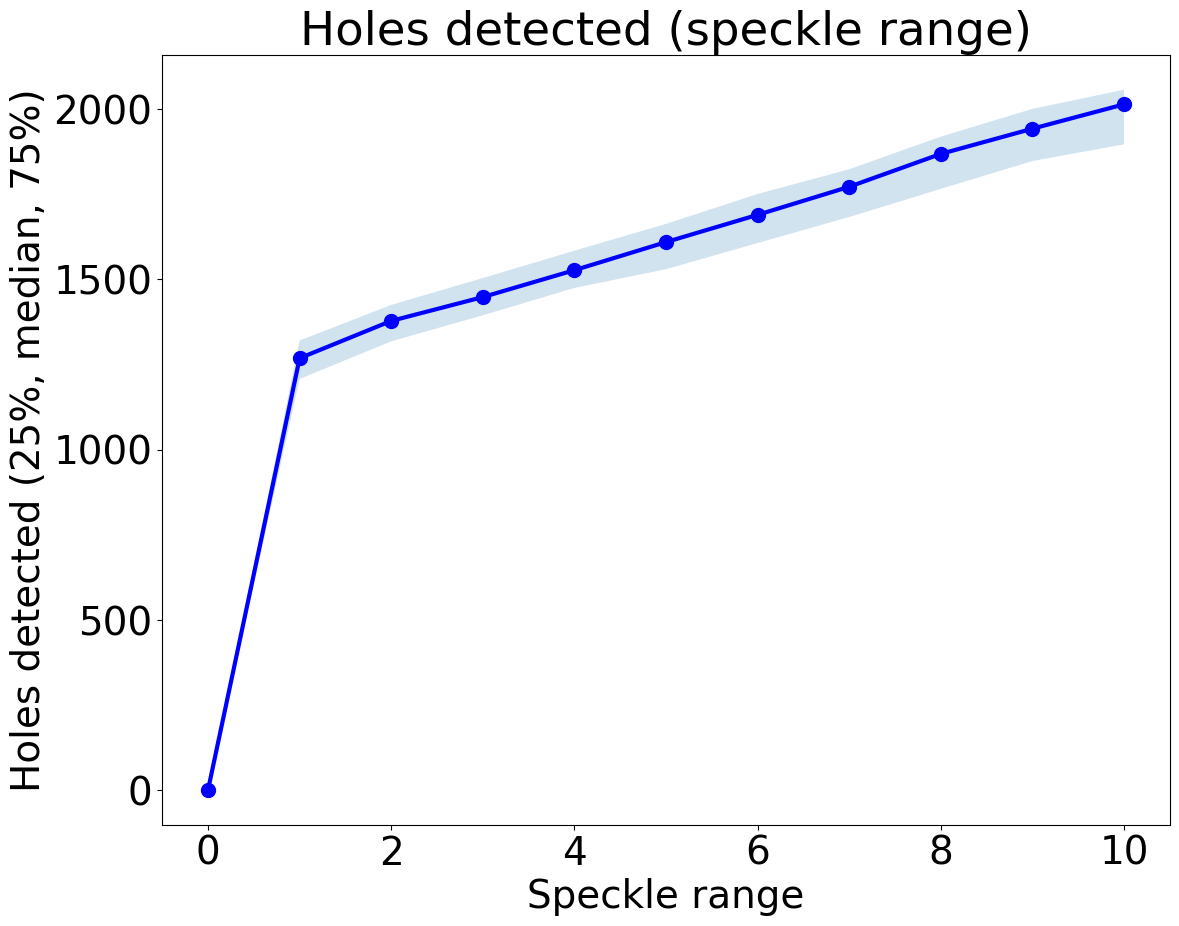

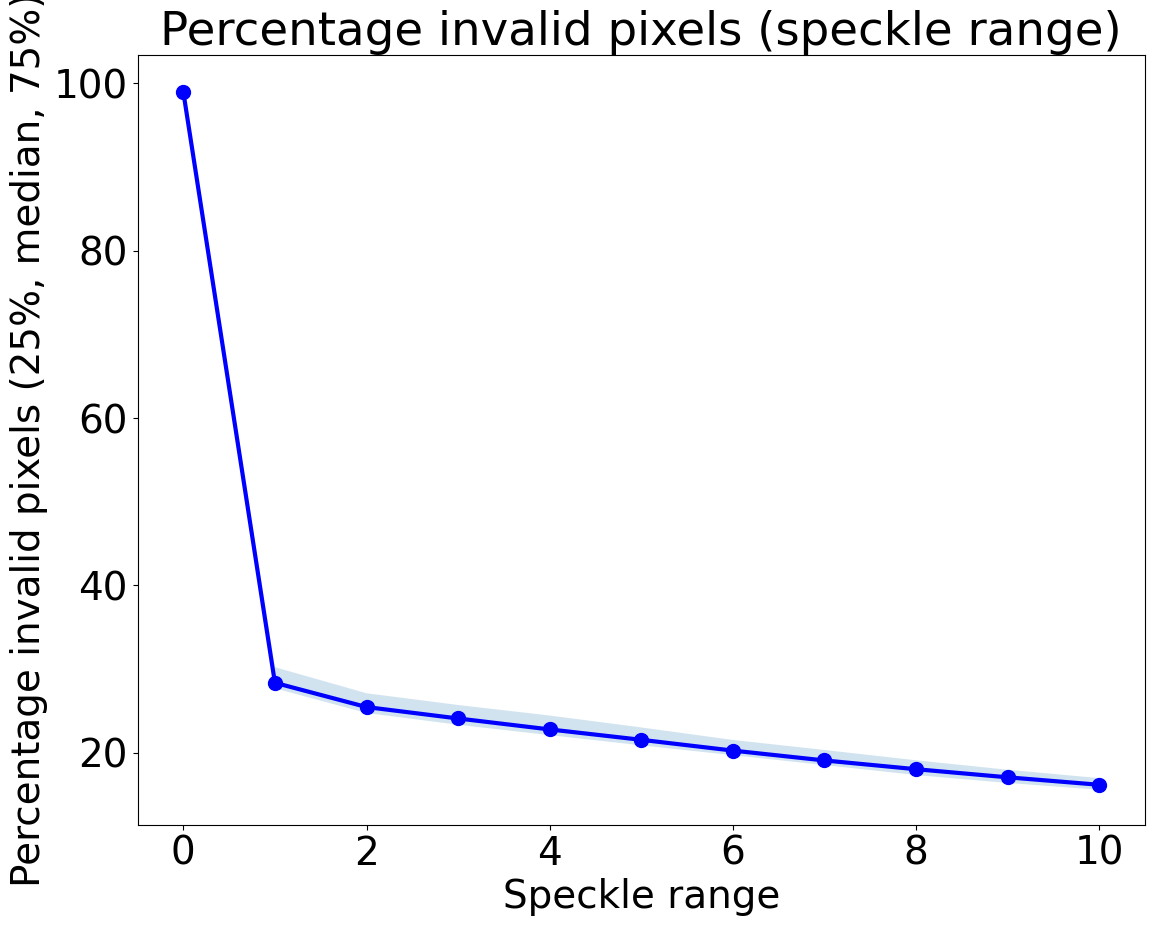

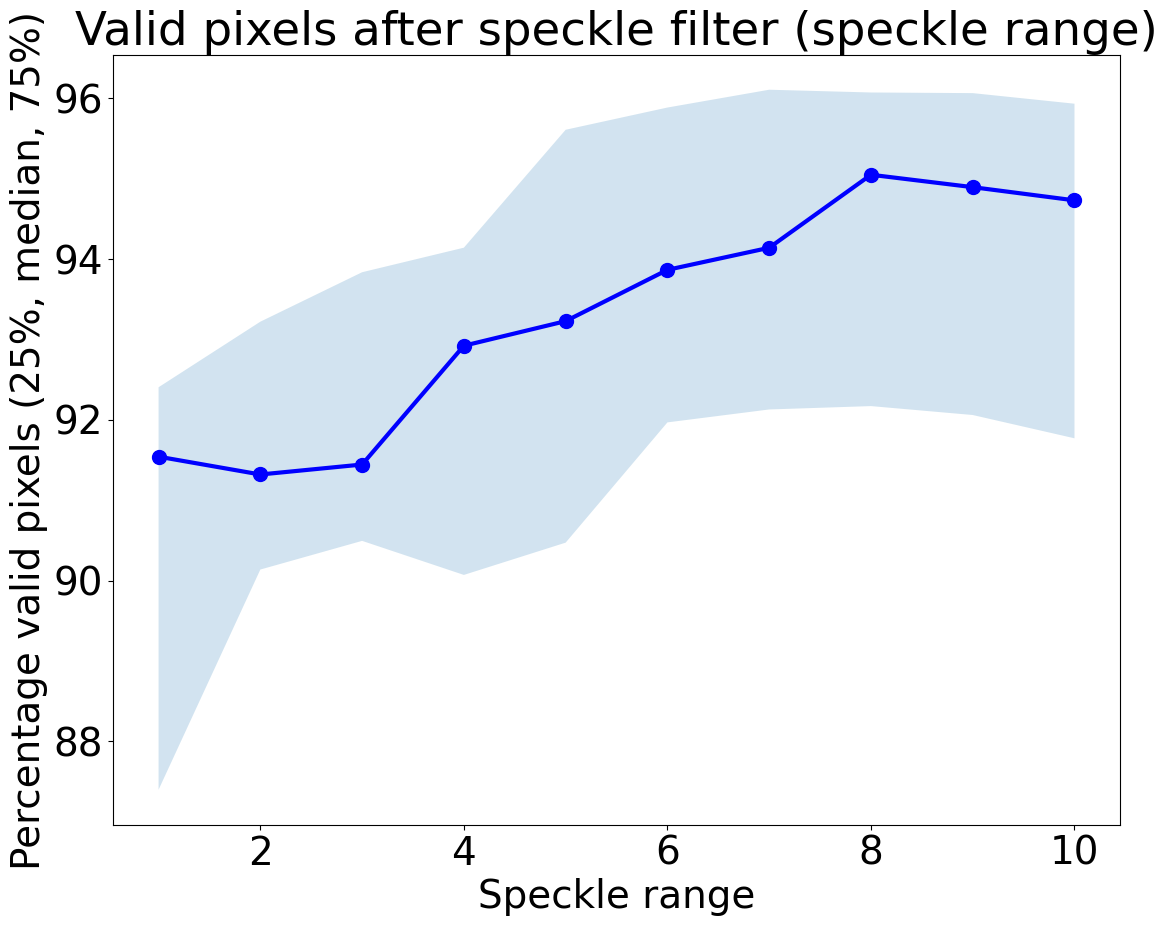

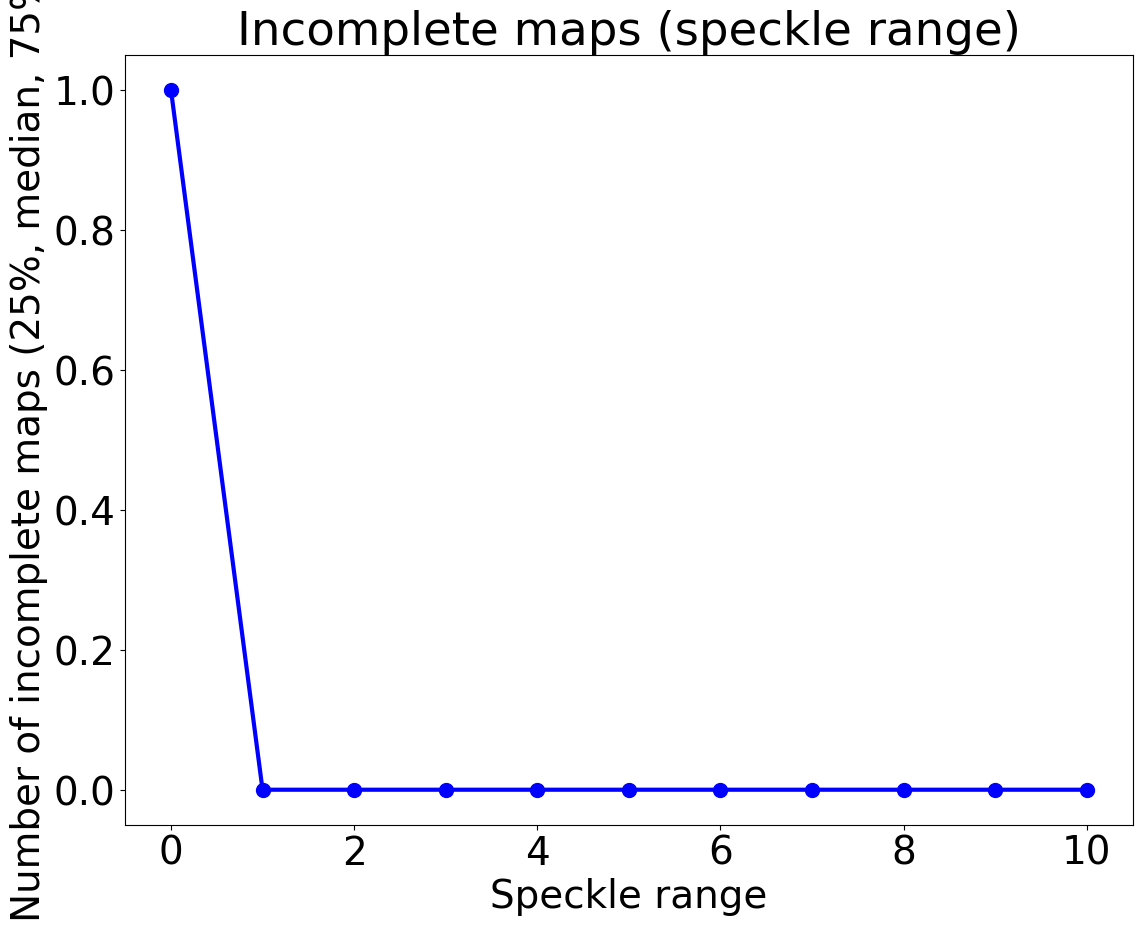

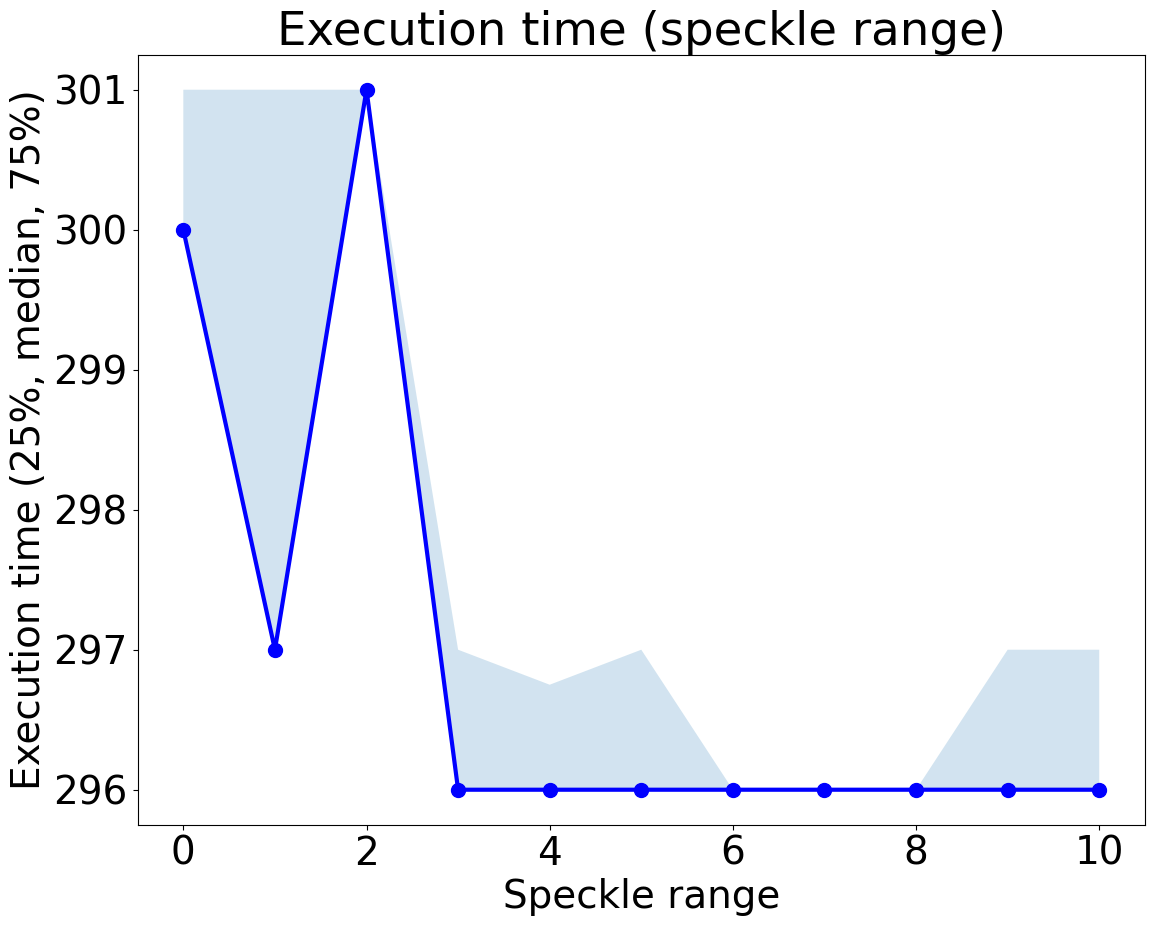

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Speckle range', 'Holes detected (25%, median, 75%)', "Holes detected (speckle range)", True,colors,"../Data/Graphs/Disparity/SpeckleRange/speckle_range_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Speckle range', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (speckle range)", True,colors,"../Data/Graphs/Disparity/SpeckleRange/speckle_range_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Speckle range', 'Percentage valid pixels (25%, median, 75%)', "Valid pixels after speckle filter (speckle range)", True,colors,"../Data/Graphs/Disparity/SpeckleRange/speckle_range_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Speckle range', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (speckle range)", True,colors,"../Data/Graphs/Disparity/SpeckleRange/speckle_range_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Speckle range', 'Execution time (25%, median, 75%)', "Execution time (speckle range)", True,colors,"../Data/Graphs/Disparity/SpeckleRange/speckle_range_execution_time.png")

Conclusion:
Lowest execution time at 3 and above.
Unusable at value of 0 due to every map being incomplete.
8 seems to result in fewest speckles remaining.
Less invalid pixels with increased range.
Increased amount of holes with increased range.


4 is chosen as a compromise between holes and speckles.


## Block size (Done)

In [68]:
import csv

# Paths
path = ["../Data/Disparity_settings/block_size.csv"]

# Other variables
settings = [1,3,5,7,9,11,13,15,17]

# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

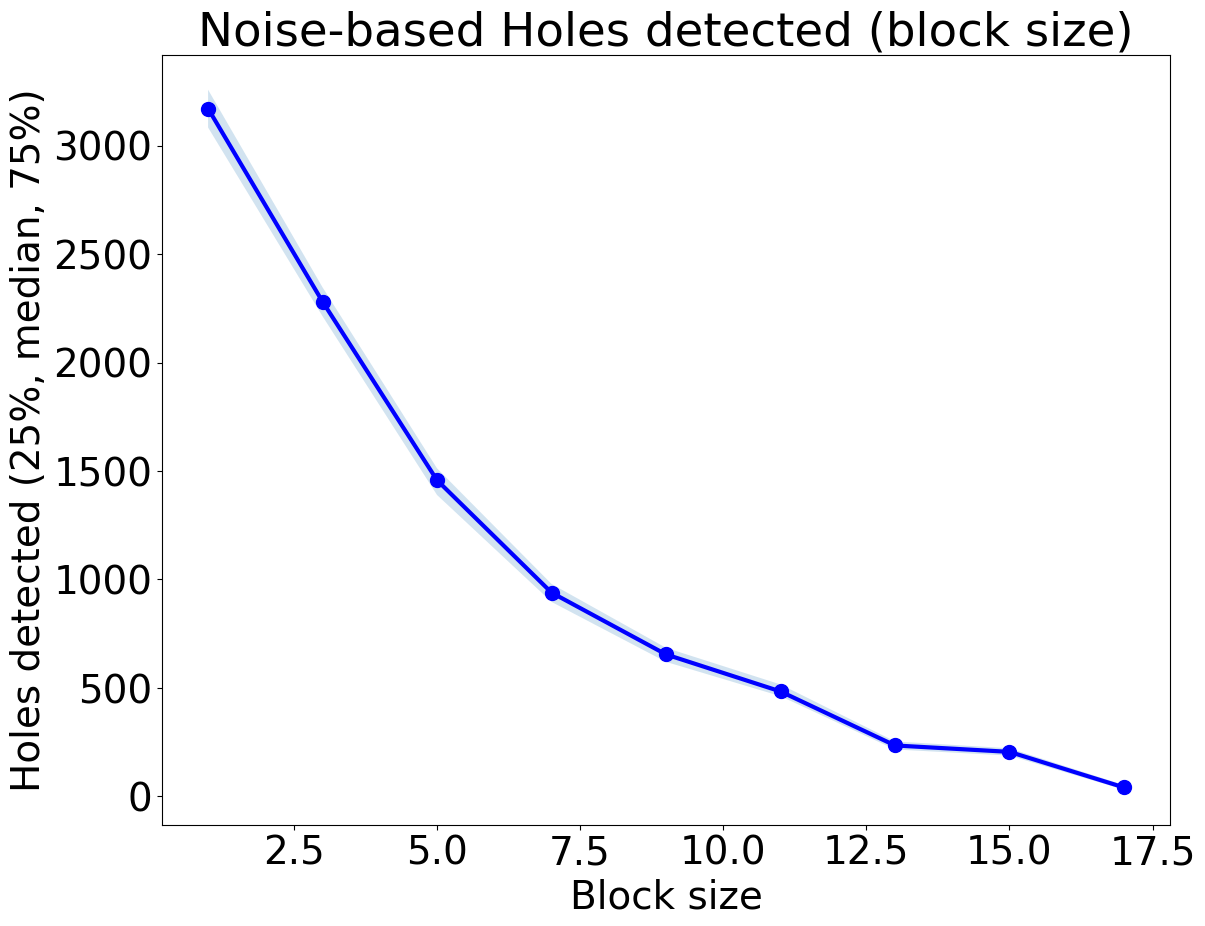

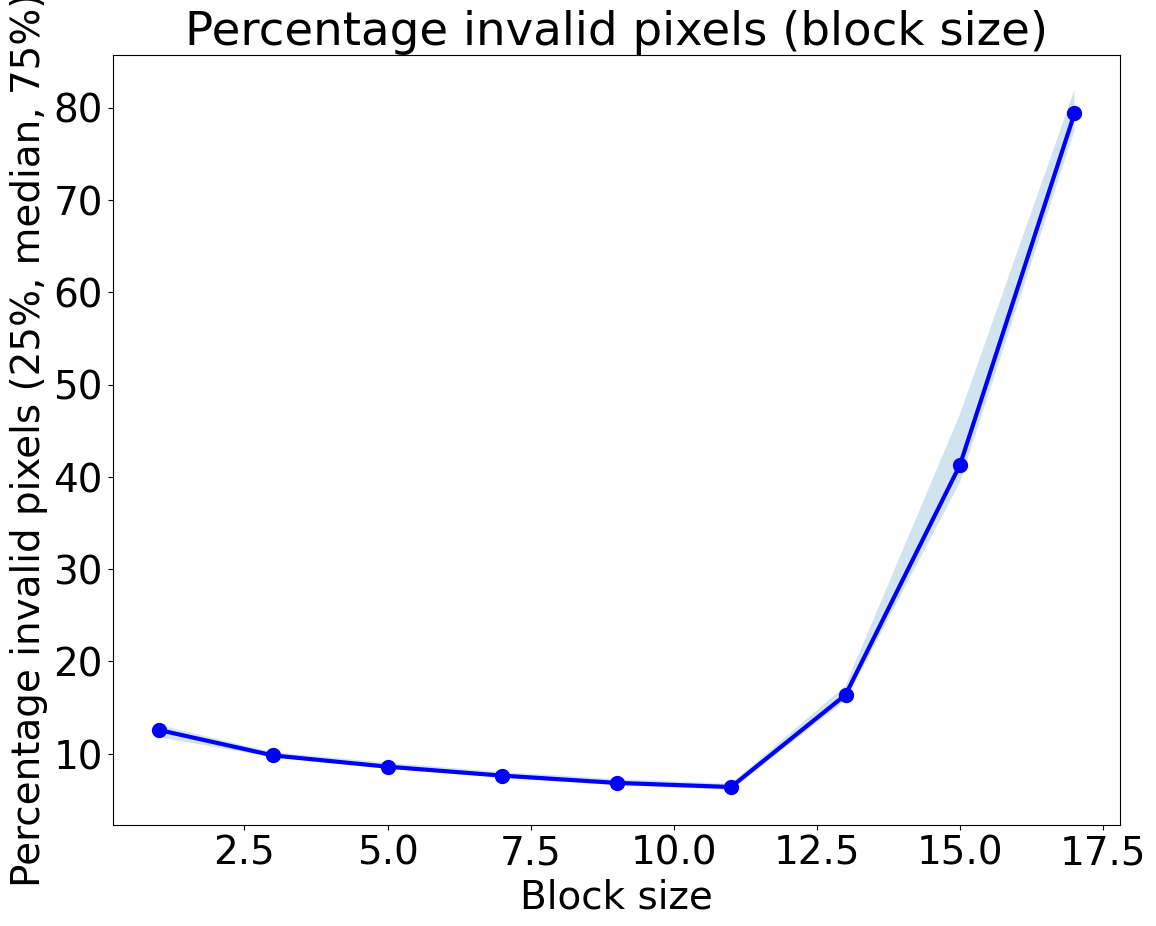

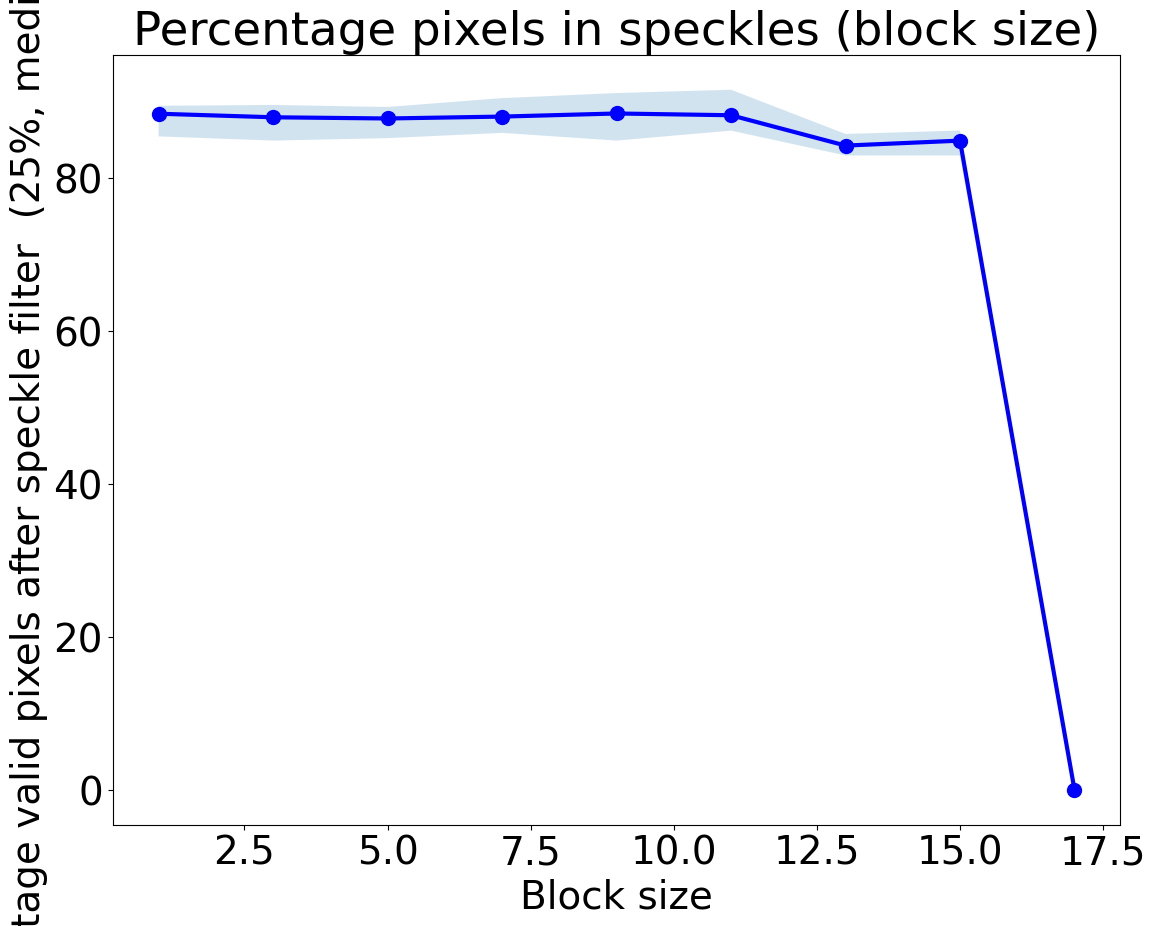

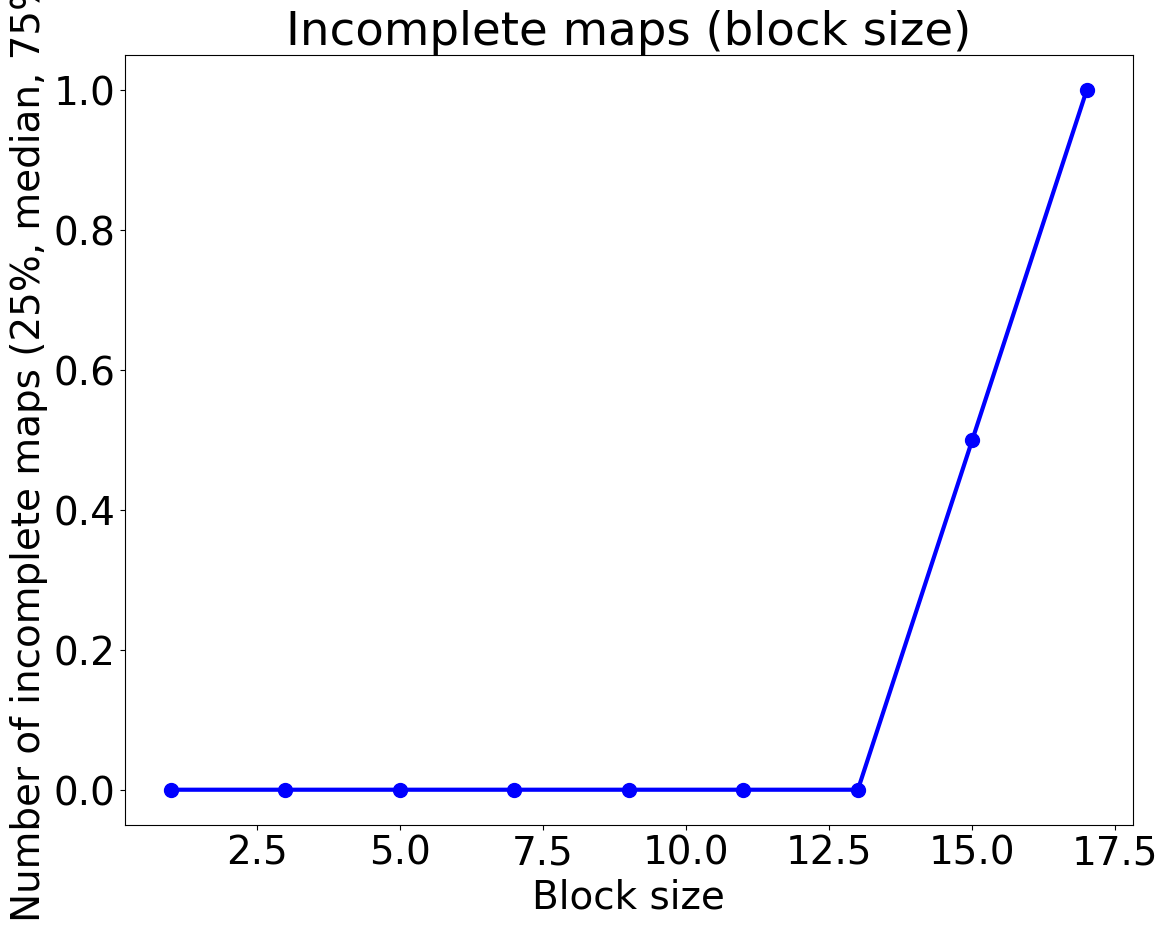

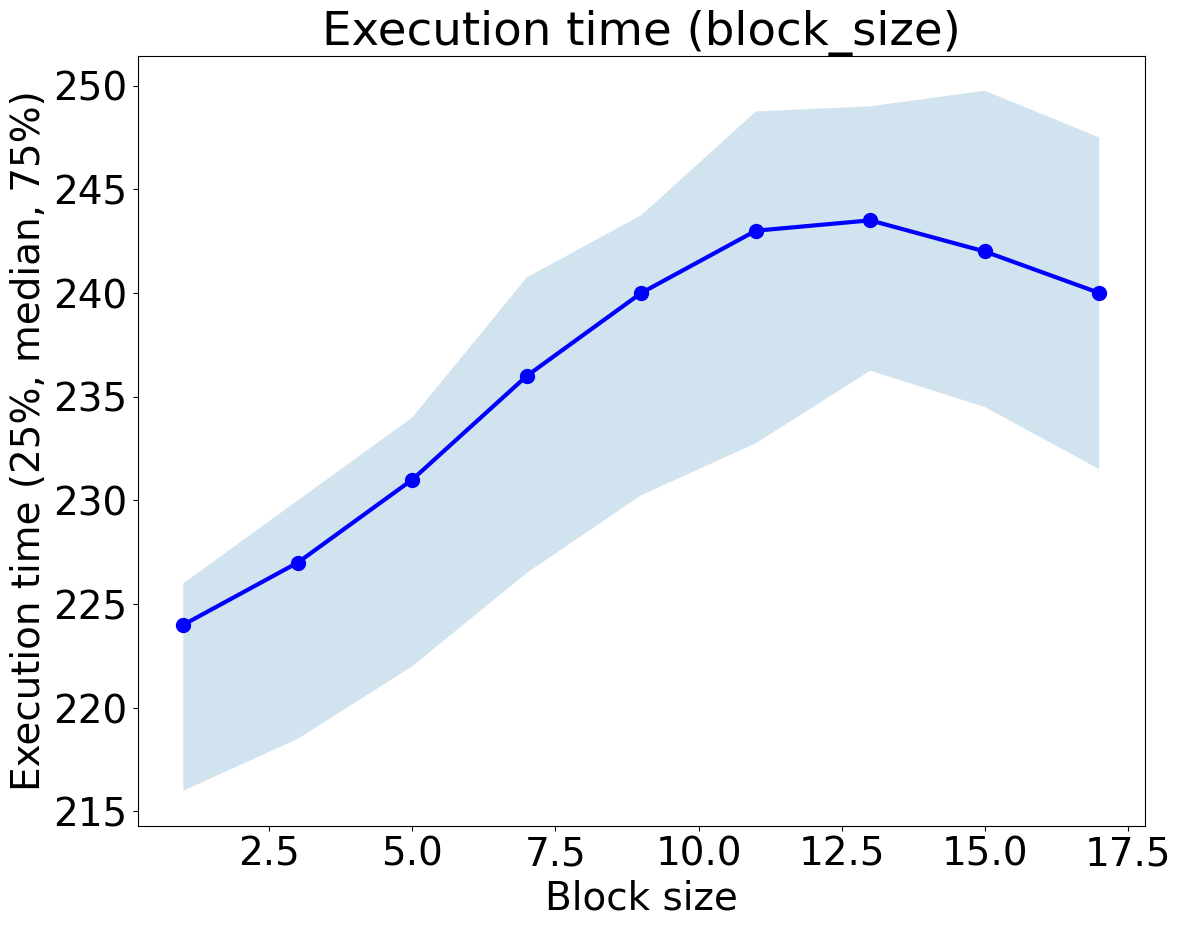

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Block size', 'Holes detected (25%, median, 75%)', "Noise-based Holes detected (block size)", True,colors,"../Data/Graphs/Disparity/BlockSize/block_size_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Block size', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (block size)", True,colors,"../Data/Graphs/Disparity/BlockSize/block_size_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Block size', 'Percentage valid pixels after speckle filter  (25%, median, 75%)', "Percentage pixels in speckles (block size)", True,colors,"../Data/Graphs/Disparity/BlockSize/block_size_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Block size', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (block size)", True,colors,"../Data/Graphs/Disparity/BlockSize/block_size_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Block size', 'Execution time (25%, median, 75%)', "Execution time (block_size)", True,colors,"../Data/Graphs/Disparity/BlockSize/block_size_execution_time.png")

Conclusion:
Maps begin to be unusable after 13.
Smaller sizes are faster.
Invalid pixels grow alot after 11.
Less holes the larger block size.

For this reason 11 is chosen.

## Disp12MaxDiff (Done)

In [74]:
import csv

# Paths
path = ["../Data/Disparity_settings/disp12MaxDiff.csv"]

# Other variables
settings = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

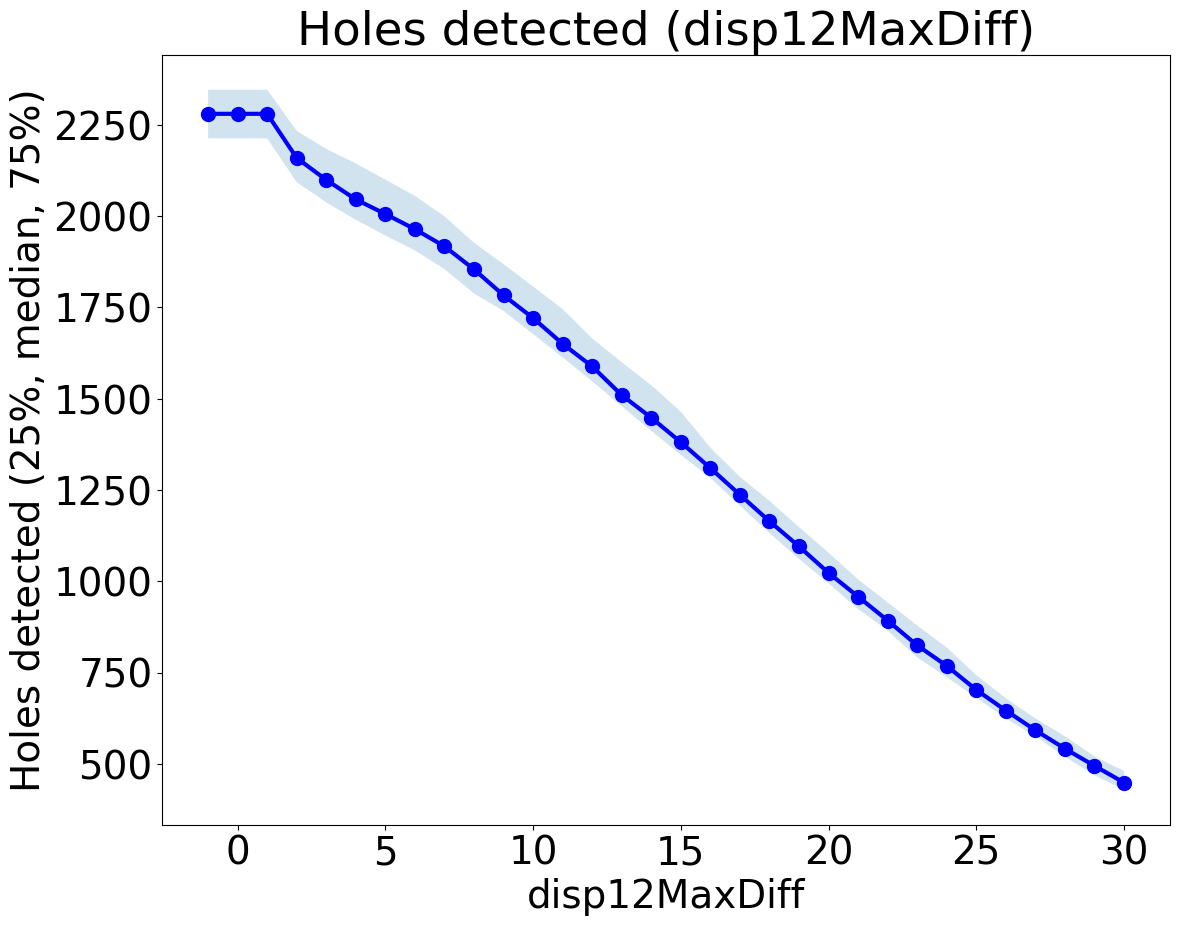

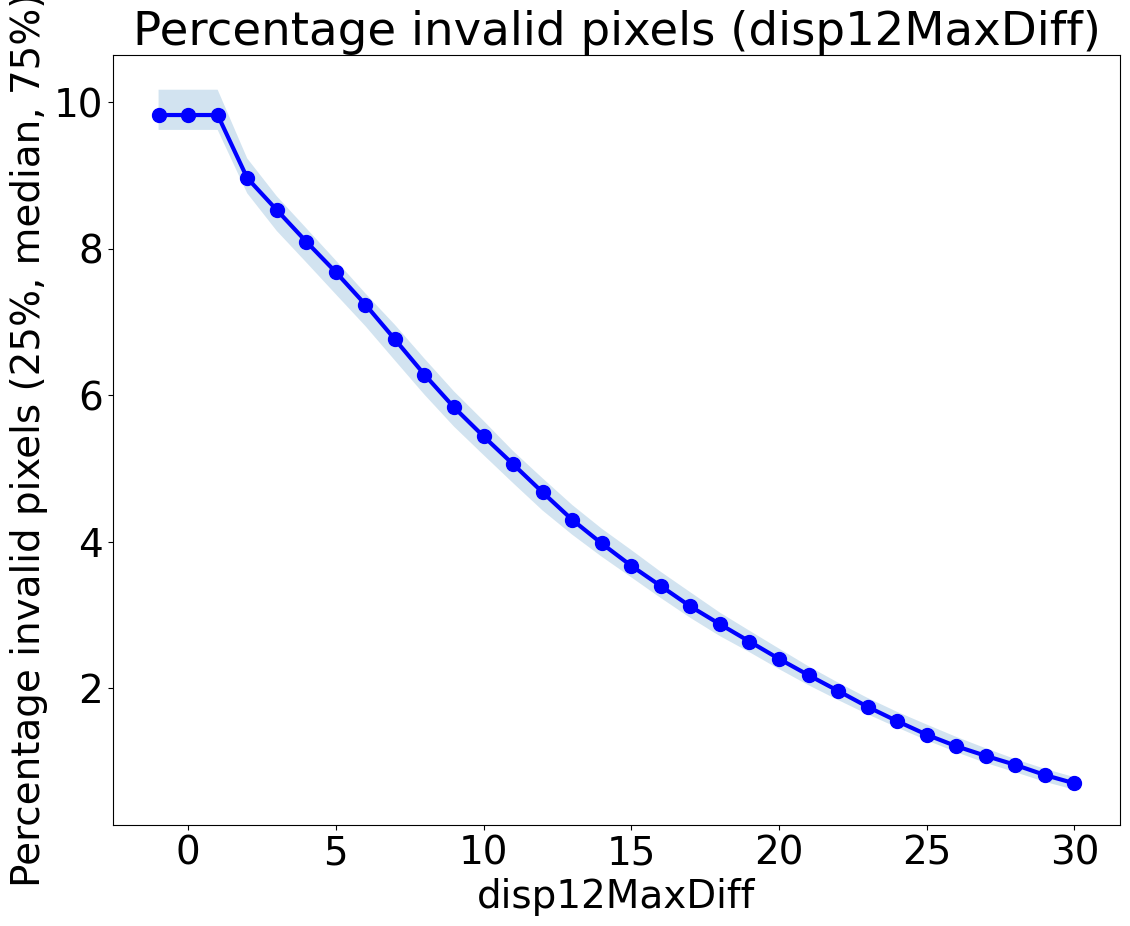

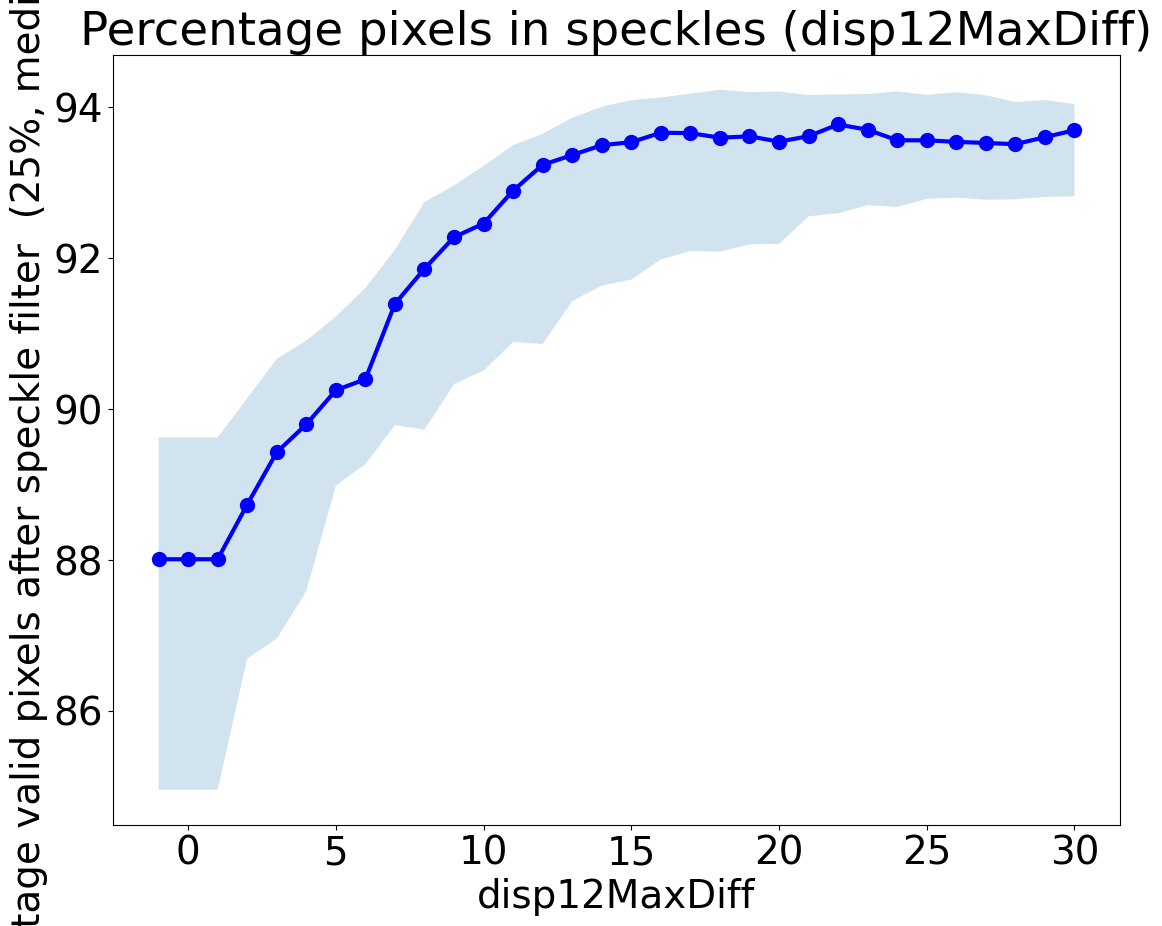

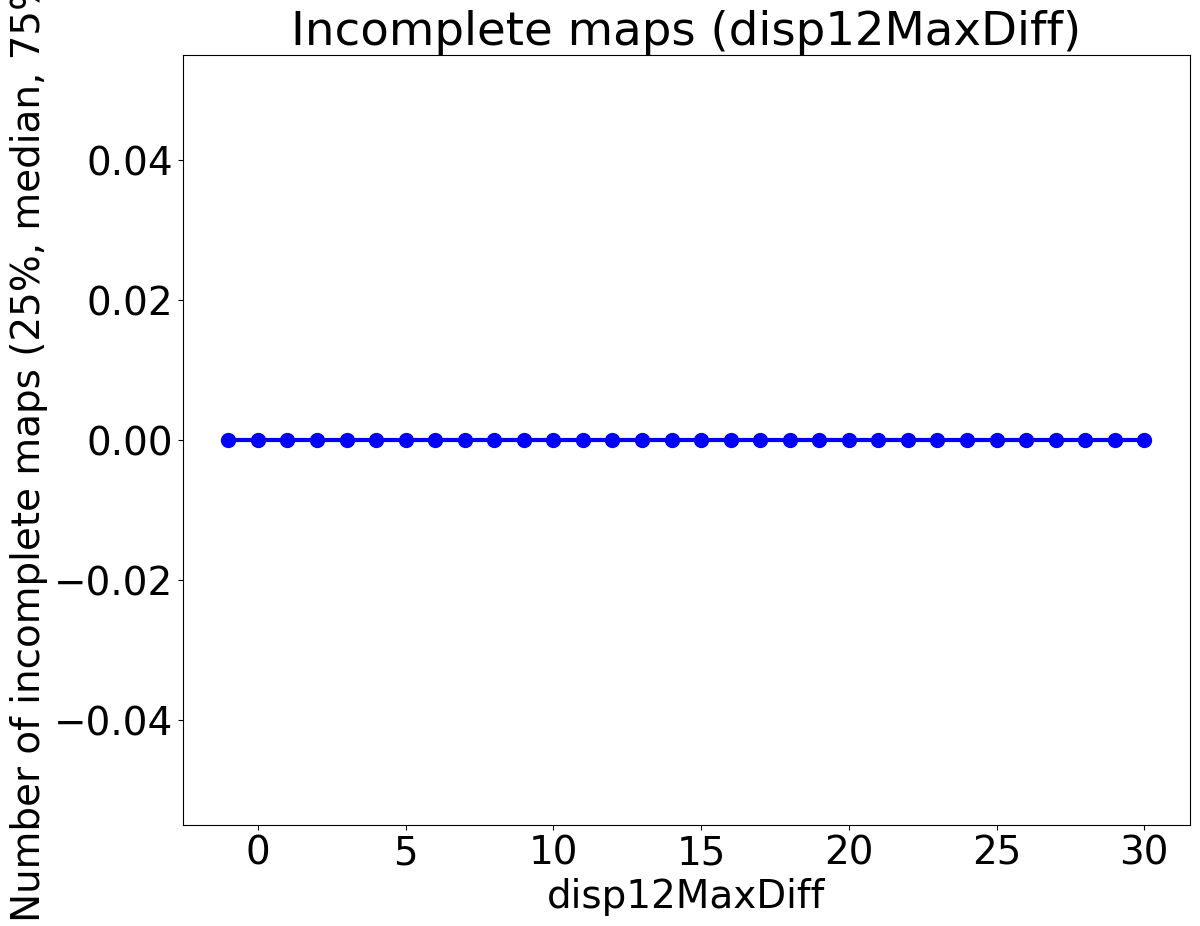

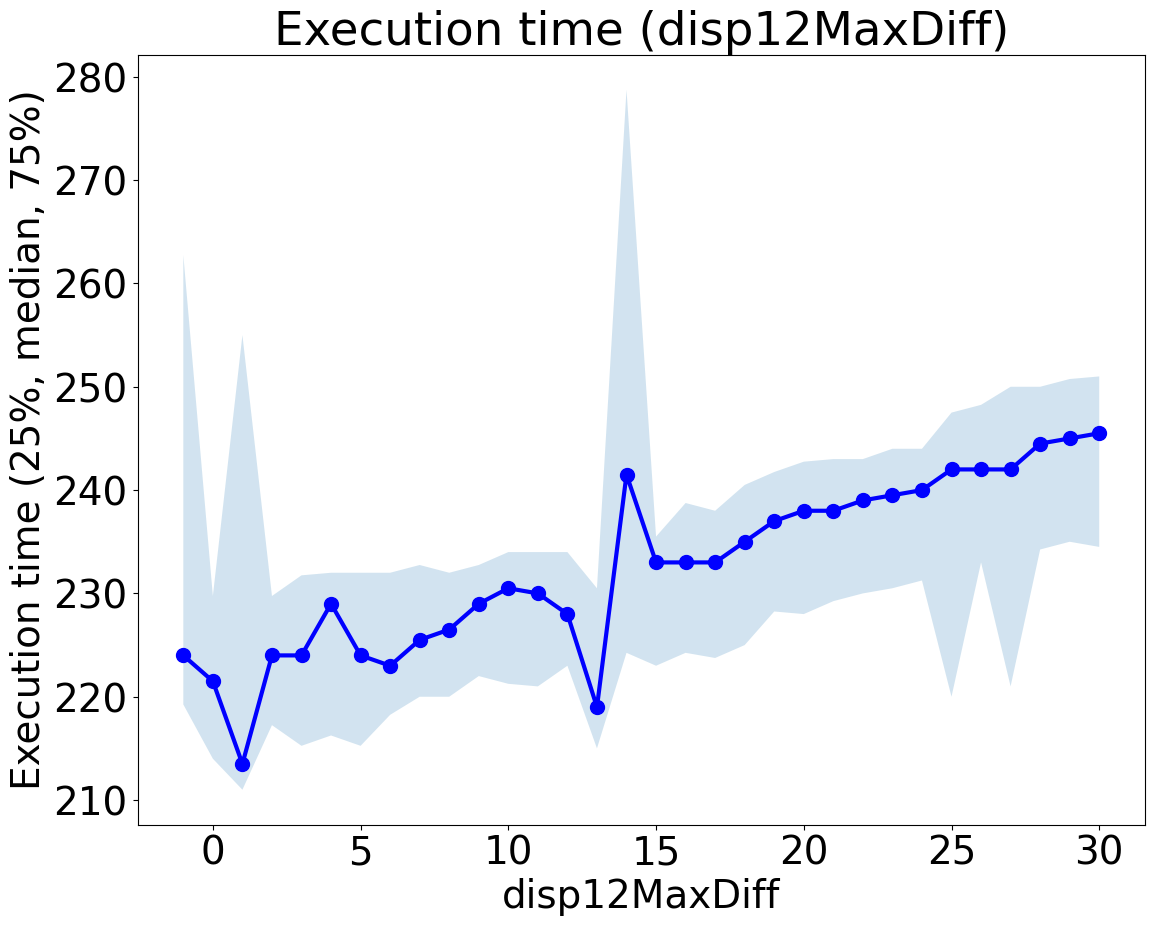

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'disp12MaxDiff', 'Holes detected (25%, median, 75%)', "Holes detected (disp12MaxDiff)", True,colors,"../Data/Graphs/Disparity/disp12MaxDiff/disp12MaxDiff_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'disp12MaxDiff', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (disp12MaxDiff)", True,colors,"../Data/Graphs/Disparity/disp12MaxDiff/disp12MaxDiff_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'disp12MaxDiff', 'Percentage valid pixels after speckle filter  (25%, median, 75%)', "Percentage pixels in speckles (disp12MaxDiff)", True,colors,"../Data/Graphs/Disparity/disp12MaxDiff/disp12MaxDiff_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'disp12MaxDiff', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (disp12MaxDiff)", True,colors,"../Data/Graphs/Disparity/disp12MaxDiff/disp12MaxDiff_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'disp12MaxDiff', 'Execution time (25%, median, 75%)', "Execution time (disp12MaxDiff)", True,colors,"../Data/Graphs/Disparity/disp12MaxDiff/disp12MaxDiff_execution_time.png")

Conclusion: 
Bigger allowed difference leads to less holes
Bigger allowed difference leads to less invalid pixels
Bigger allowed difference leads to less speckles existing
Slight increase in execution time with bigger allowed differences.

For this reason 15 is chosen as a compromise between execution time and quality

## Minimum disparity (Done)

In [80]:
import csv

# Paths
path = ["../Data/Disparity_settings/min_disparity.csv"]

# Other variables
settings = [-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

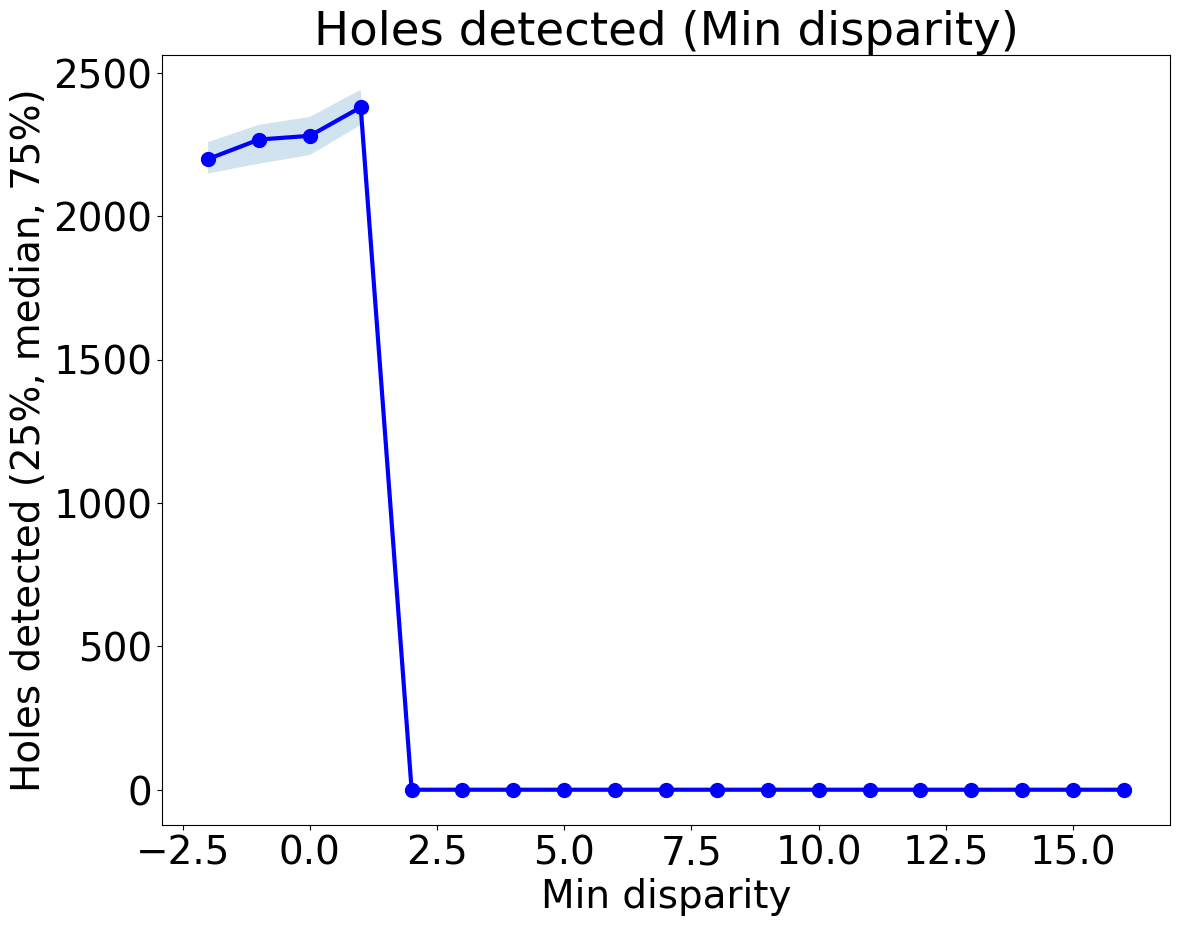

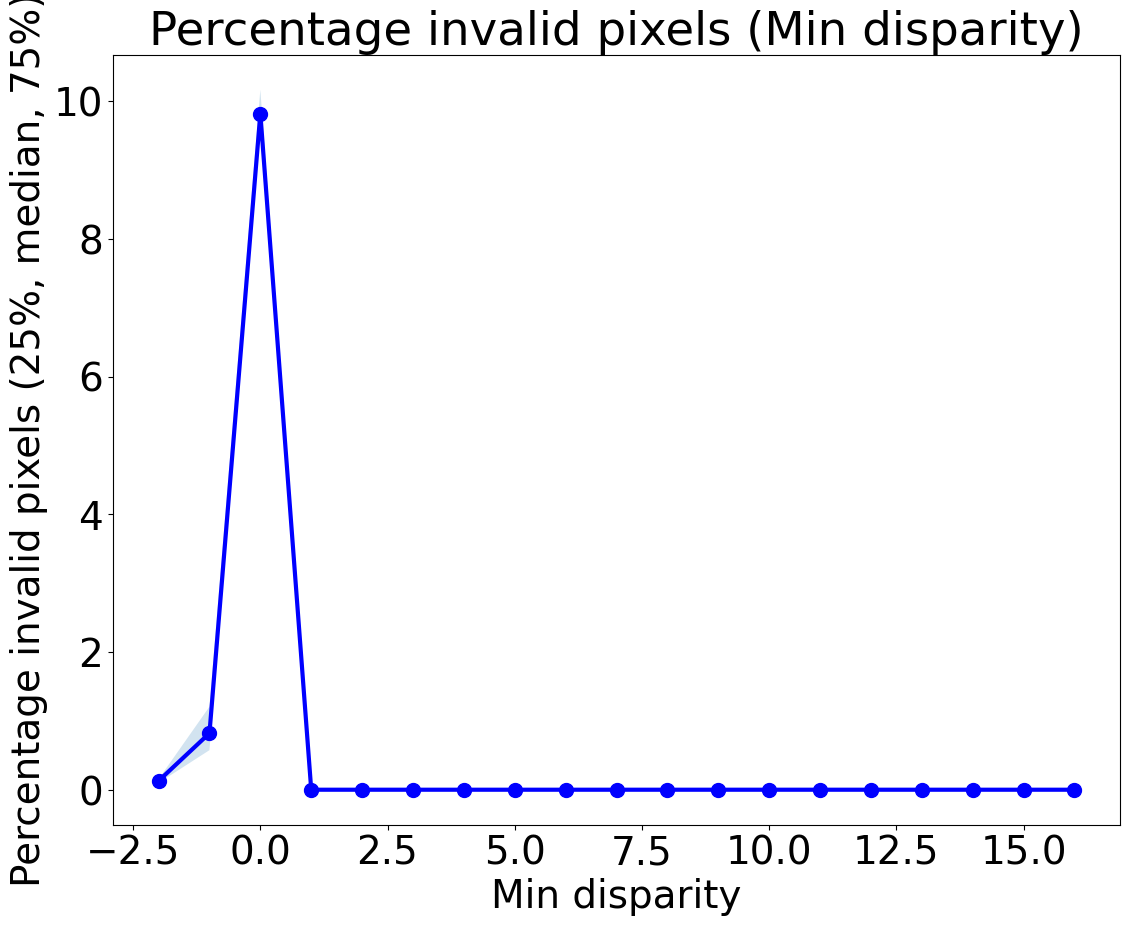

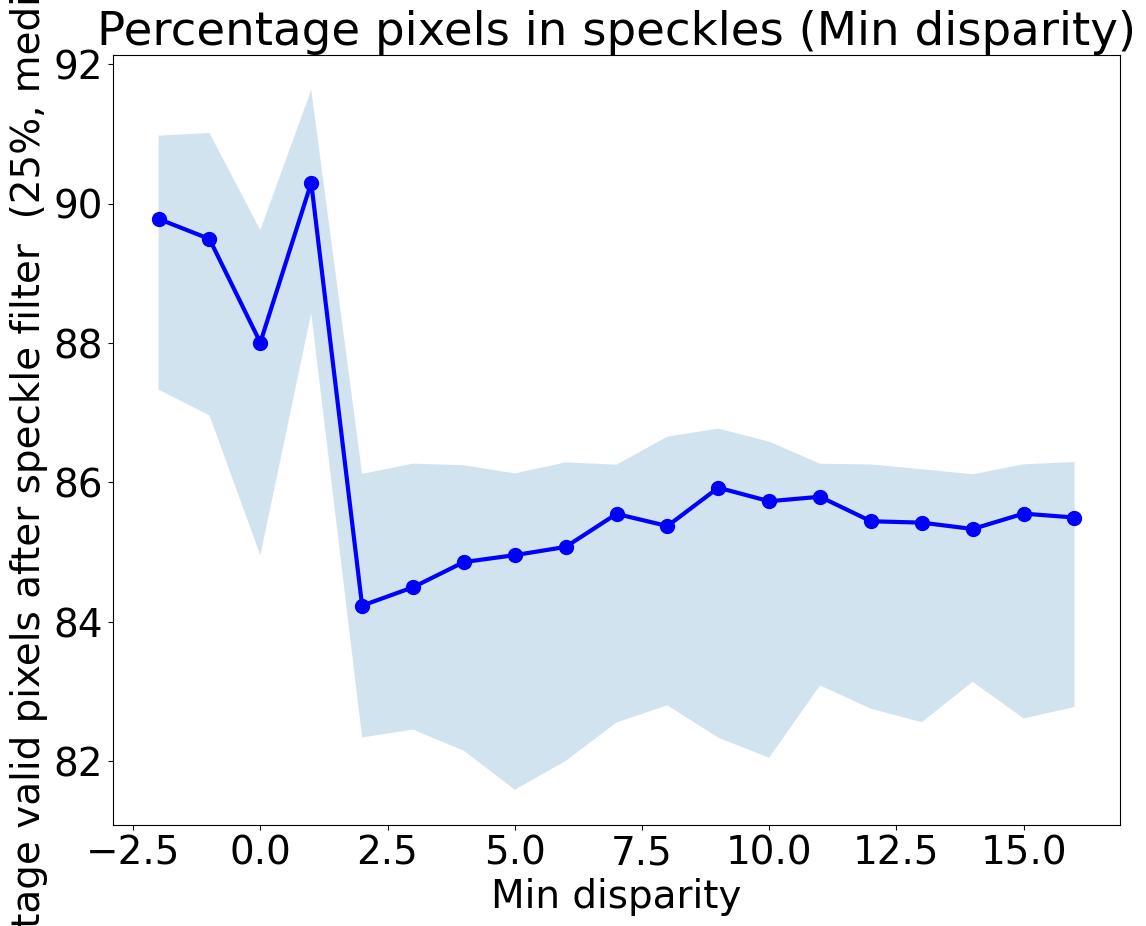

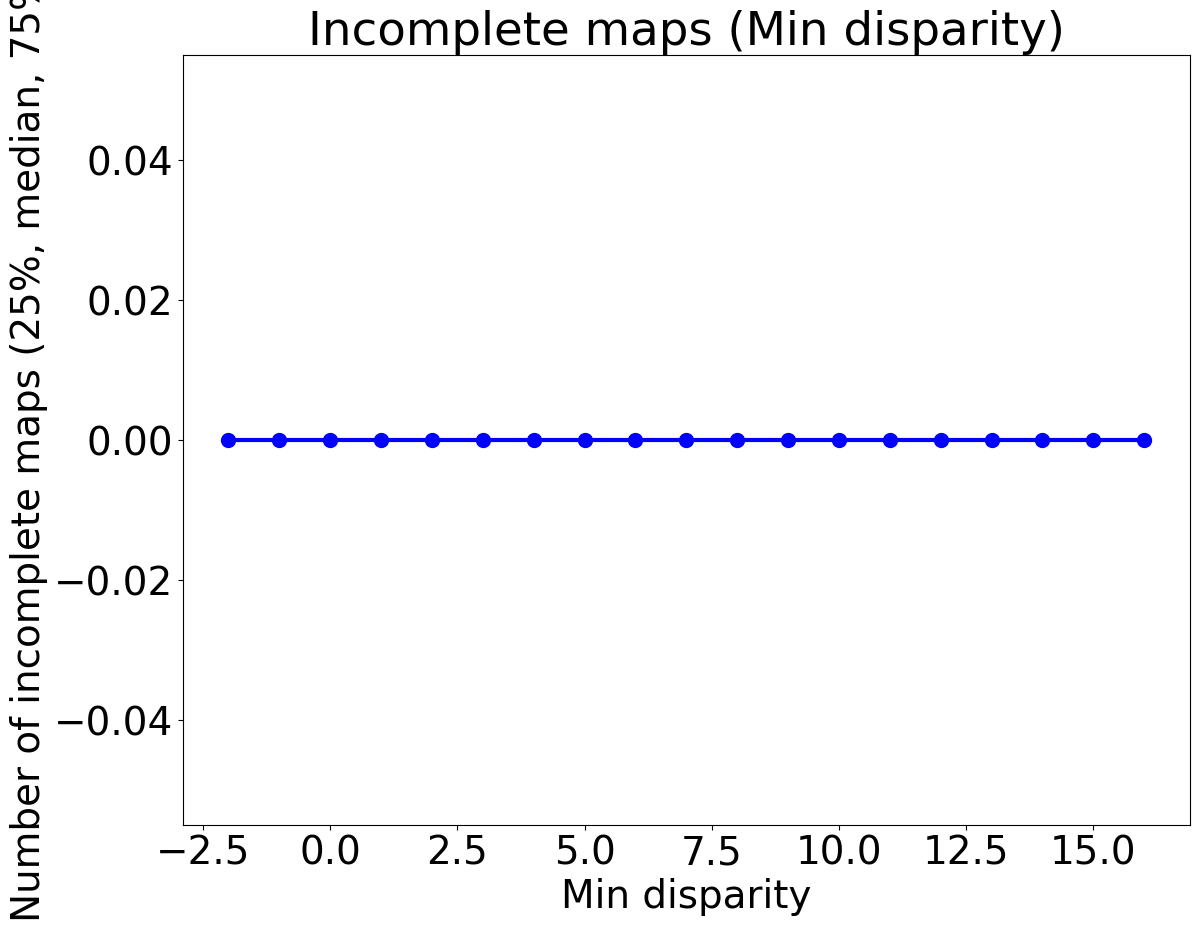

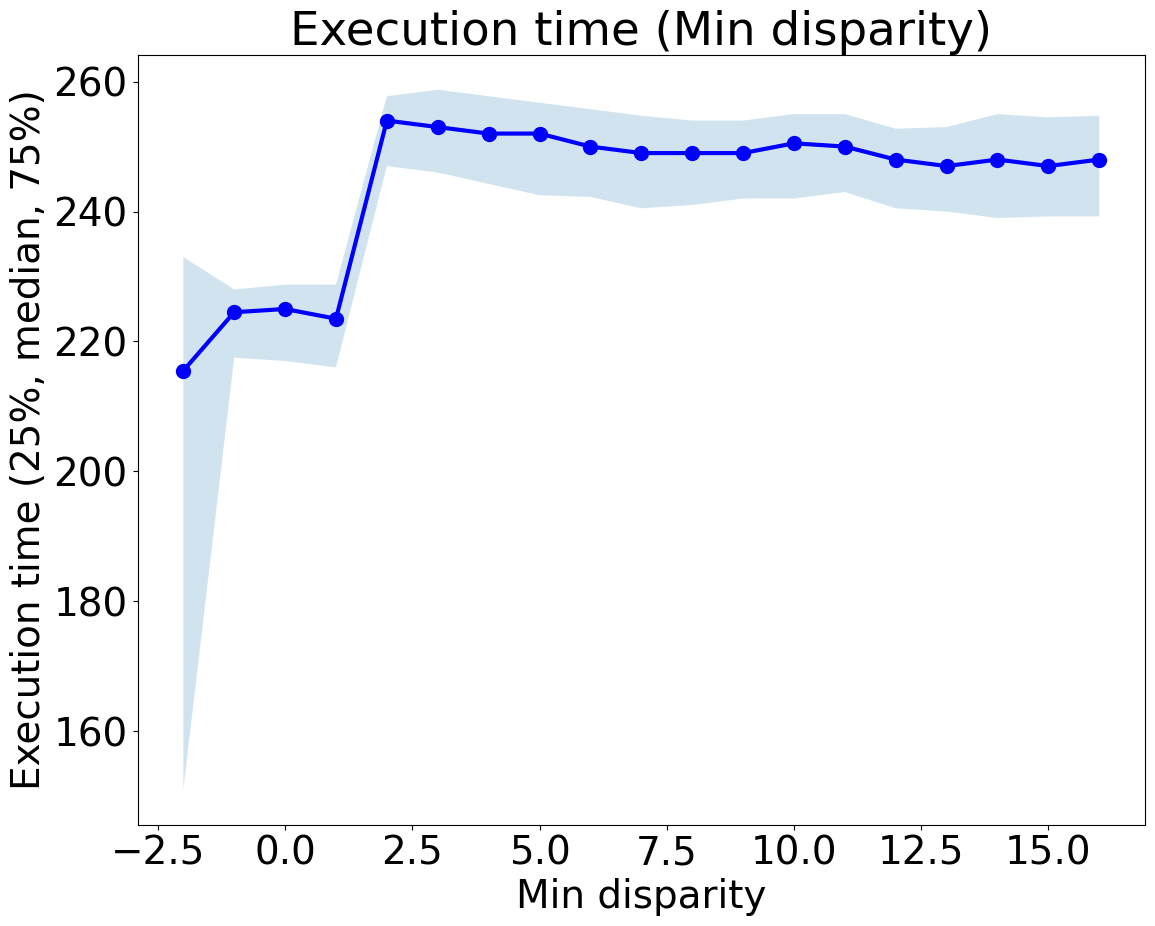

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Min disparity', 'Holes detected (25%, median, 75%)', "Holes detected (Min disparity)", True,colors,"../Data/Graphs/Disparity/MinDisparity/MinDisparity_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Min disparity', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (Min disparity)", True,colors,"../Data/Graphs/Disparity/MinDisparity/MinDisparity_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Min disparity', 'Percentage valid pixels after speckle filter  (25%, median, 75%)', "Percentage pixels in speckles (Min disparity)", True,colors,"../Data/Graphs/Disparity/MinDisparity/MinDisparity_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Min disparity', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (Min disparity)", True,colors,"../Data/Graphs/Disparity/MinDisparity/MinDisparity_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Min disparity', 'Execution time (25%, median, 75%)', "Execution time (Min disparity)", True,colors,"../Data/Graphs/Disparity/MinDisparity/MinDisparity_execution_time.png")

Conclusion:
Values above 1 leads to no holes
No invalid pixels at values of 1 and above
Fewest speckles at the value of 1
Slower if values at 2 or above.

Kept at 0 since the good results are solely due to no invalid pixels being located. Images do however show same amount of holes and added white noise.

## Number of disparities (done)

In [84]:
import csv

# Paths
path = ["../Data/Disparity_settings/number_of_disparities.csv"]

# Other variables
settings = [16,32,48,64,80,112,128,144,160]

# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

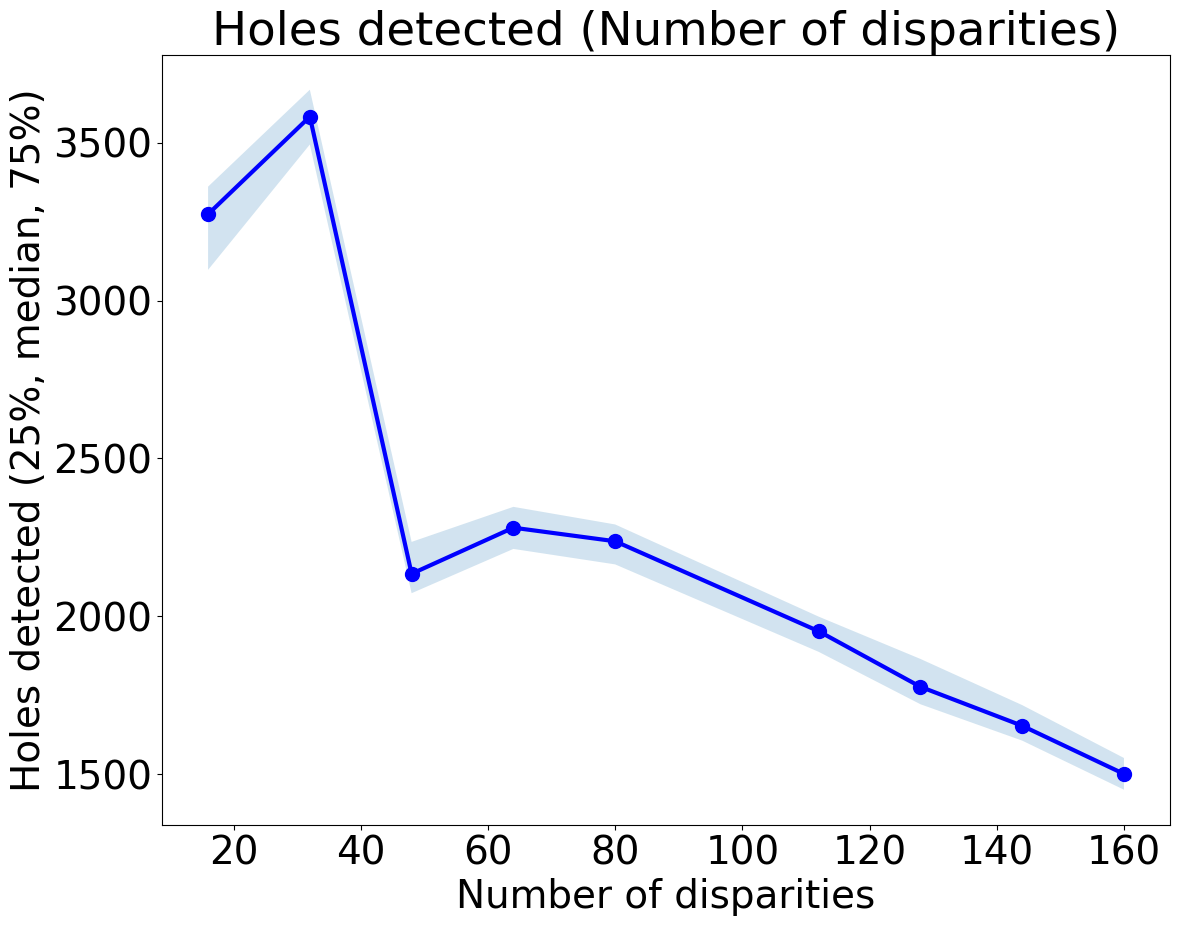

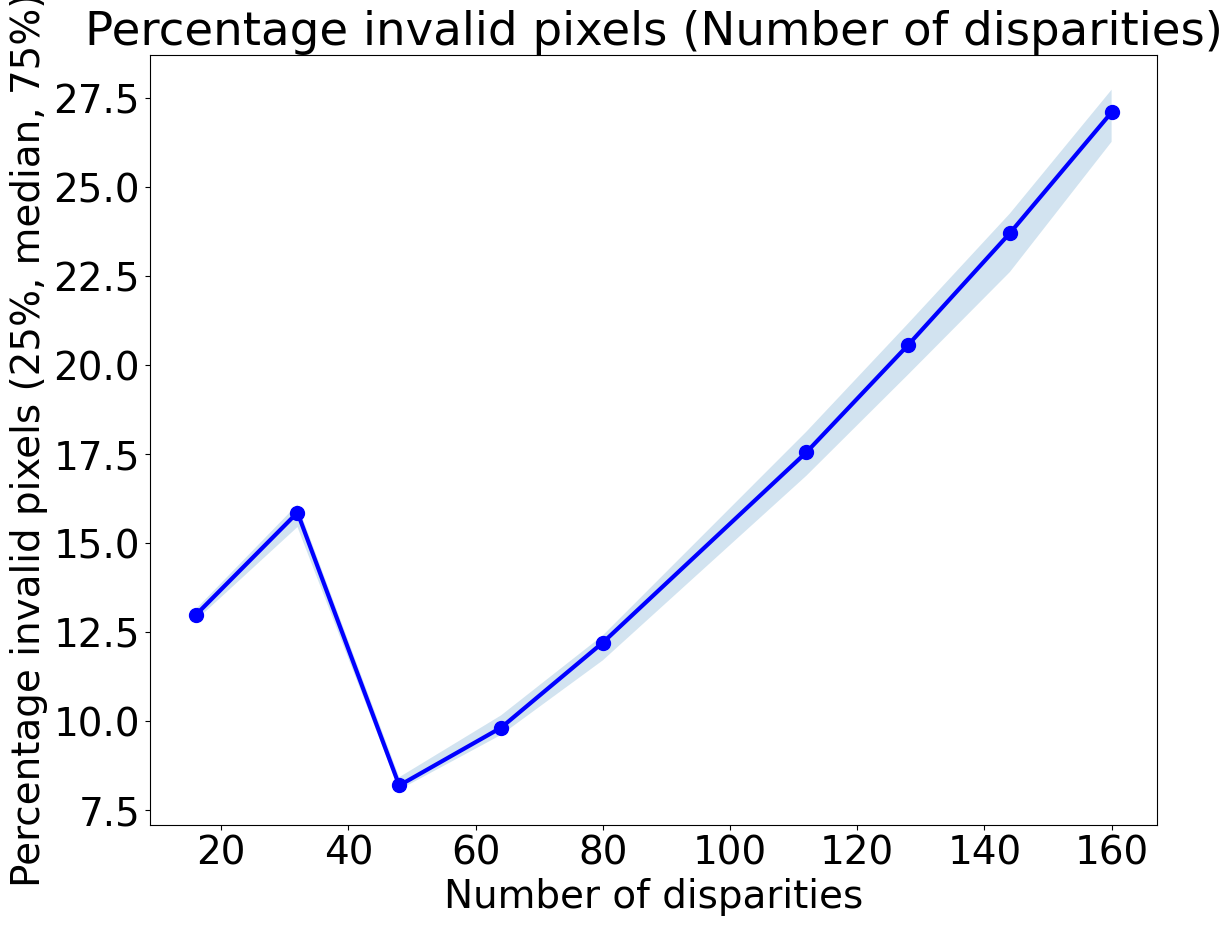

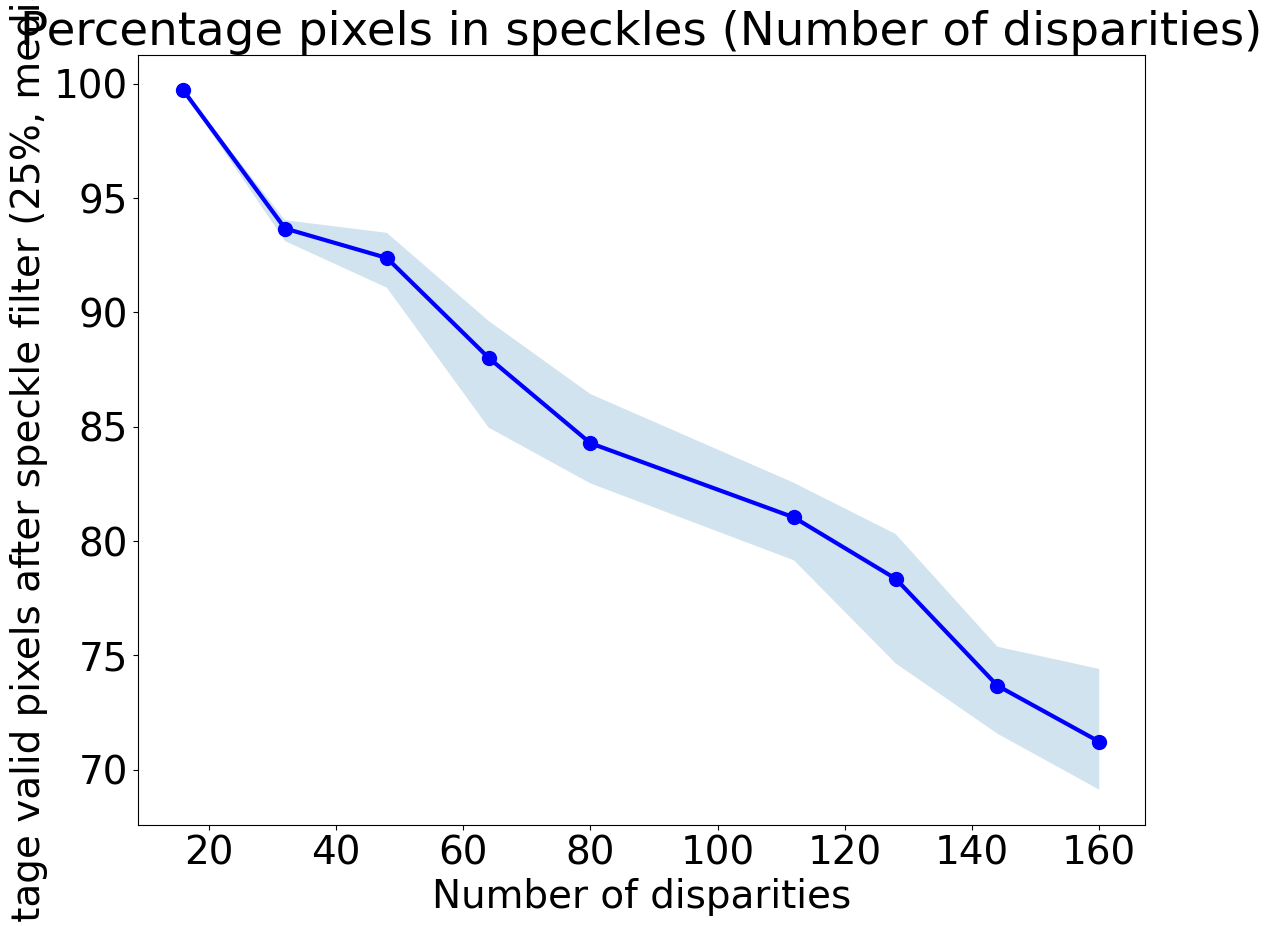

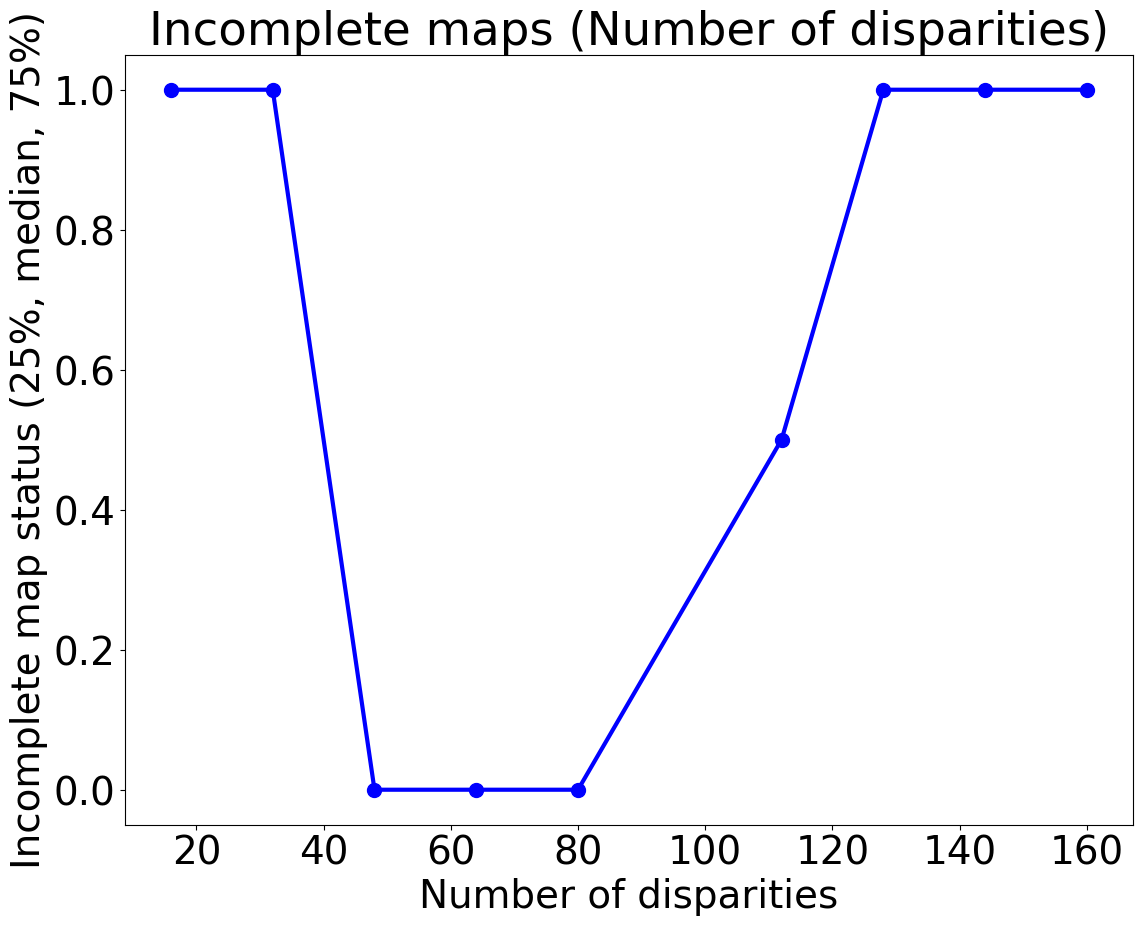

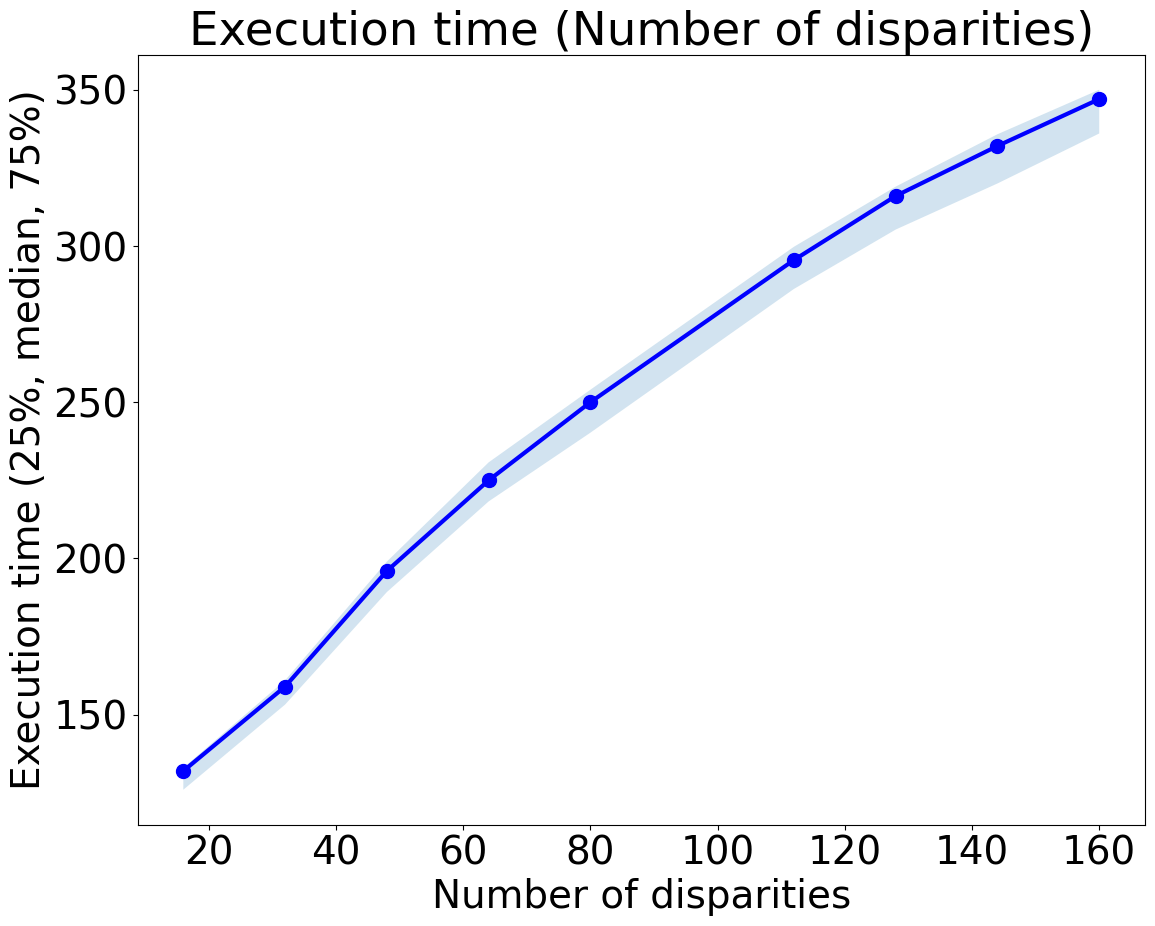

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Number of disparities', 'Holes detected (25%, median, 75%)', "Holes detected (Number of disparities)", True,colors,"../Data/Graphs/Disparity/NumDisparity/NumDisparity_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Number of disparities', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (Number of disparities)", True,colors,"../Data/Graphs/Disparity/NumDisparity/NumDisparity_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Number of disparities', 'Percentage valid pixels after speckle filter (25%, median, 75%)', "Percentage pixels in speckles (Number of disparities)", True,colors,"../Data/Graphs/Disparity/NumDisparity/NumDisparity_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Number of disparities', 'Incomplete map status (25%, median, 75%)', "Incomplete maps (Number of disparities)", True,colors,"../Data/Graphs/Disparity/NumDisparity/NumDisparity_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Number of disparities', 'Execution time (25%, median, 75%)', "Execution time (Number of disparities)", True,colors,"../Data/Graphs/Disparity/NumDisparity/NumDisparity_execution_time.png")

Conclusion:

Larger number of disparities leads to less holes with biggest change at 48.
Increase in invalid pixels after 48 with 48 being the lowest amount of invalid pixels.
Increasing the number of disparities results in more speckles.
No valid data before 48 and after 80.
More disparities makes the process slower.

For this reason 48 is chosen. This is however also related to depth meaning that 48 might result in errors at closer distances. The pillars are however quite close in the tested dataset.

## preFilterCap (Done)

In [90]:
import csv

# Paths
path = ["../Data/Disparity_settings/preFilterCap.csv"]

# Other variables
settings =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

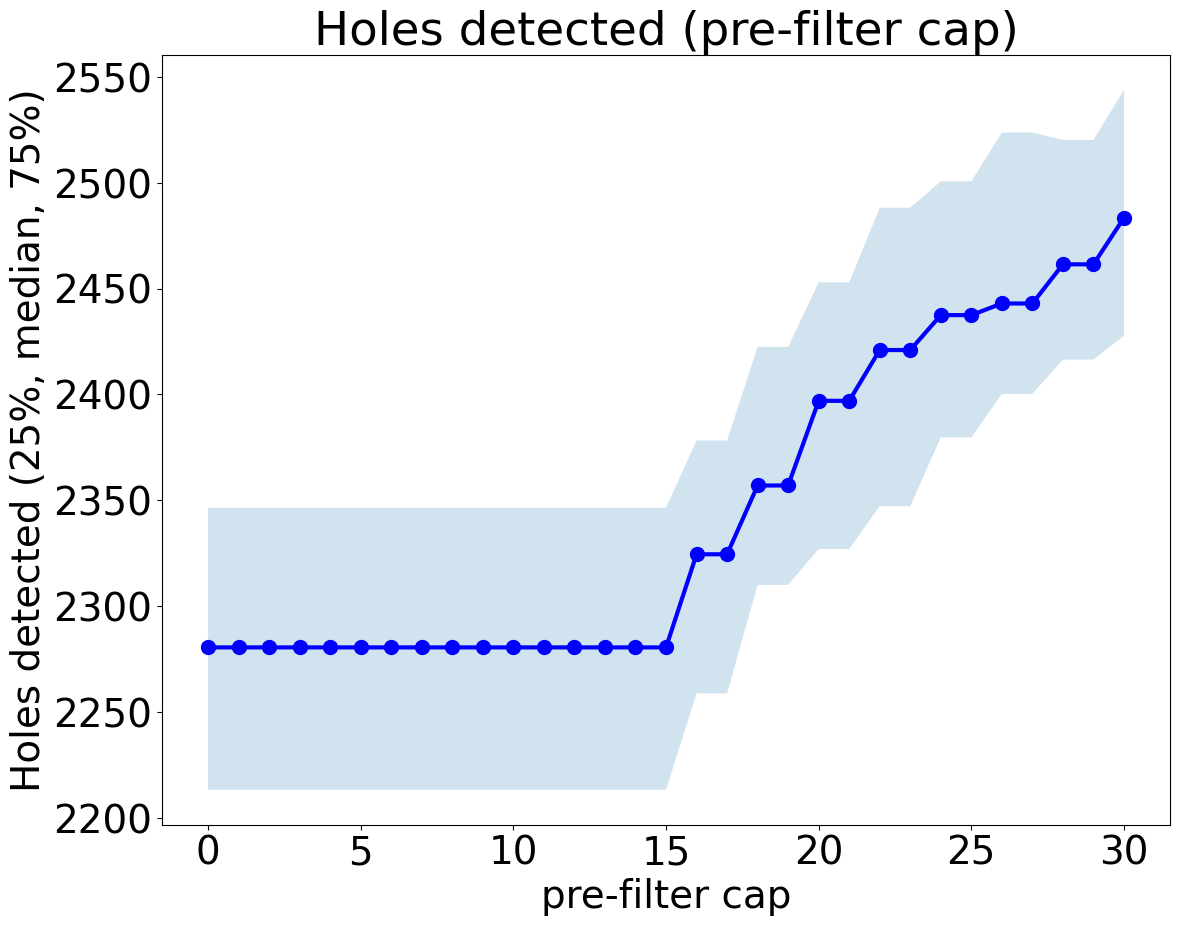

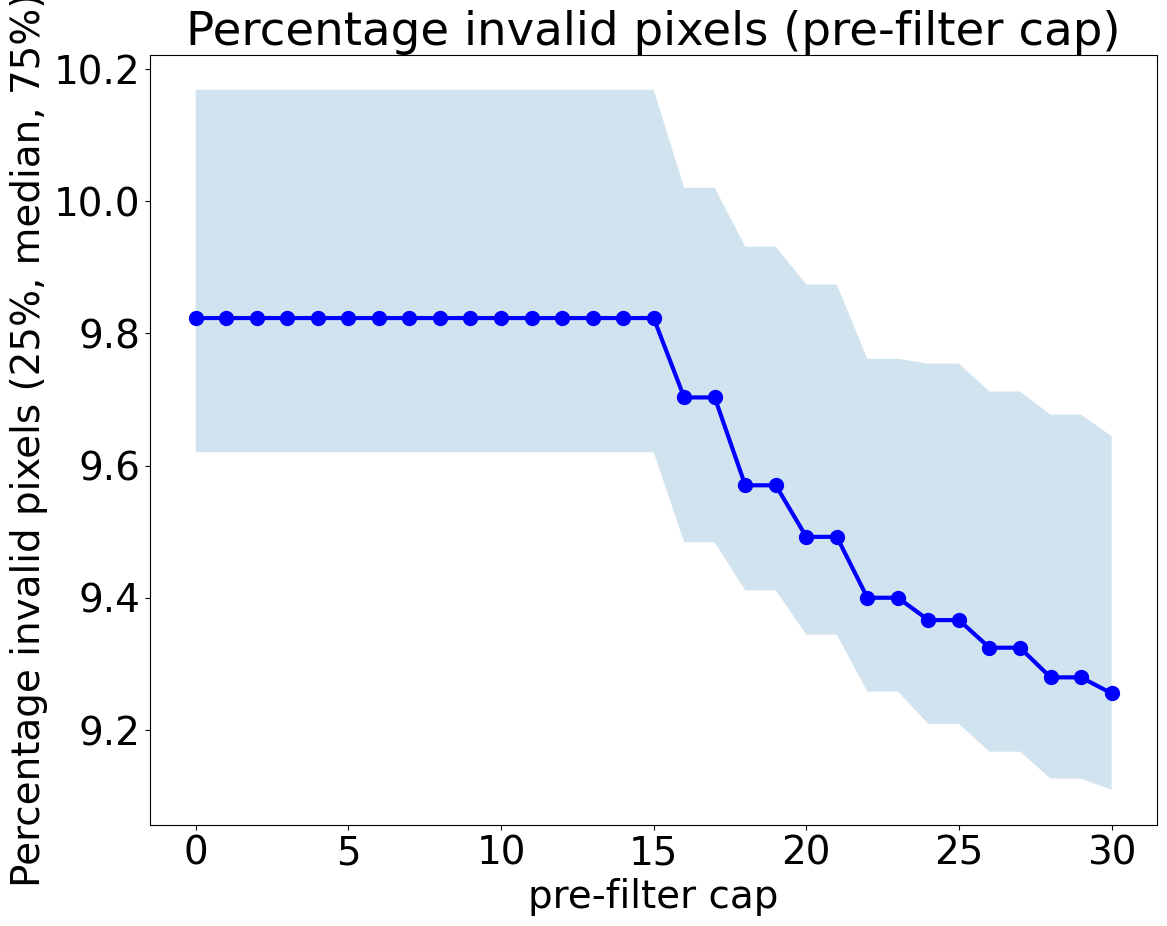

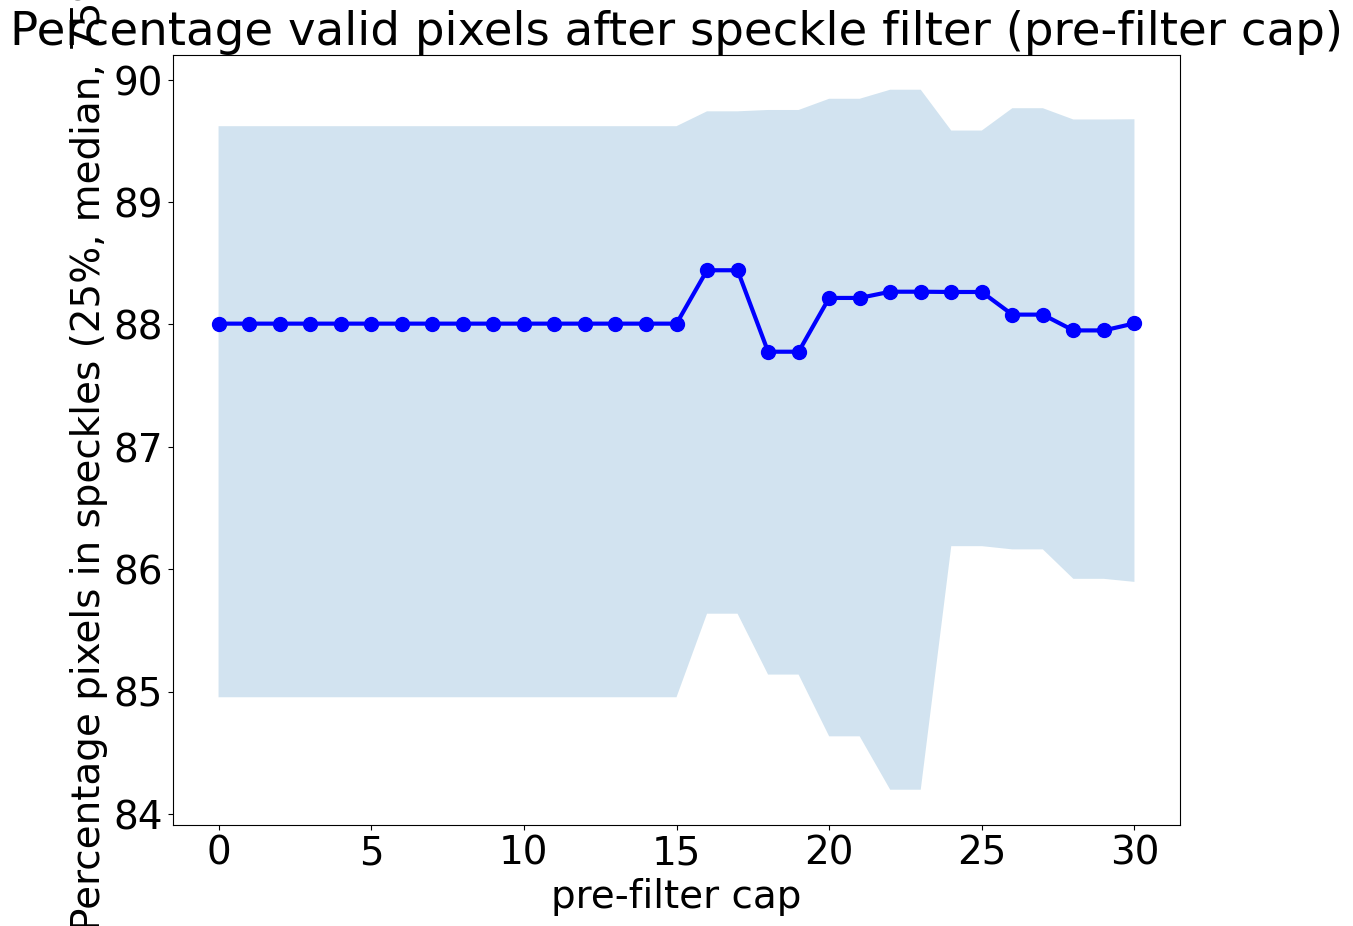

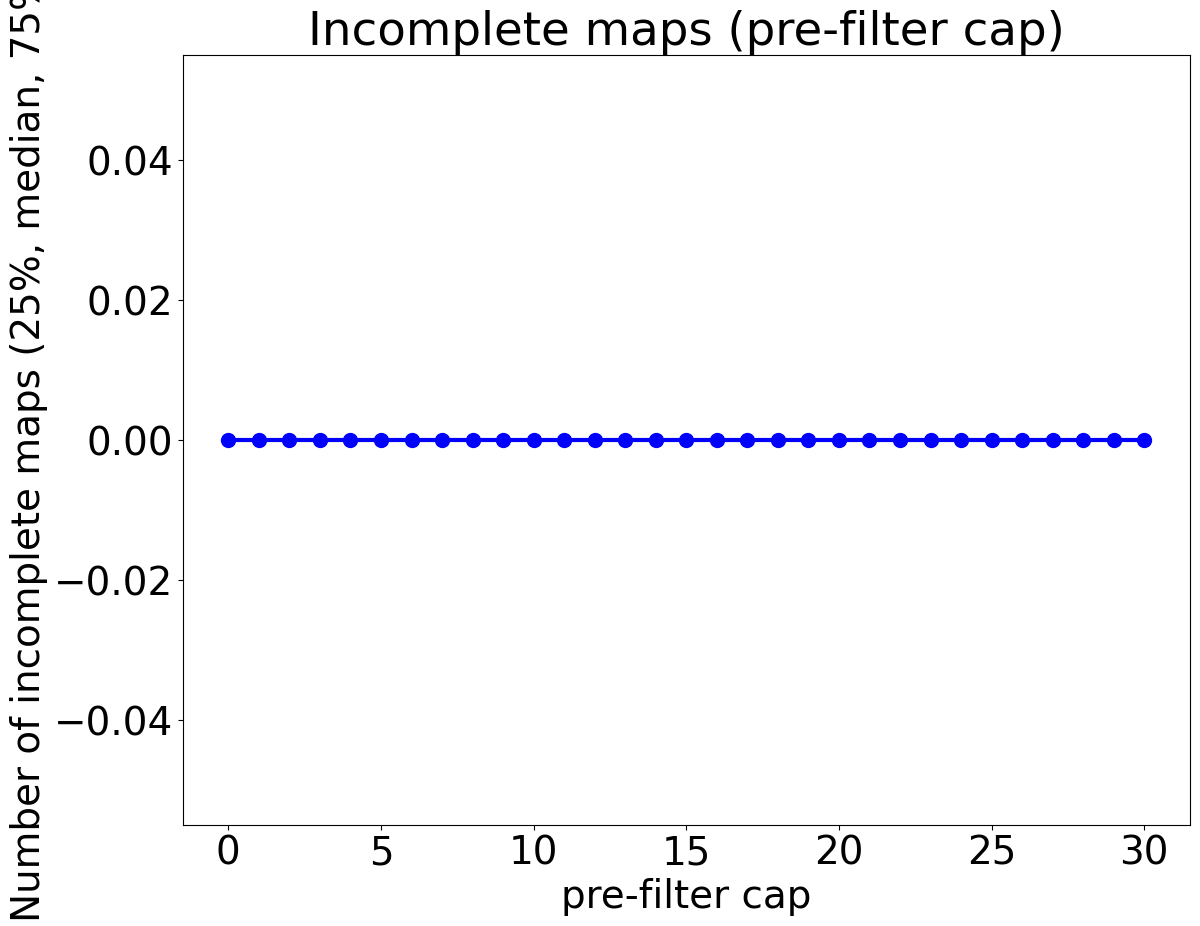

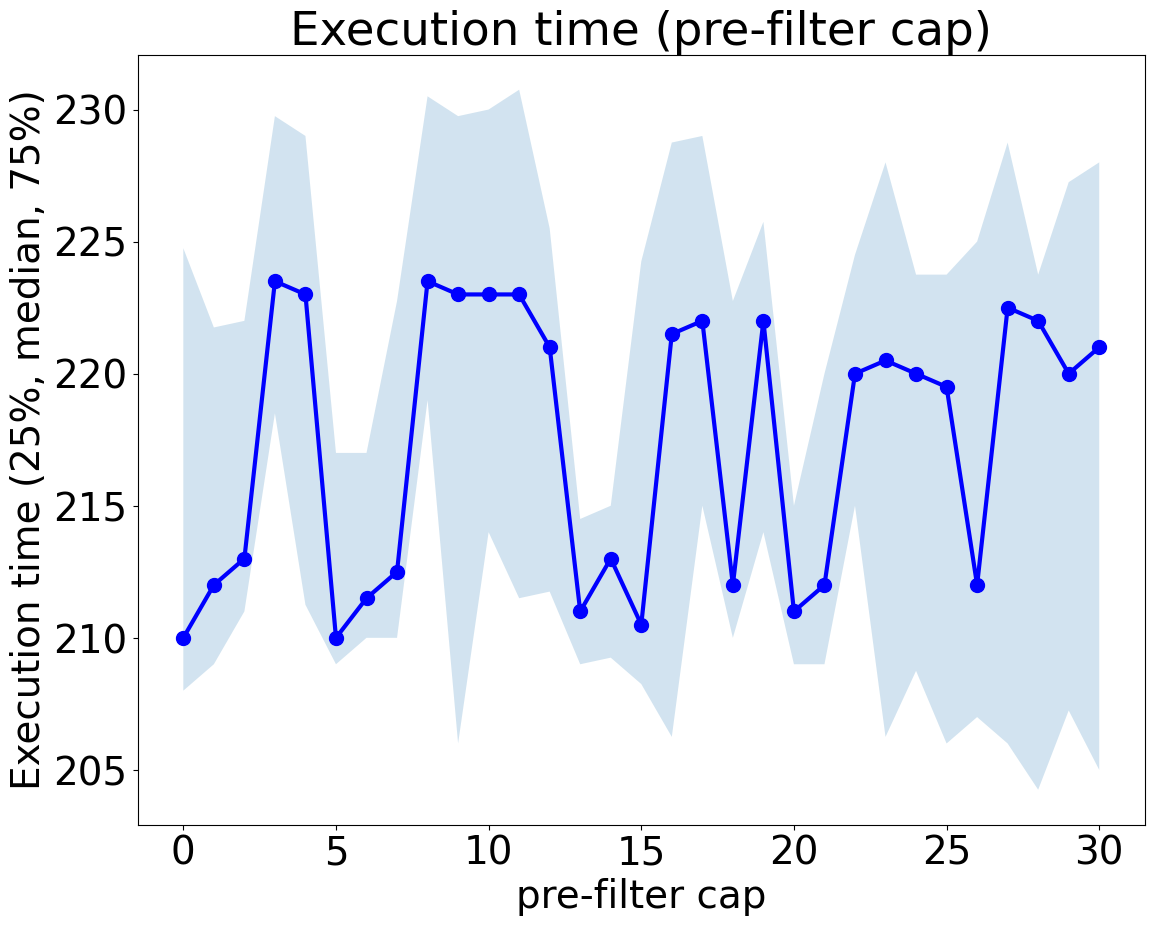

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'pre-filter cap', 'Holes detected (25%, median, 75%)', "Holes detected (pre-filter cap)", True,colors,"../Data/Graphs/Disparity/PreFilterCap/PreFilterCap_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'pre-filter cap', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (pre-filter cap)", True,colors,"../Data/Graphs/Disparity/PreFilterCap/PreFilterCap_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'pre-filter cap', 'Percentage pixels in speckles (25%, median, 75%)', "Percentage valid pixels after speckle filter (pre-filter cap)", True,colors,"../Data/Graphs/Disparity/PreFilterCap/PreFilterCap_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'pre-filter cap', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (pre-filter cap)", True,colors,"../Data/Graphs/Disparity/PreFilterCap/PreFilterCap_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'pre-filter cap', 'Execution time (25%, median, 75%)', "Execution time (pre-filter cap)", True,colors,"../Data/Graphs/Disparity/PreFilterCap/PreFilterCap_execution_time.png")

Conclusion:
More holes after 15.
Less invalid pixels after 15.

Little effect seen so 5 is chosen

## Speckle window size (Done)

In [96]:
import csv

# Paths
path = ["../Data/Disparity_settings/speckleWindowSize.csv"]

# Other variables
settings = [0,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

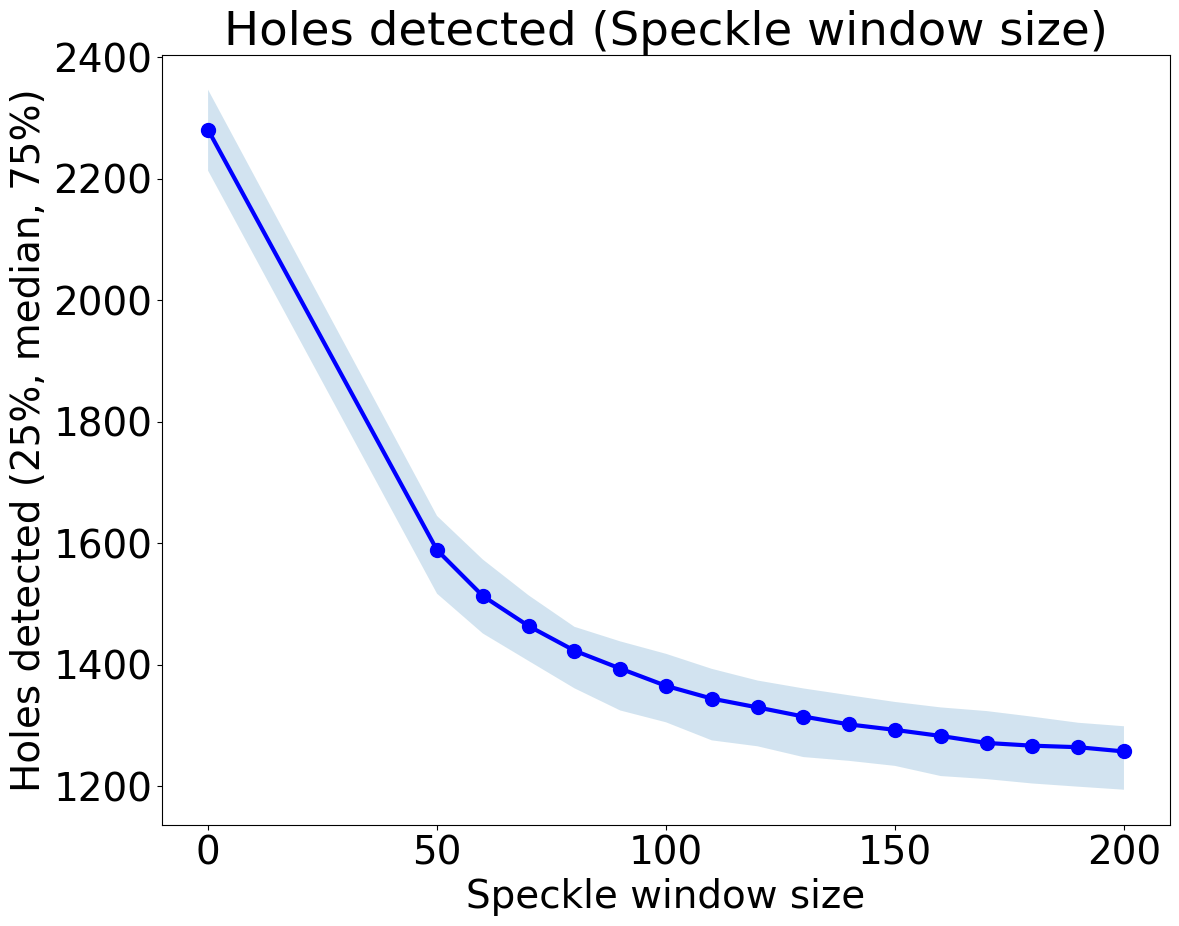

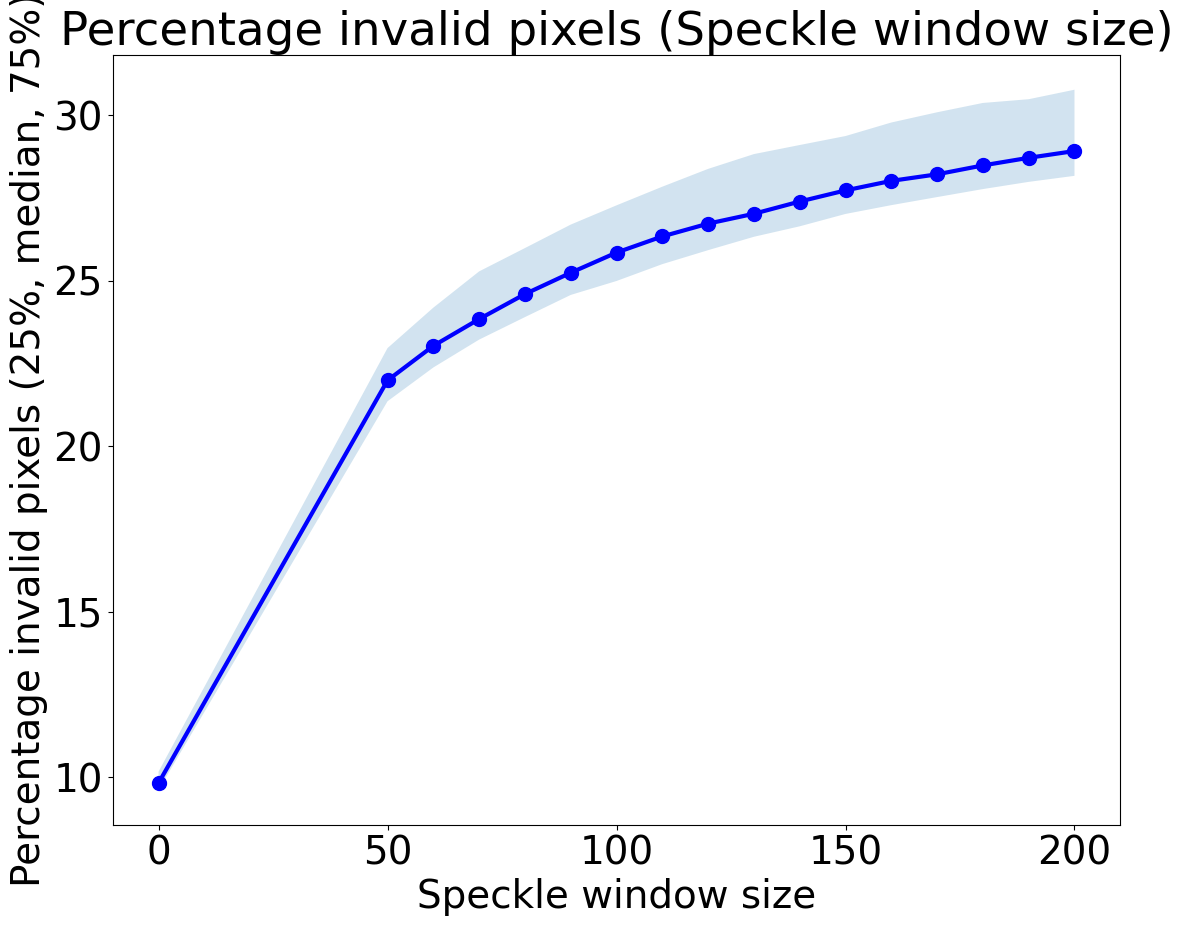

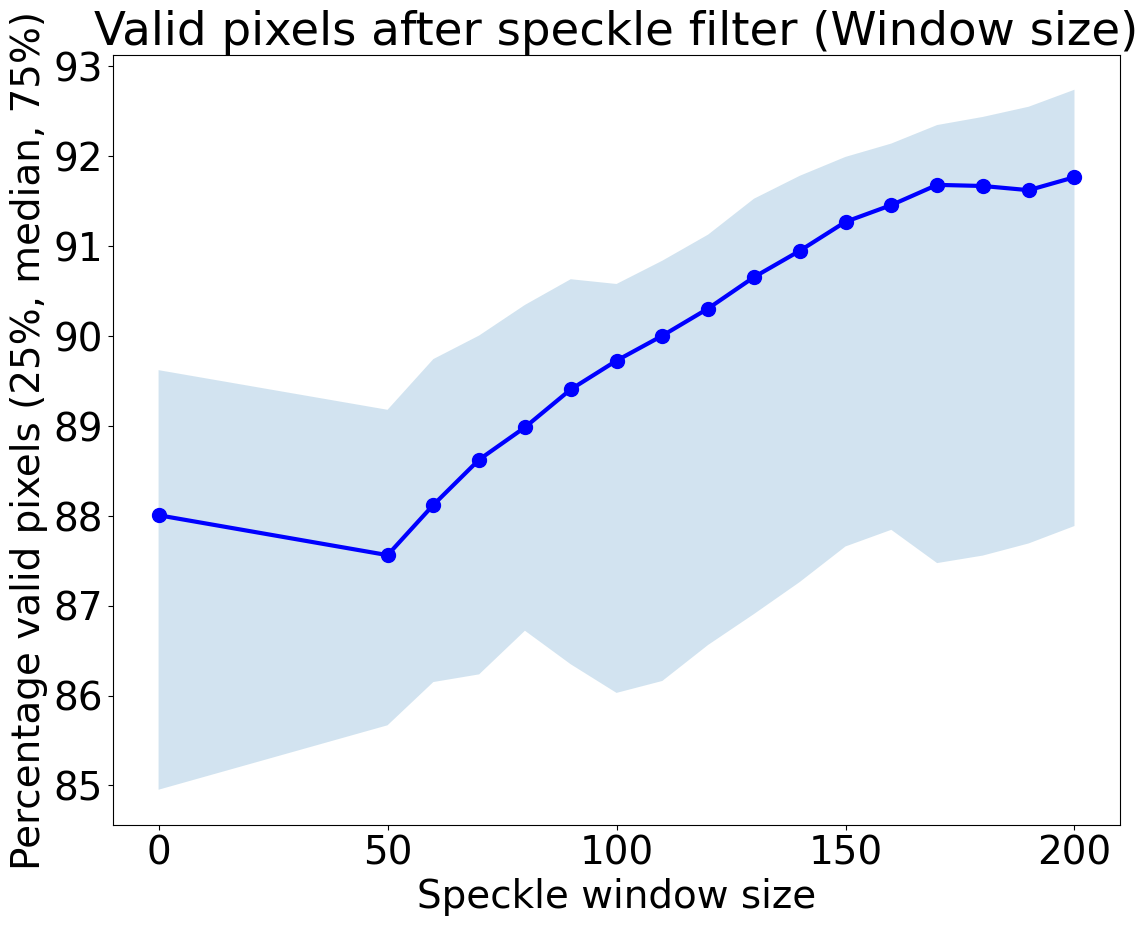

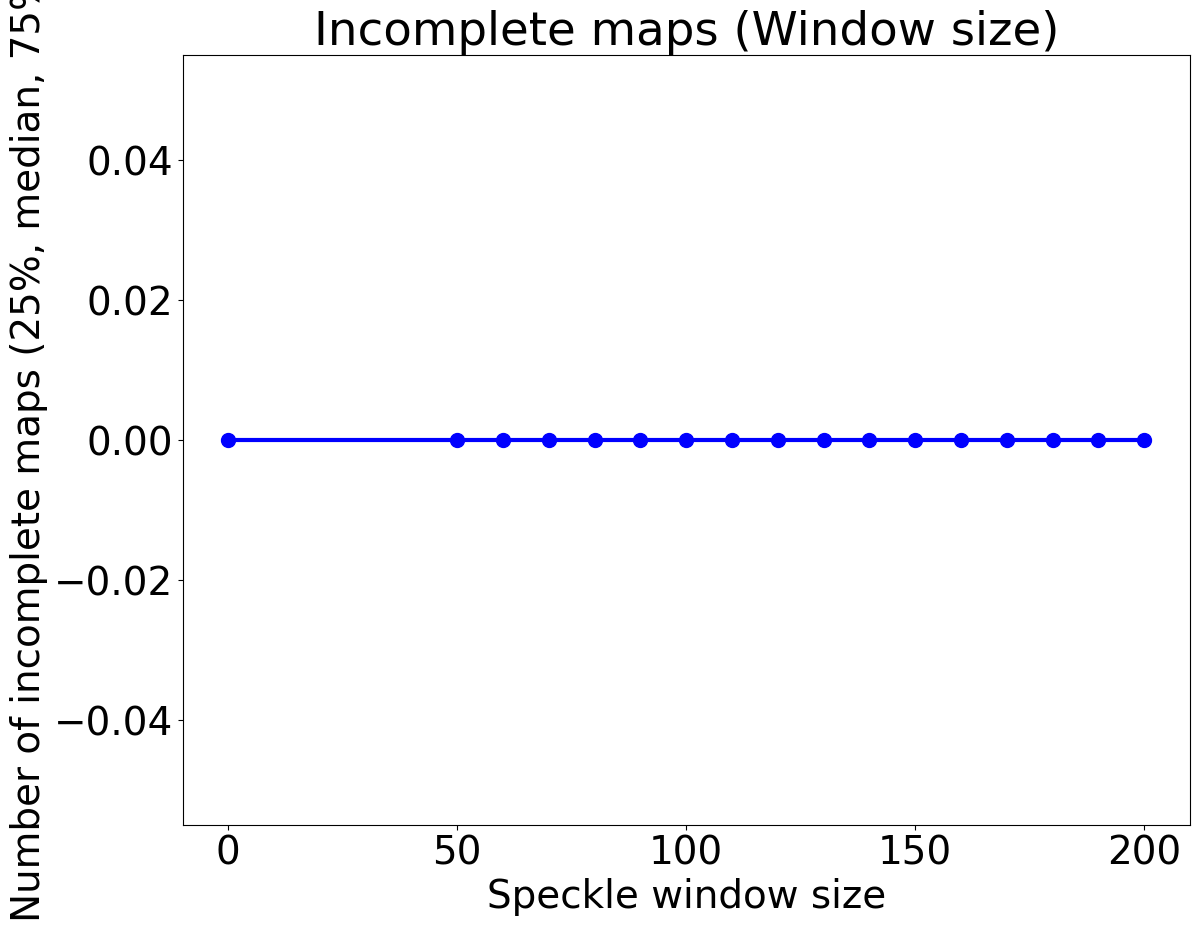

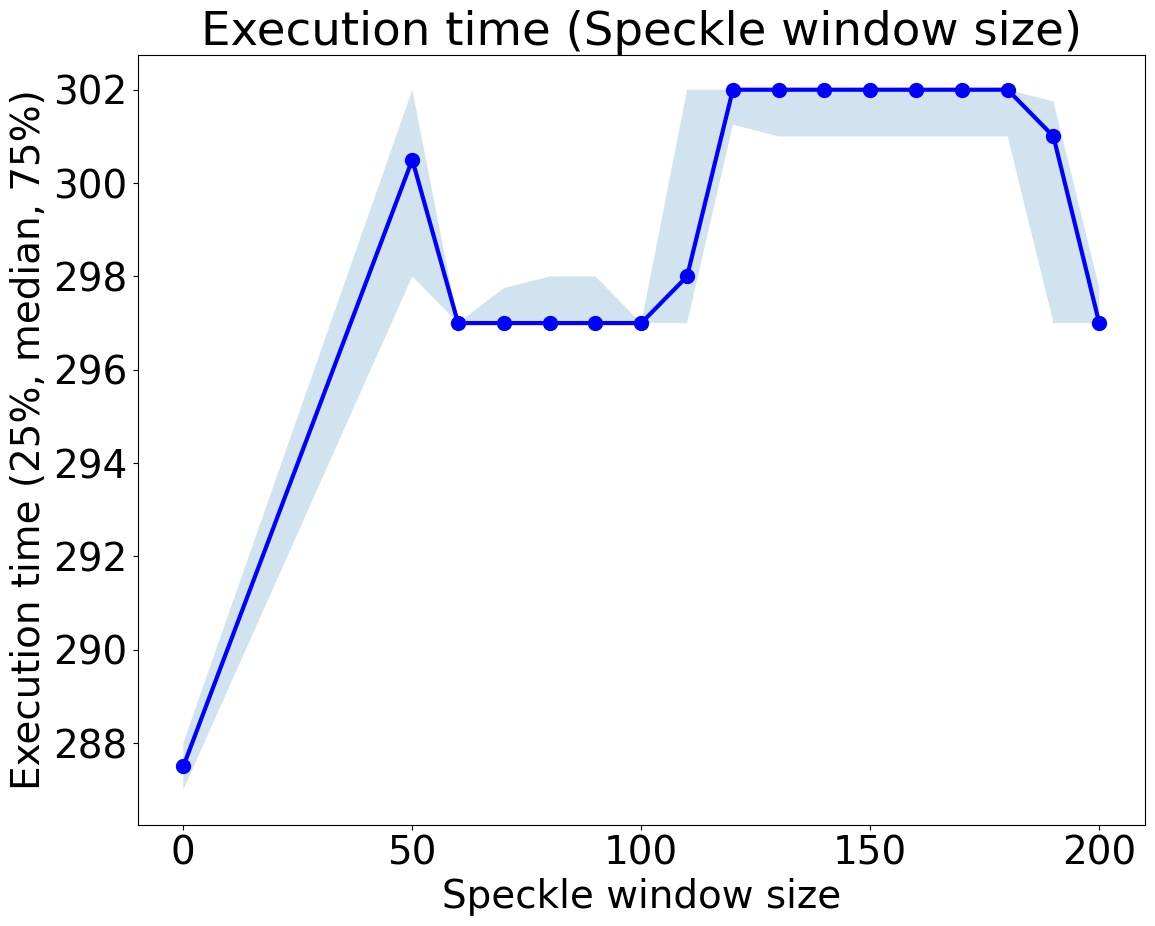

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Speckle window size', 'Holes detected (25%, median, 75%)', "Holes detected (Speckle window size)", True,colors,"../Data/Graphs/Disparity/SpeckleWindowSize/SpeckleWindowSize_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Speckle window size', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (Speckle window size)", True,colors,"../Data/Graphs/Disparity/SpeckleWindowSize/SpeckleWindowSize_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Speckle window size', 'Percentage valid pixels (25%, median, 75%)', "Valid pixels after speckle filter (Window size)", True,colors,"../Data/Graphs/Disparity/SpeckleWindowSize/SpeckleWindowSize_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Speckle window size', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (Window size)", True,colors,"../Data/Graphs/Disparity/SpeckleWindowSize/SpeckleWindowSize_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Speckle window size', 'Execution time (25%, median, 75%)', "Execution time (Speckle window size)", True,colors,"../Data/Graphs/Disparity/SpeckleWindowSize/SpeckleWindowSize_execution_time.png")

Conclusion:
Execution time seems to be in steps with 60-100 and 200 being fastest if not considering no specklefiltering.
Less speckles exist with bigger windows, only 50 performs worse than no window
Number of invalid pixels grow, since speckles are turned into invalid.
There is a drastic decrease in holes, due to areas of disparity map being removed.

A window size of 200 is used based on these results

## Uniqueness ratio (Done)

In [101]:
import csv

# Paths
path = ["../Data/Disparity_settings/uniquenessRatio.csv"]

# Other variables
settings =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

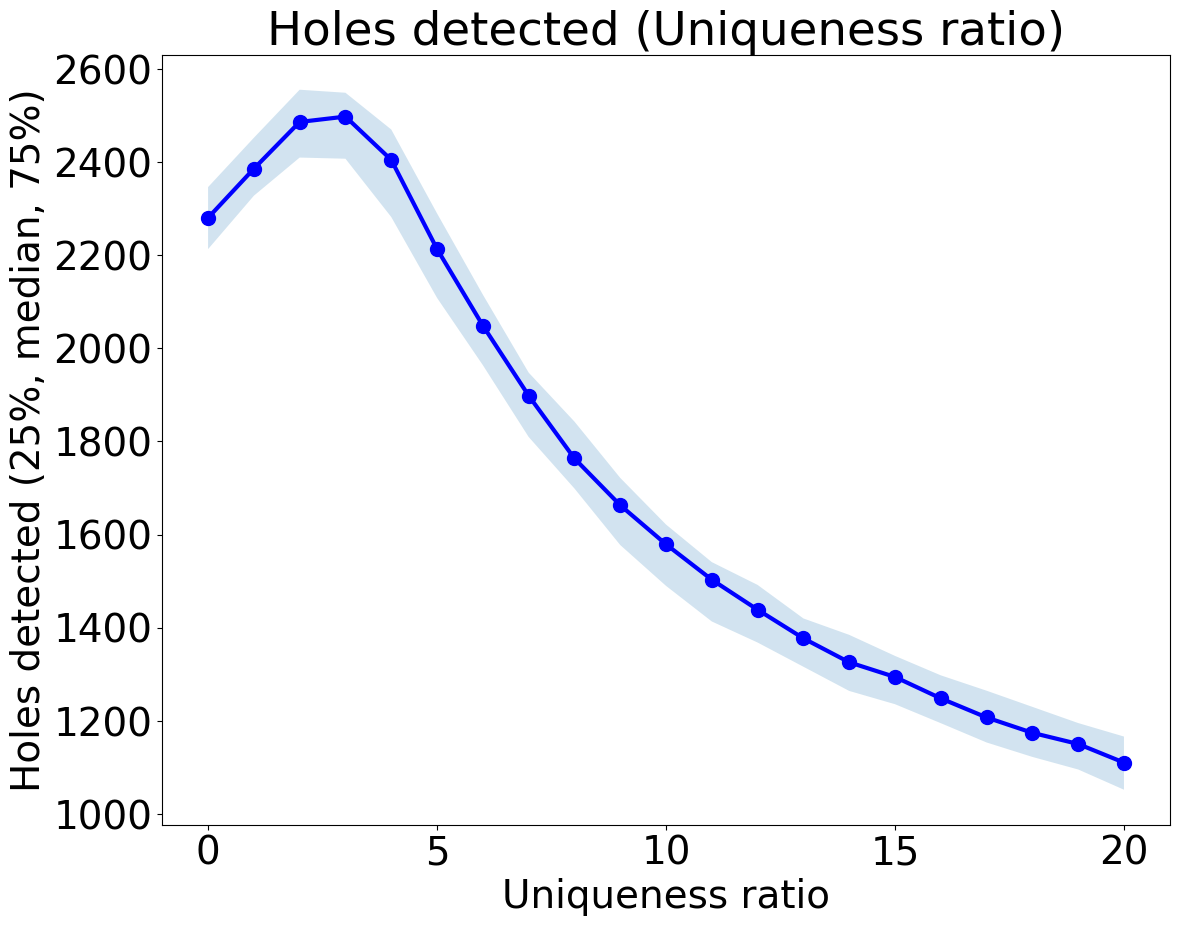

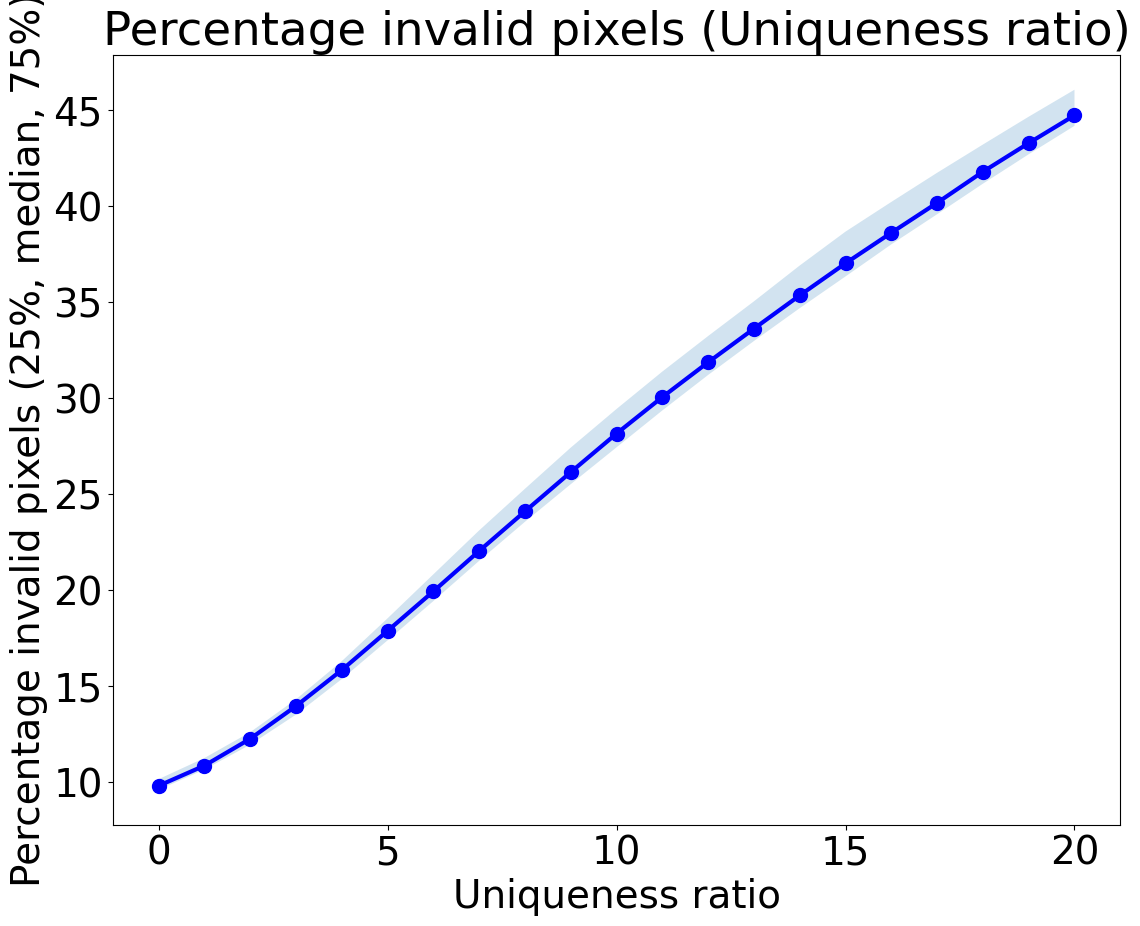

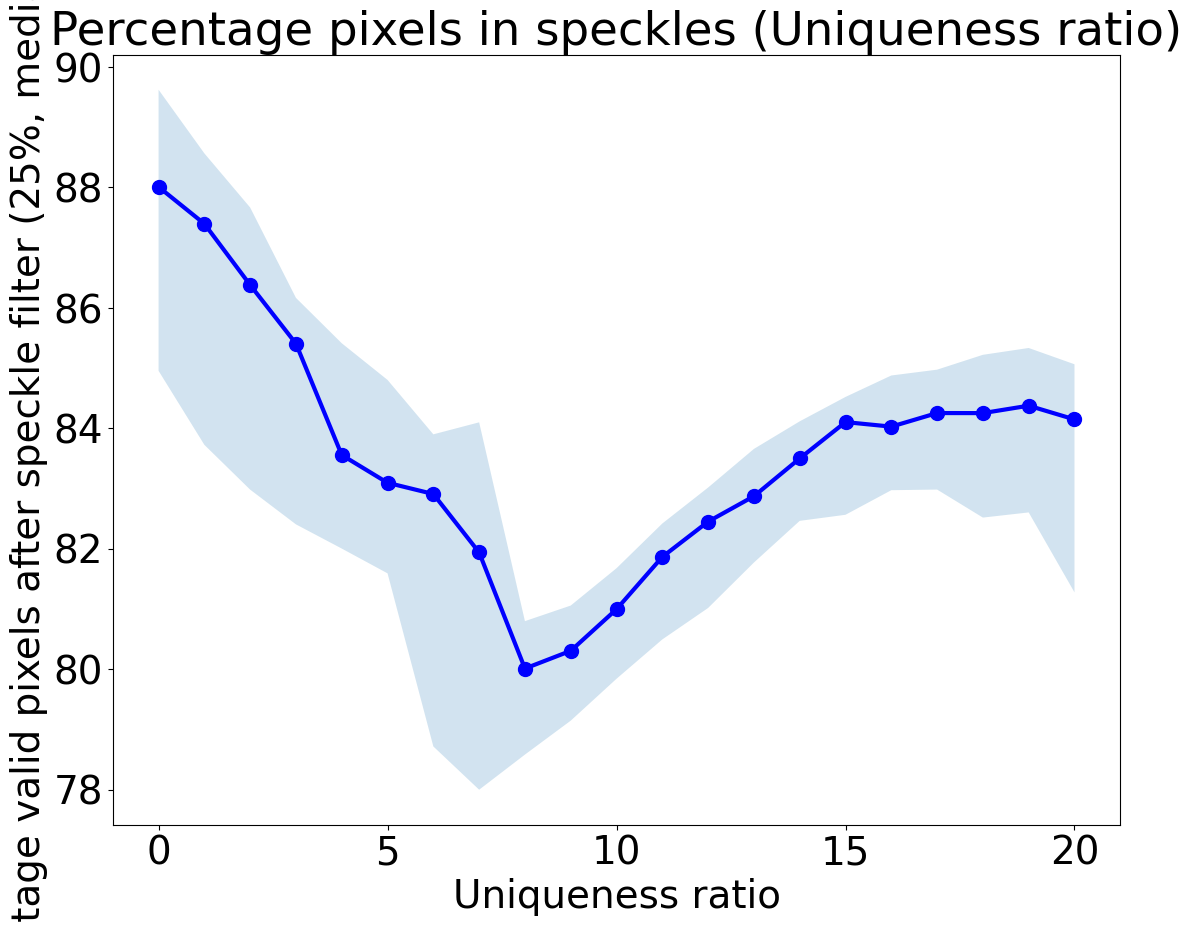

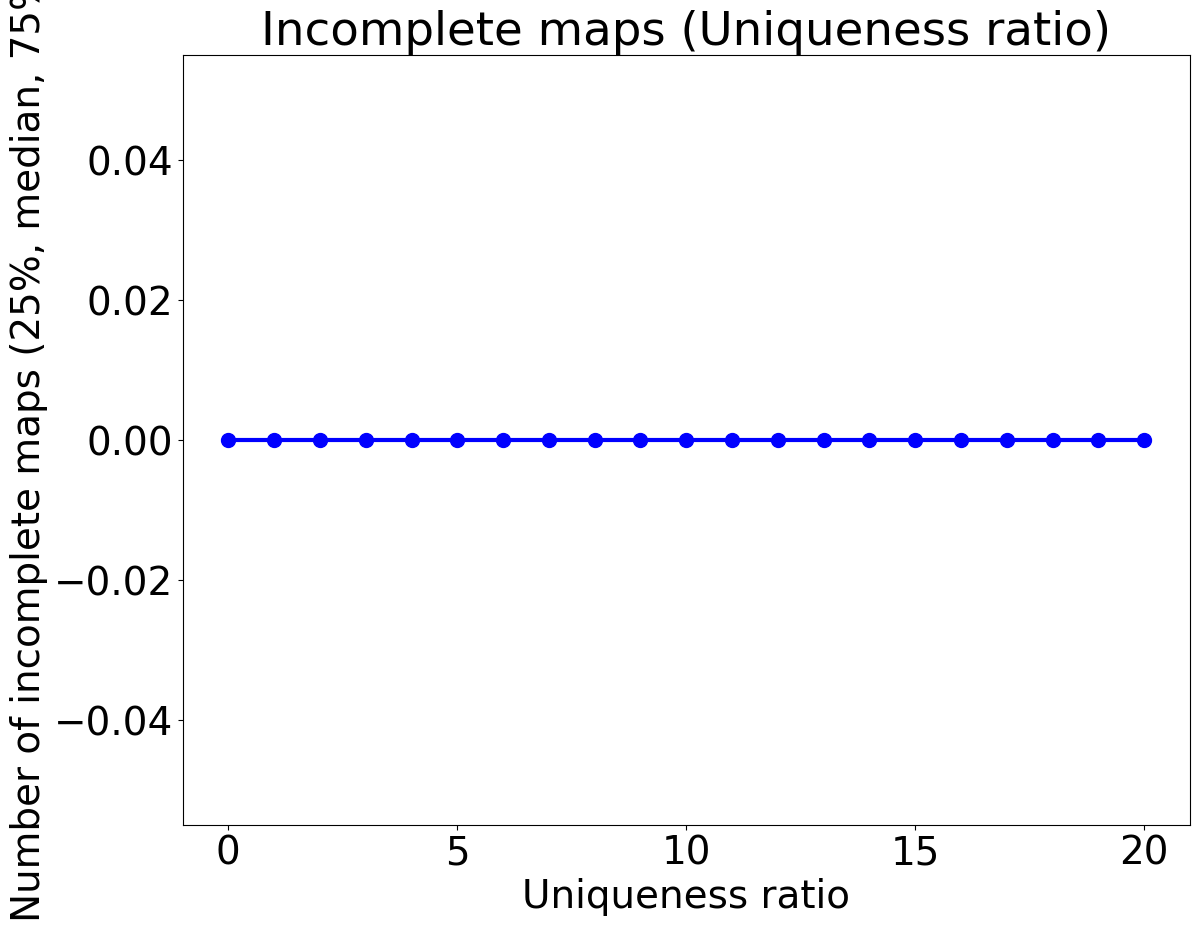

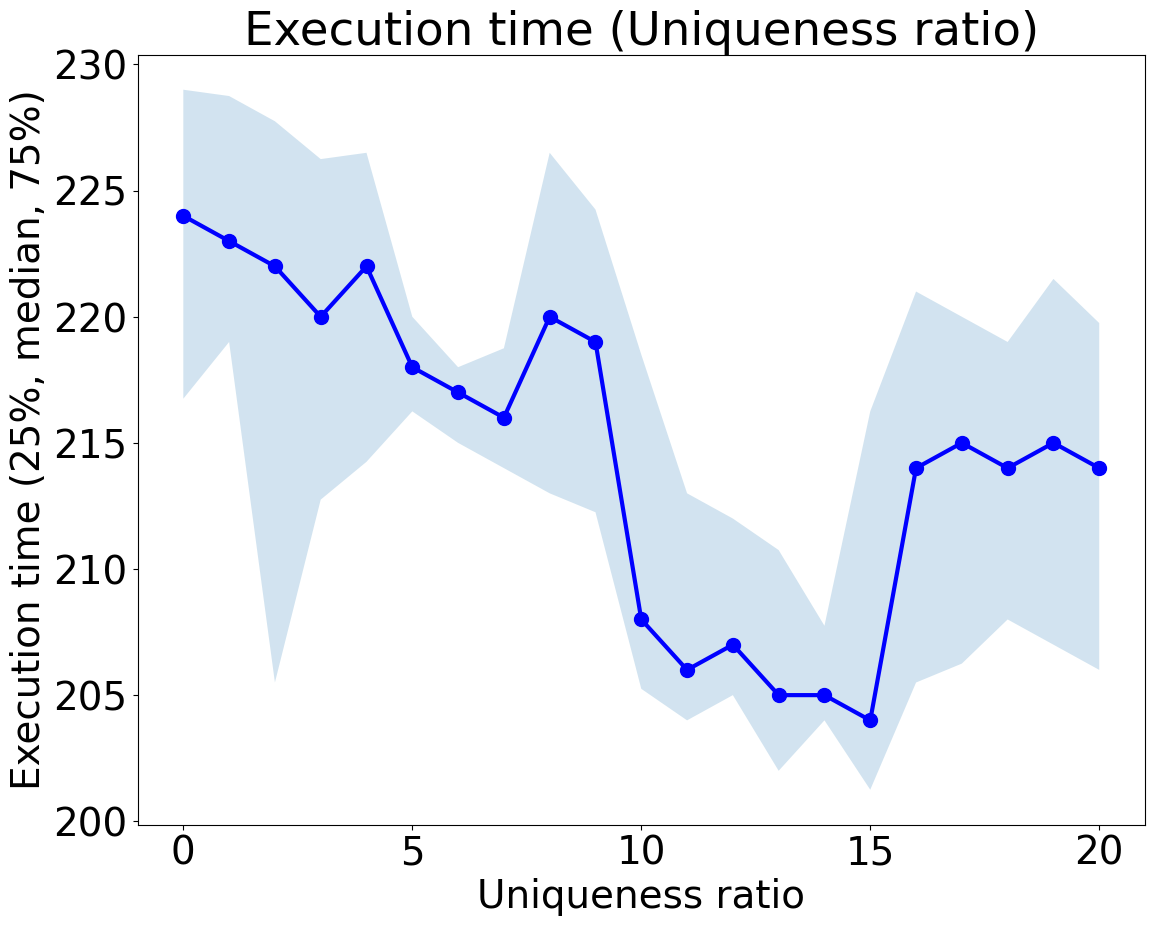

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import statistics 

# Find medians and quantiles
hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

labels = [""]
colors = ['b']

# Plot
line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Uniqueness ratio', 'Holes detected (25%, median, 75%)', "Holes detected (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_holes_detected.png")
line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Uniqueness ratio', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_invalid_percentage.png")
line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Uniqueness ratio', 'Percentage valid pixels after speckle filter (25%, median, 75%)', "Percentage pixels in speckles (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_speckle_percentage.png")
line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Uniqueness ratio', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_incomplete.png")
line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Uniqueness ratio', 'Execution time (25%, median, 75%)', "Execution time (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_execution_time.png")

Conclusion:
Higher pre-filter cap -> less holes.
Higher pre-filter cap -> more invalid pixels.
Most speckles around 7 to 12.
Execution time seems to decrease but in a chaotic fashion

Because of this 15 is chosen

## Mode (Done)

In [106]:
import csv

# Paths
path = ["../Data/Disparity_settings/mode.csv"]

# Other variables
settings = ["SGBM","SGBM_3WAY","HH"]
# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)

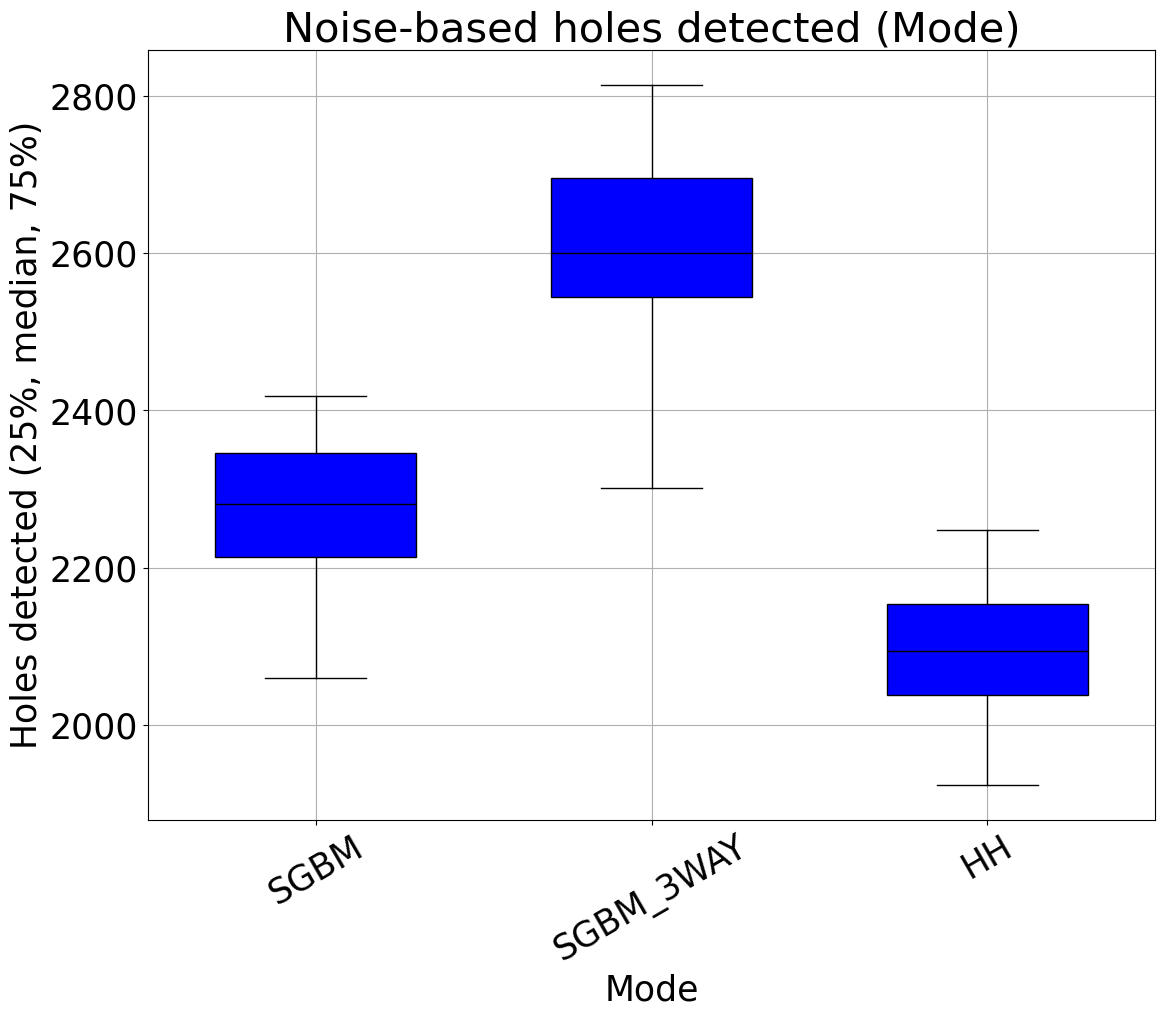

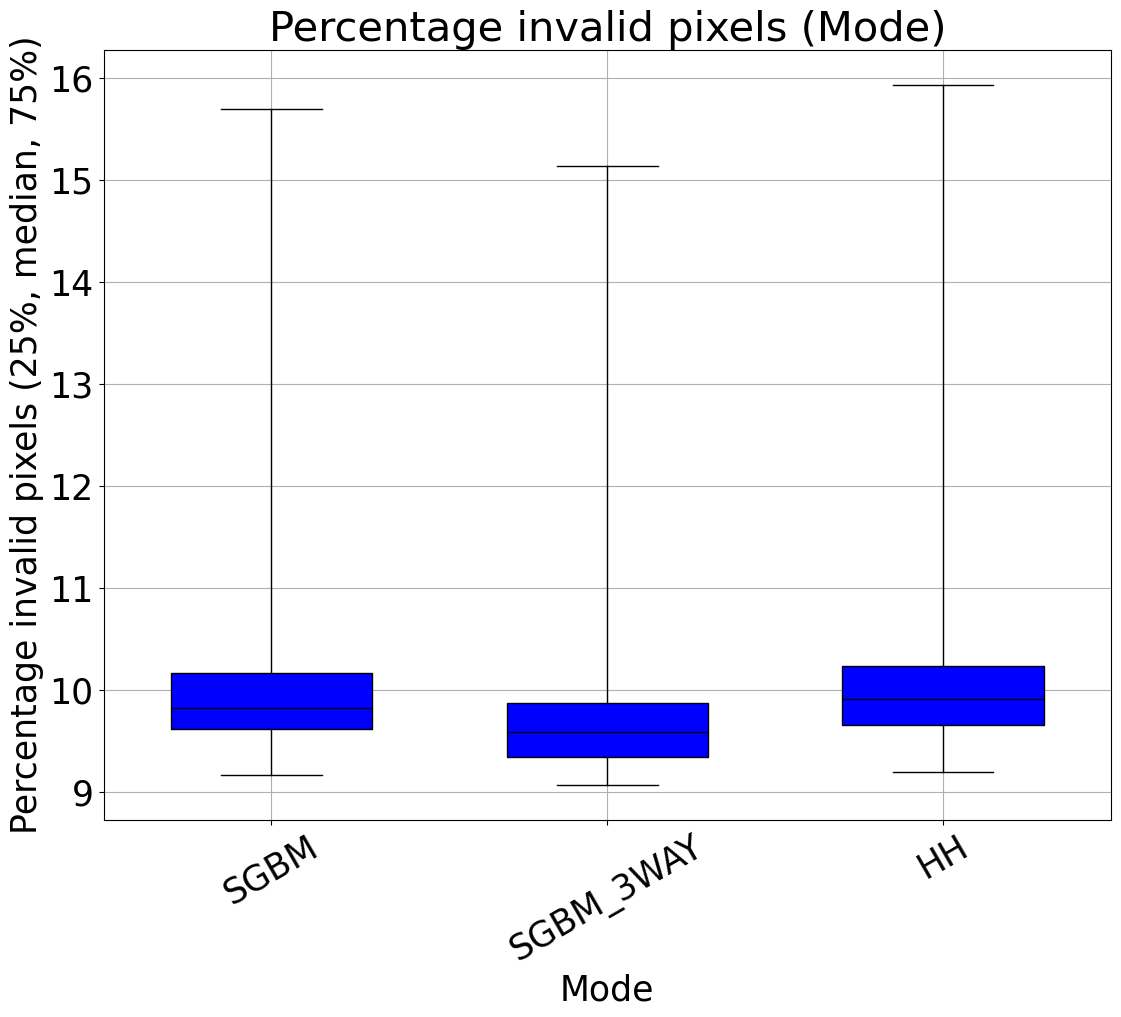

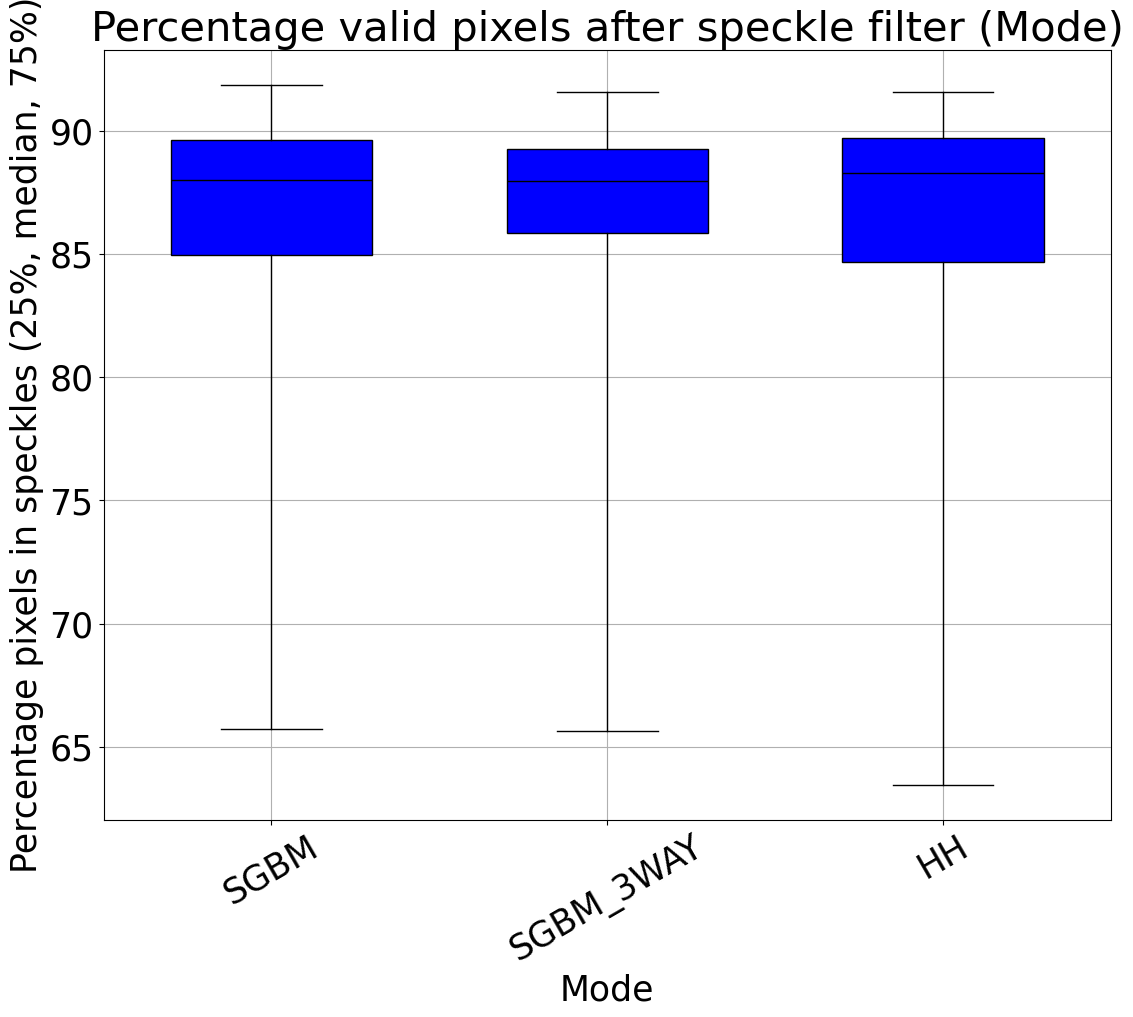

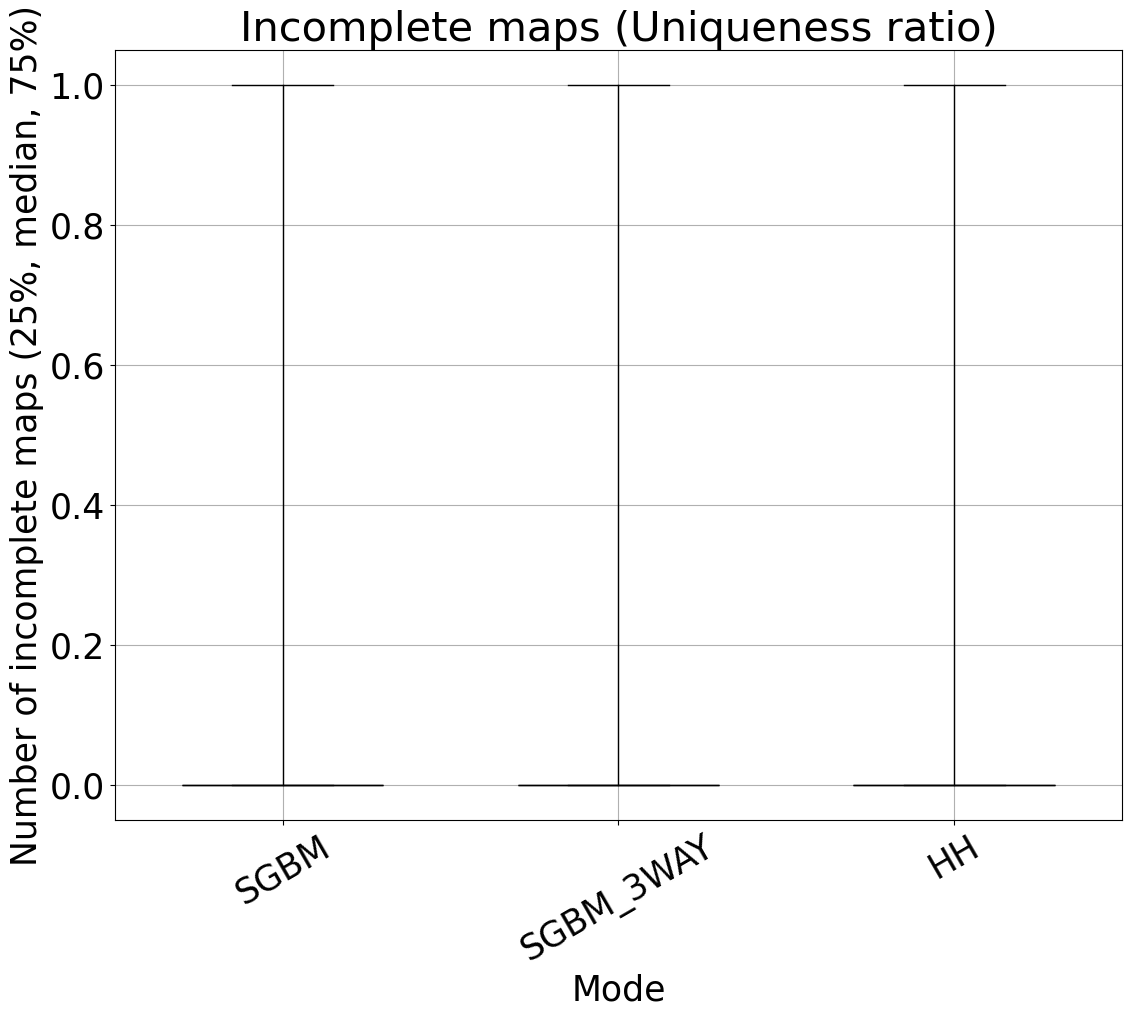

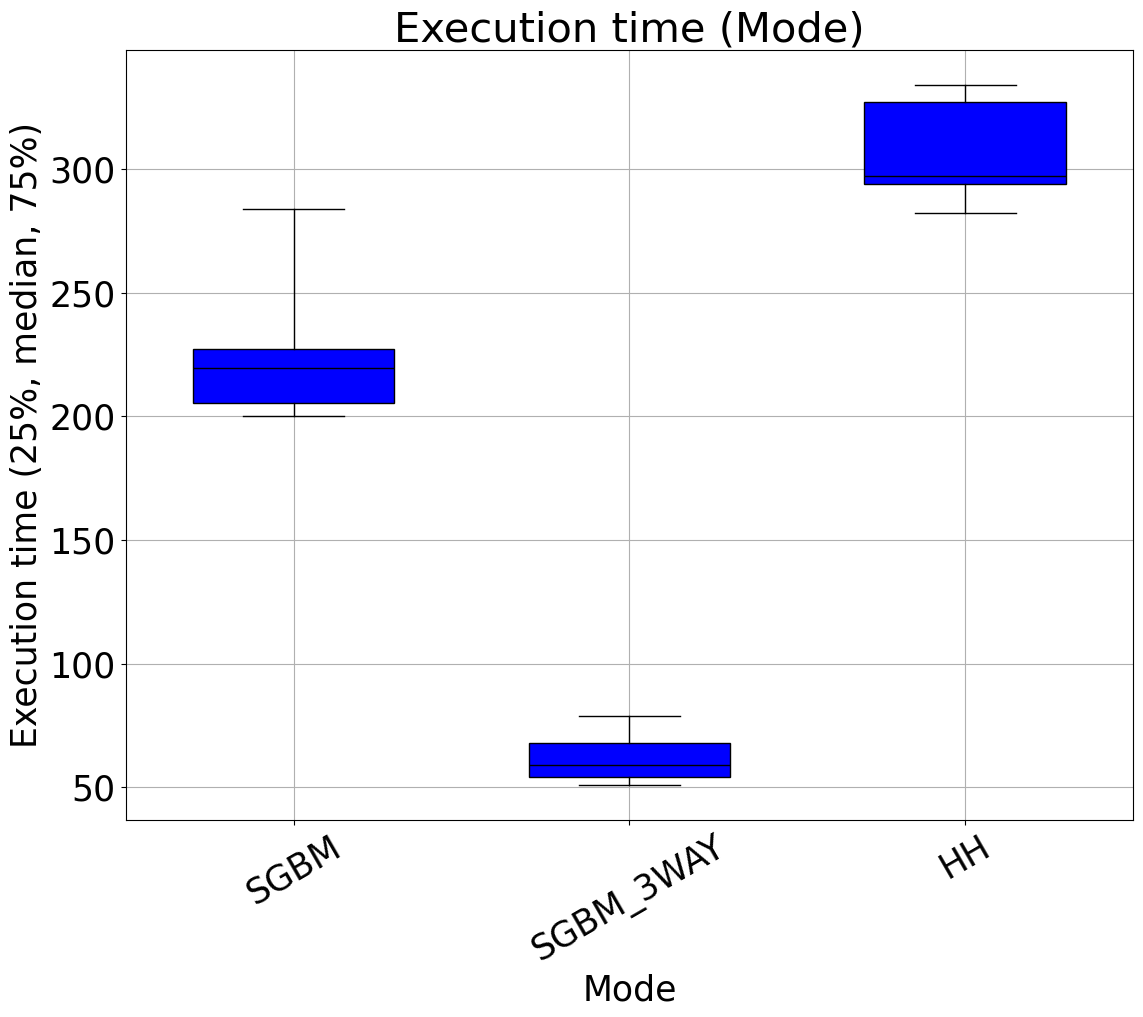

In [107]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import statistics
import seaborn as sns
import pandas as pd


# Show boxplots
colors = ['b']
environments = [""]
show_double_grouped_boxplots(environments,settings, [hole_counts], colors, 'Mode', 'Holes detected (25%, median, 75%)','Noise-based holes detected (Mode)',True,"../Data/Graphs/Disparity/Mode/Mode_holes_detected.png")
show_double_grouped_boxplots(environments,settings, [invalid_percentages], colors, 'Mode', 'Percentage invalid pixels (25%, median, 75%)','Percentage invalid pixels (Mode)',True,"../Data/Graphs/Disparity/Mode/Mode_invalid_percentage.png")
show_double_grouped_boxplots(environments,settings, [speckle_percentages], colors, 'Mode', 'Percentage pixels in speckles (25%, median, 75%)','Percentage valid pixels after speckle filter (Mode)',True,"../Data/Graphs/Disparity/Mode/Mode_speckle_percentage.png")
show_double_grouped_boxplots(environments,settings, [incomplete_count], colors, 'Mode', 'Number of incomplete maps (25%, median, 75%)','Incomplete maps (Uniqueness ratio)',True,"../Data/Graphs/Disparity/Mode/Mode_incomplete.png")
show_double_grouped_boxplots(environments,settings, [execution_times], colors, 'Mode', 'Execution time (25%, median, 75%)','Execution time (Mode)',True,"../Data/Graphs/Disparity/Mode/Mode_execution_time.png")


#show_double_grouped_boxplots(enviroments,diffusivity_settings, time_environments, colors, 'Diffusivity type', 'Time taken [ms]','AKAZE: Boxplot of time spent (Diffusivity type)',True,"../Data/Graphs/AKAZE/AKAZE_box_time_diffusivity_type.png")
#show_double_grouped_boxplots(enviroments,diffusivity_settings, percentage_environments, colors, 'Diffusivity type', 'Percentage features in area of interest','AKAZE: Features in area of interest (Diffusivity type)',True,"../Data/Graphs/AKAZE/AKAZE_box_percentage_diffusivity_type.png")


# Find medians and quantiles
#hole_medians, hole_25, hole_75 = find_median_and_quartiles([hole_counts])
#invalid_medians, invalid_25, invalid_75 = find_median_and_quartiles([invalid_percentages])
#speckle_medians, speckle_25, speckle_75 = find_median_and_quartiles([speckle_percentages])
#incomplete_medians, incomplete_25, incomplete_75 = find_median_and_quartiles([incomplete_count])
#time_medians,time_25,time_75 = find_median_and_quartiles([execution_times])

#labels = [""]
#colors = ['b']

# Plot
#line_graph_median_and_quantiles(settings,hole_medians,hole_25,hole_75,labels, False, 'Uniqueness ratio', 'Holes detected (25%, median, 75%)', "Holes detected (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_holes_detected.png")
#line_graph_median_and_quantiles(settings,invalid_medians,invalid_25,invalid_75,labels, False, 'Uniqueness ratio', 'Percentage invalid pixels (25%, median, 75%)', "Percentage invalid pixels (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_invalid_percentage.png")
#line_graph_median_and_quantiles(settings,speckle_medians,speckle_25,speckle_75,labels, False, 'Uniqueness ratio', 'Percentage pixels in speckles (25%, median, 75%)', "Percentage pixels in speckles (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_speckle_percentage.png")
#line_graph_median_and_quantiles(settings,incomplete_medians,incomplete_25,incomplete_75,labels, False, 'Uniqueness ratio', 'Number of incomplete maps (25%, median, 75%)', "Incomplete maps (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_incomplete.png")
#line_graph_median_and_quantiles(settings,time_medians,time_25,time_75,labels, False, 'Uniqueness ratio', 'Execution time (25%, median, 75%)', "Execution time (Uniqueness ratio)", True,colors,"../Data/Graphs/Disparity/UniquenessRatio/UniquenessRatio_execution_time.png")

Conclusion:
HH makes least holes
Similar invalid pixels with HH loosing and 3Way winning.
3Way best in terms of least speckles.
HH slowest, 3Way very fast, normal is middleground.

3Way is chosen

## Final

In [112]:
import csv

# Paths
path = ["../Data/Disparity_settings/best.csv"]

# Other variables
settings = ["Chosen setup"]
# Extract desired information
hole_counts, invalid_percentages, speckle_percentages, incomplete_count, execution_times = read_disparity_results(path)
invalid_percentages.append(speckle_percentages[0])

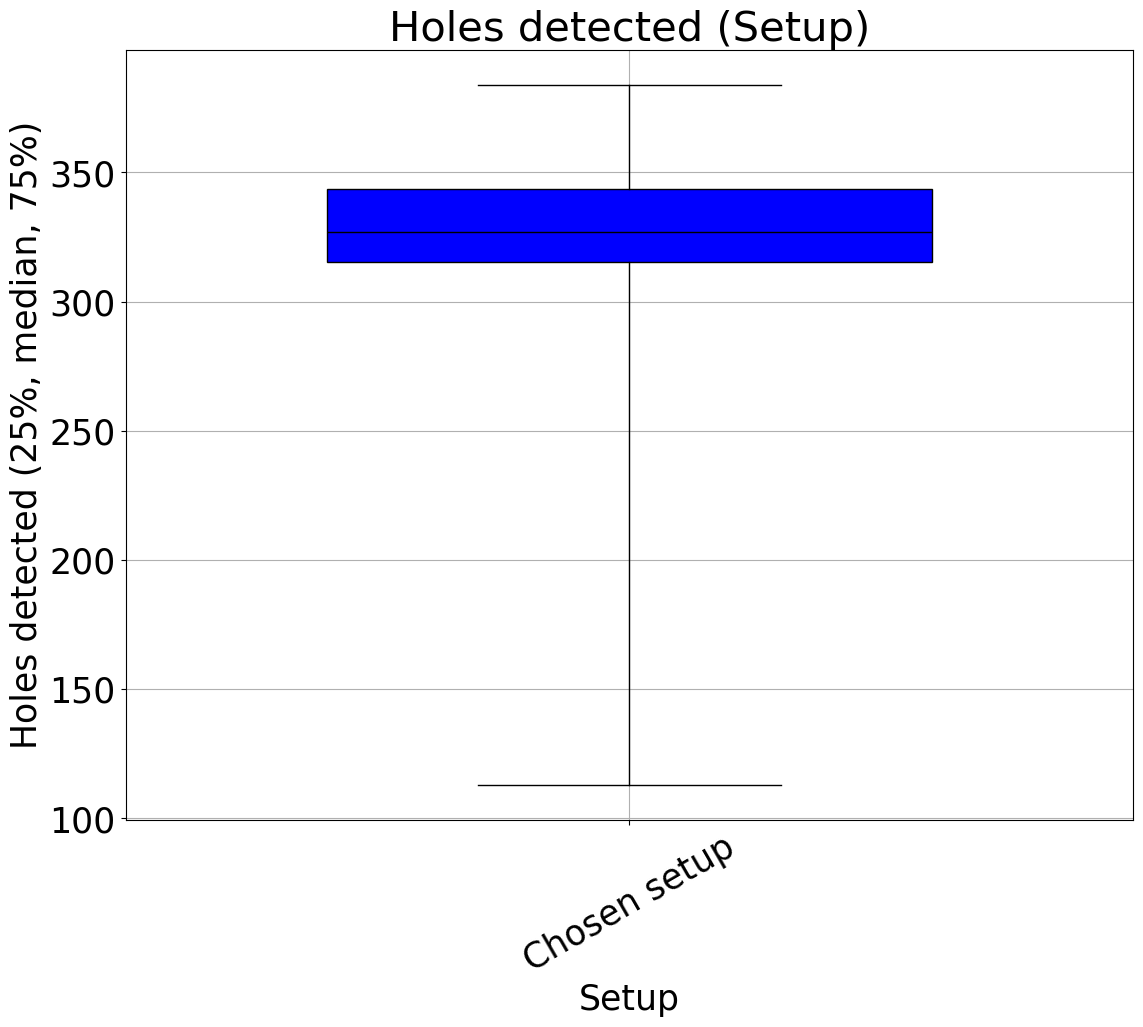

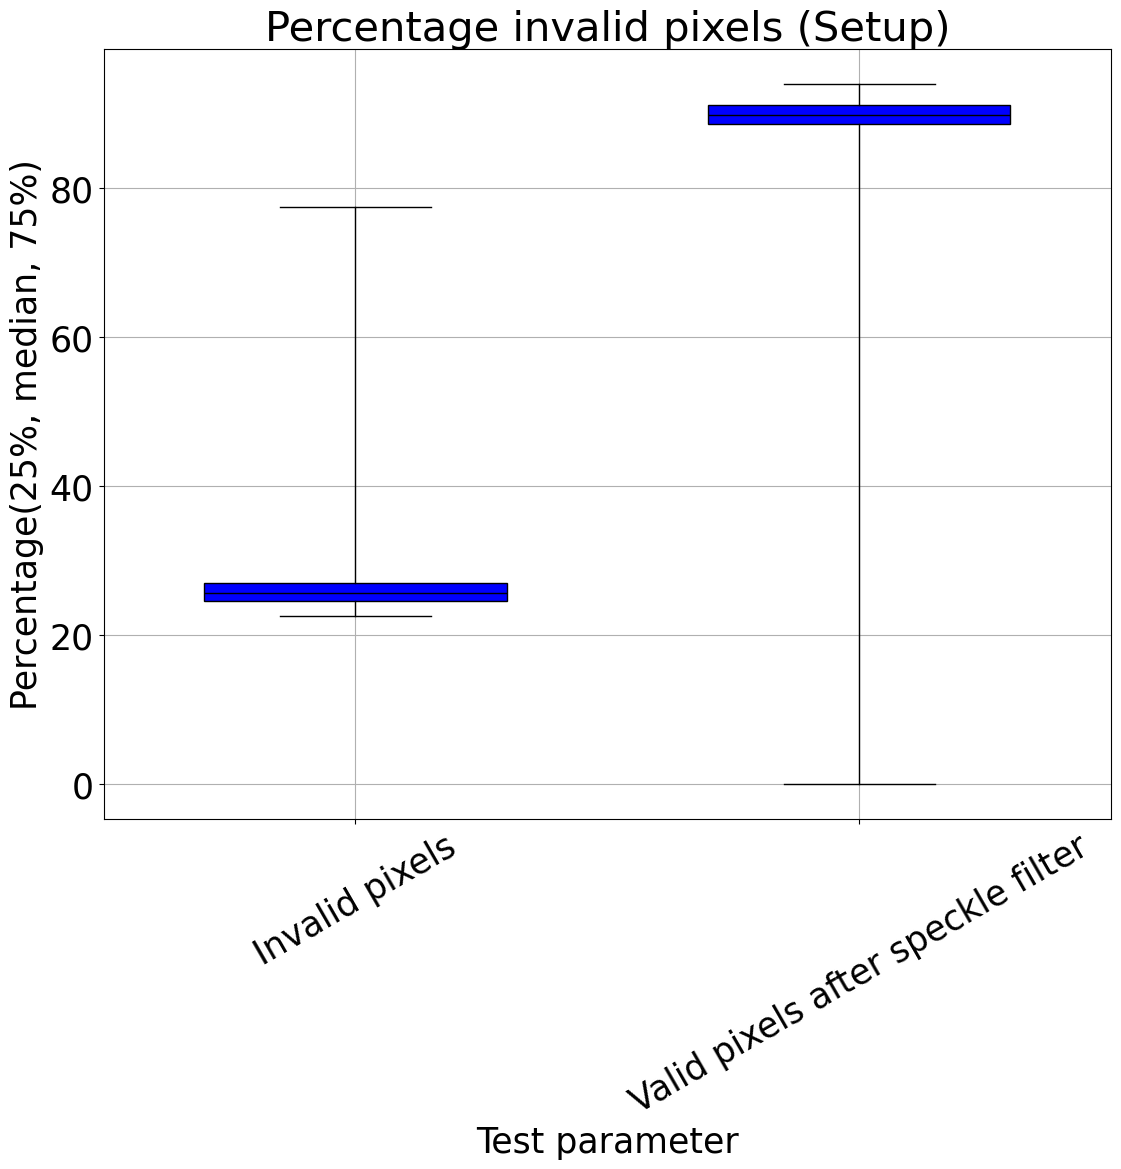

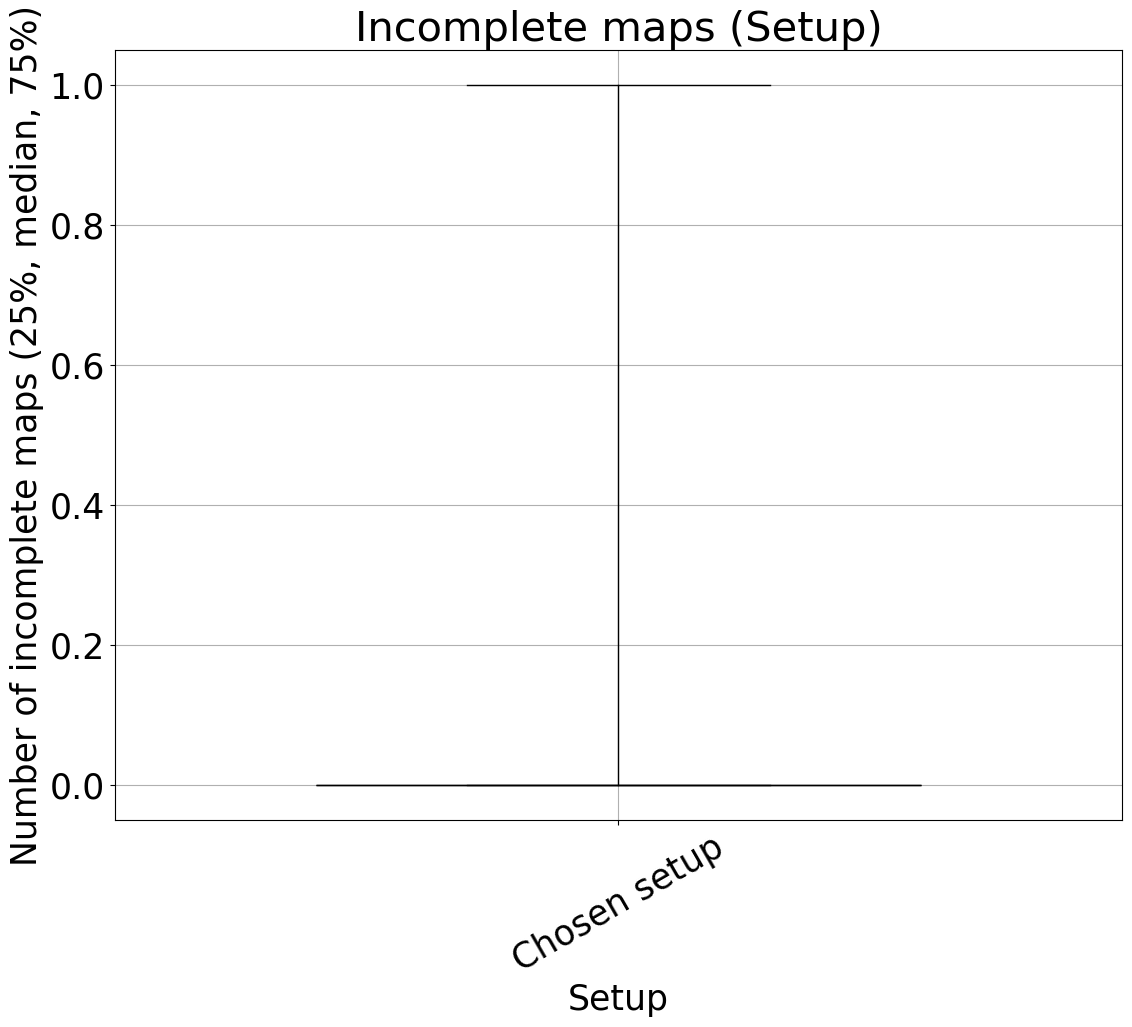

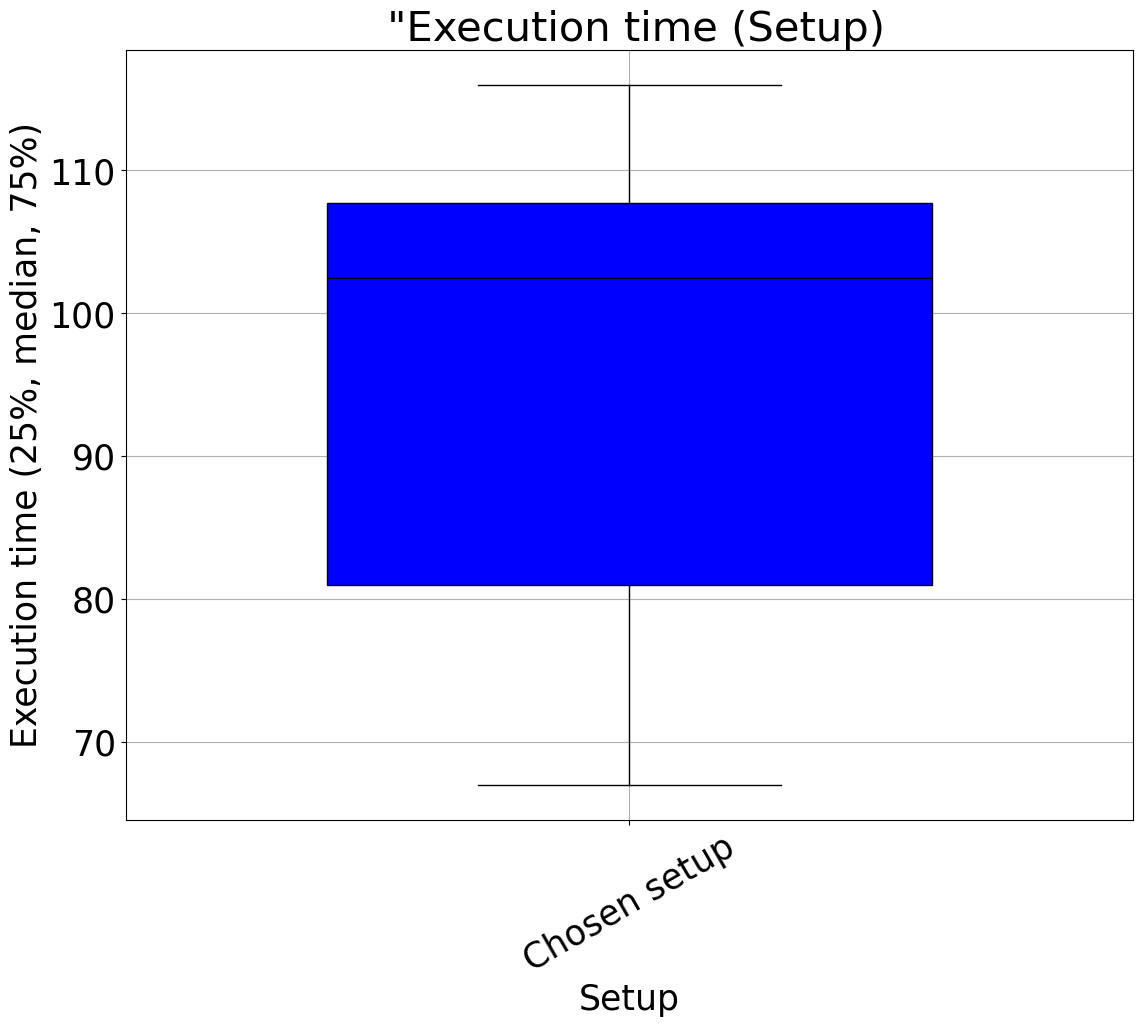

In [113]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import statistics
import seaborn as sns
import pandas as pd


# Show boxplots
colors = ['b']
environments = [""]
combine_settings = ["Invalid pixels", "Valid pixels after speckle filter"]
show_double_grouped_boxplots(environments,settings, [hole_counts], colors, 'Setup', 'Holes detected (25%, median, 75%)','Holes detected (Setup)',True,"../Data/Graphs/Disparity/Best/Best_holes_detected.png")
show_double_grouped_boxplots(environments,combine_settings, [invalid_percentages], colors, 'Test parameter', 'Percentage(25%, median, 75%)','Percentage invalid pixels (Setup)',True,"../Data/Graphs/Disparity/Best/Best_invalid_percentage.png")
#show_double_grouped_boxplots(environments,settings, [speckle_percentages], colors, 'Setup', 'Percentage pixels in speckles (25%, median, 75%)','Percentage valid pixels after speckle filter (Setup)',True,"../Data/Graphs/Disparity/Best/Best_speckle_percentage.png")
show_double_grouped_boxplots(environments,settings, [incomplete_count], colors, 'Setup', 'Number of incomplete maps (25%, median, 75%)','Incomplete maps (Setup)',True,"../Data/Graphs/Disparity/Best/Best_incomplete.png")
show_double_grouped_boxplots(environments,settings, [execution_times], colors, 'Setup', 'Execution time (25%, median, 75%)',' "Execution time (Setup)',True,"../Data/Graphs/Disparity/Best/Best_execution_time.png")


Conclusion:

Seems prety good

# Postprocessing

In [129]:
import csv

# Paths
paths_single = ["../Data/Disparity_postprocess/None.csv","../Data/Disparity_postprocess/Consistensy.csv", "../Data/Disparity_postprocess/Speckle.csv","../Data/Disparity_postprocess/median.csv","../Data/Disparity_postprocess/Weighted_median.csv","../Data/Disparity_postprocess/billateral.csv","../Data/Disparity_postprocess/fast_billateral.csv","../Data/Disparity_postprocess/wls.csv","../Data/Disparity_postprocess/fill.csv","../Data/Disparity_postprocess/fill_hoz.csv", "../Data/Disparity_postprocess/inpaint.csv"]
paths_combined = [ "../Data/Disparity_postprocess/Consistensy_weighted_median.csv", "../Data/Disparity_postprocess/Consistensy_speckle.csv", "../Data/Disparity_postprocess/Weighted_median_speckle.csv","../Data/Disparity_postprocess/All.csv"]

# Other variables
settings_single = ["None", "Consistensy check", "Speckle filter", "Median filter", "Weighted median filter", "Billateral filter", "Fast billateral solver", "WLS filter", "Proximity filling", "Horizontal filling", "Inpainting"]
settings_combined = ["Consistensy and weighted median", "Consistensy and speckle", "Weighted median and speckle", "All"]

# Extract desired information
single_hole_counts = []
single_invalid_percentages = []
single_incomplete_count = []
single_consistensy_level = []
single_execution_time = []

for i in range(len(paths_single)):
    temp_hole_counts, temp_invalid_percentages, temp_incomplete_count, temp_consistensy_level,temp_execution_times = read_disparity_results([paths_single[i]])
    single_hole_counts.append(temp_hole_counts[0])
    single_invalid_percentages.append(temp_invalid_percentages[0])
    single_incomplete_count.append(temp_incomplete_count[0])
    single_consistensy_level.append(temp_consistensy_level[0])
    single_execution_time.append(temp_execution_times[0])


combined_hole_counts = []
combined_invalid_percentages = []
combined_incomplete_count = []
combined_consistensy_level = []
combined_execution_time = []

for i in range(len(paths_combined)):
    temp_hole_counts, temp_invalid_percentages, temp_incomplete_count, temp_consistensy_level,temp_execution_times = read_disparity_results([paths_combined[i]])
    combined_hole_counts.append(temp_hole_counts[0])
    combined_invalid_percentages.append(temp_invalid_percentages[0])
    combined_incomplete_count.append(temp_incomplete_count[0])
    combined_consistensy_level.append(temp_consistensy_level[0])
    combined_execution_time.append(temp_execution_times[0])

None
Quantiles: 
[315.25 327.   343.75]
Consistensy check
Quantiles: 
[328.25 341.   356.  ]
Speckle filter
Quantiles: 
[267.5  286.   300.75]
Median filter
Quantiles: 
[5. 6. 7.]
Weighted median filter
Quantiles: 
[14.   18.   20.75]
Billateral filter
Quantiles: 
[6.   7.   8.75]
Fast billateral solver
Quantiles: 
[26.25 30.   36.5 ]
WLS filter
Quantiles: 
[0. 0. 0.]
Proximity filling
Quantiles: 
[5.25 6.   8.  ]
Horizontal filling
Quantiles: 
[5.   6.   7.75]


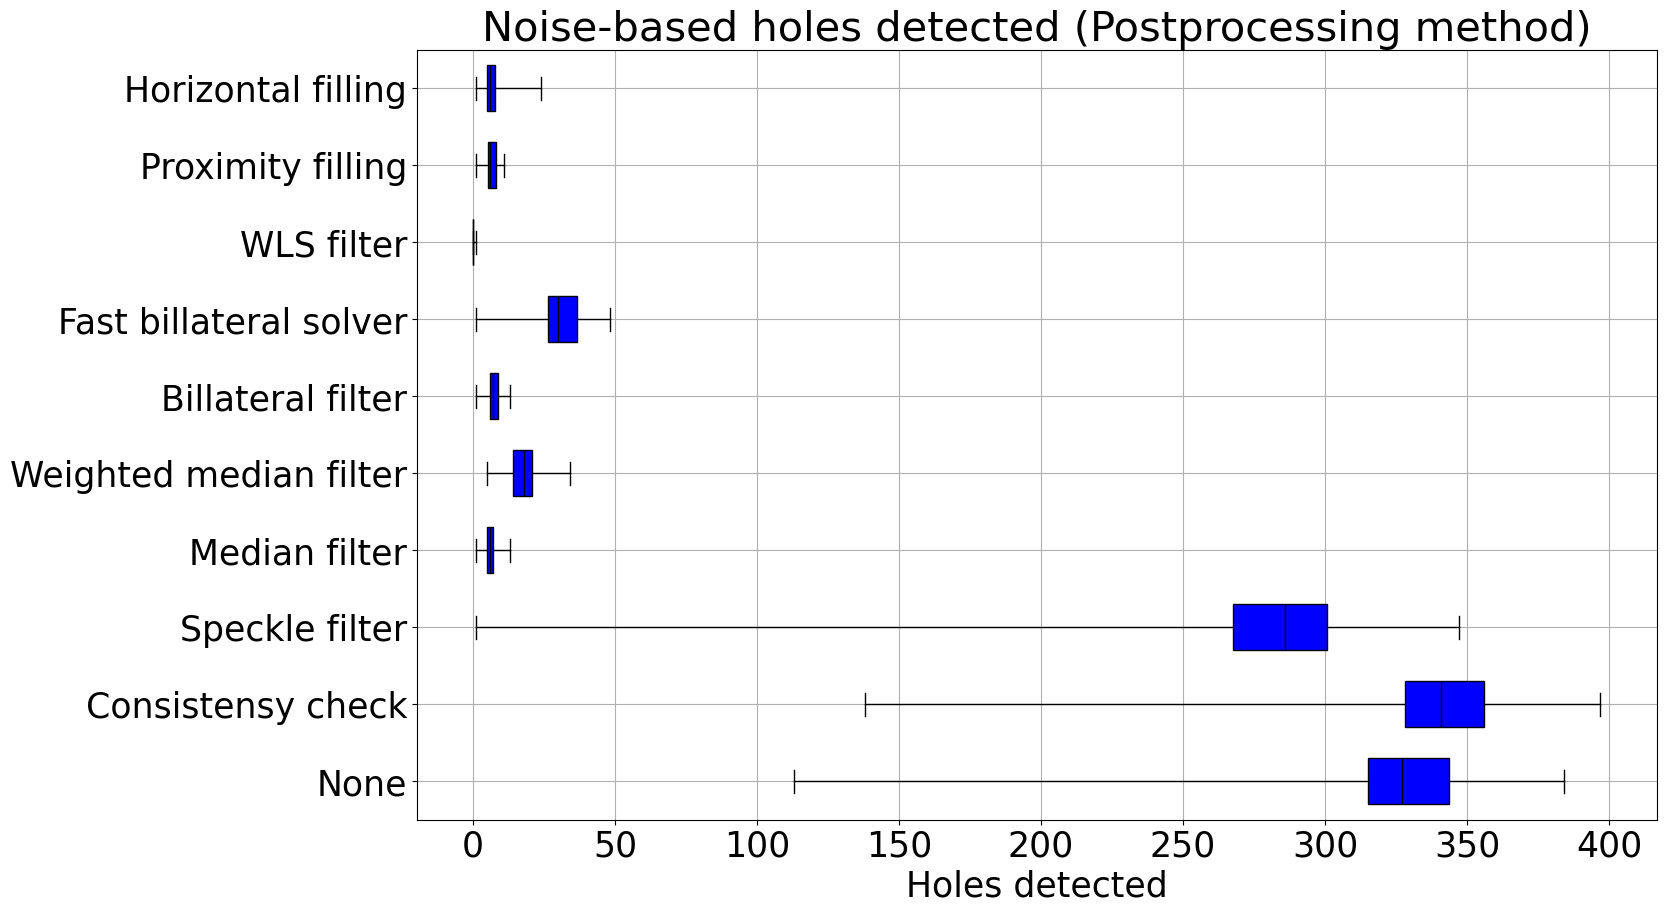

None
Quantiles: 
[26.35725  27.1439   28.830425]
Consistensy check
Quantiles: 
[26.454975 27.27345  28.943225]
Speckle filter
Quantiles: 
[33.65525 34.12125 35.93875]
Median filter
Quantiles: 
[31.434875 31.97925  33.40375 ]
Weighted median filter
Quantiles: 
[23.662575 24.8899   25.914725]
Billateral filter
Quantiles: 
[24.130725 24.98435  26.21335 ]
Fast billateral solver
Quantiles: 
[12.186775 13.5368   14.271175]
WLS filter
Quantiles: 
[0. 0. 0.]
Proximity filling
Quantiles: 
[18.406    19.34515  20.721575]
Horizontal filling
Quantiles: 
[28.60645  29.5412   30.584375]


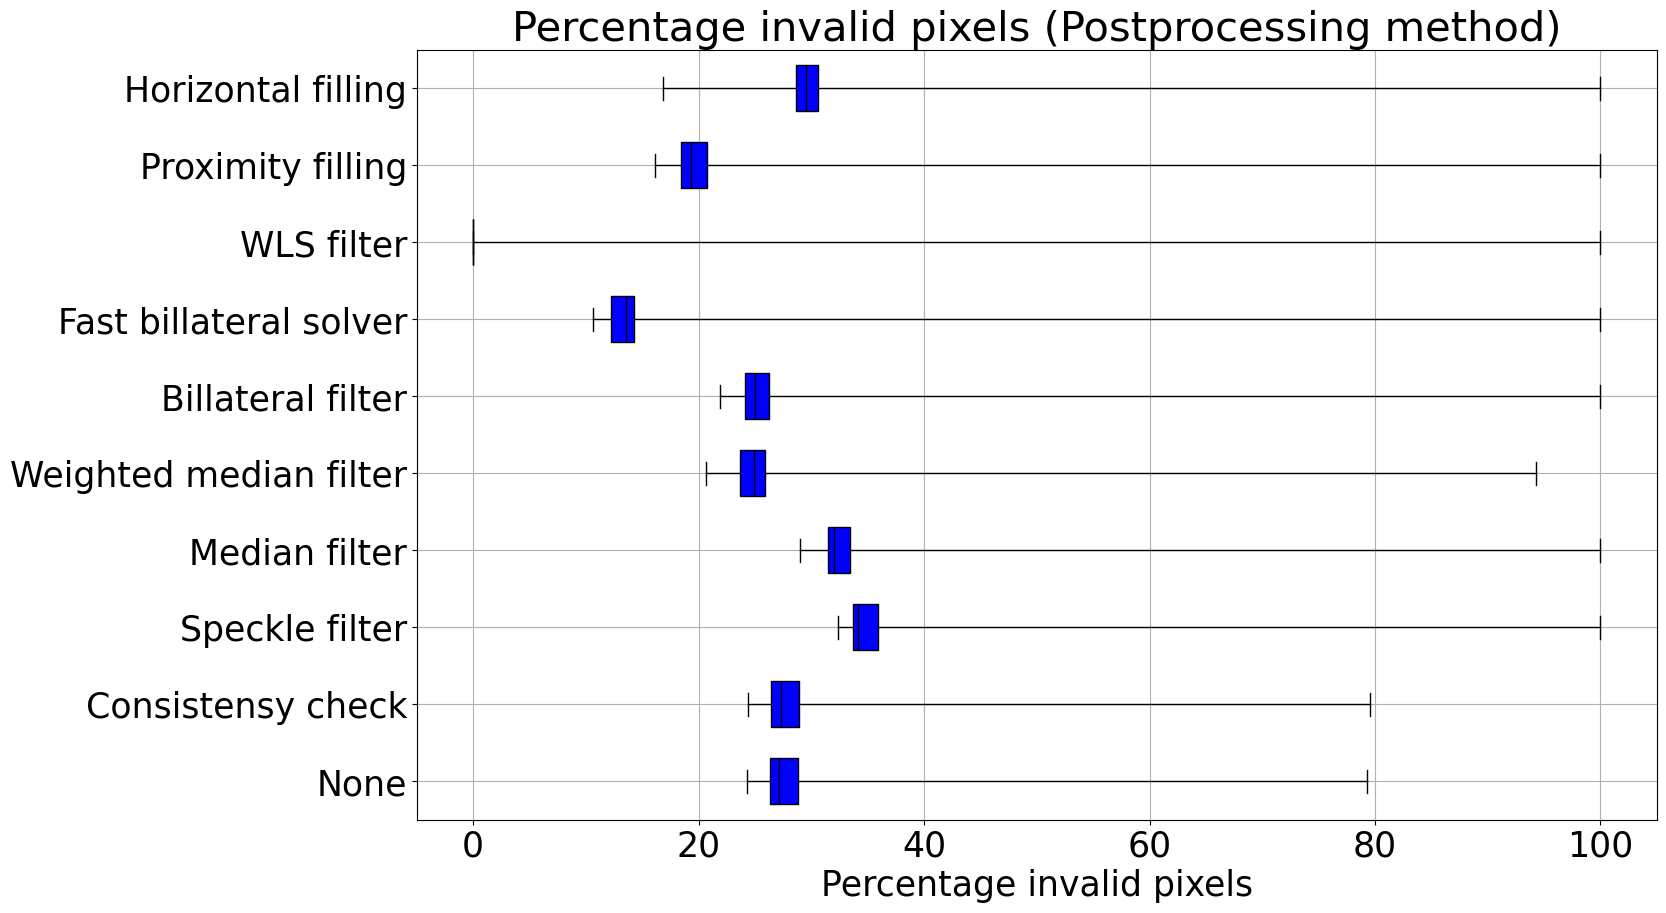

Consistensy check
Quantiles: 
[ 83.5  96.5 101.5]
Speckle filter
Quantiles: 
[7. 7. 7.]
Median filter
Quantiles: 
[21. 21. 22.]
Weighted median filter
Quantiles: 
[877.5 900.5 910. ]
Billateral filter
Quantiles: 
[92. 92. 93.]
Fast billateral solver
Quantiles: 
[250. 263. 274.]
WLS filter
Quantiles: 
[91.25 94.   95.  ]
Proximity filling
Quantiles: 
[239.   244.   252.75]
Horizontal filling
Quantiles: 
[54. 54. 54.]


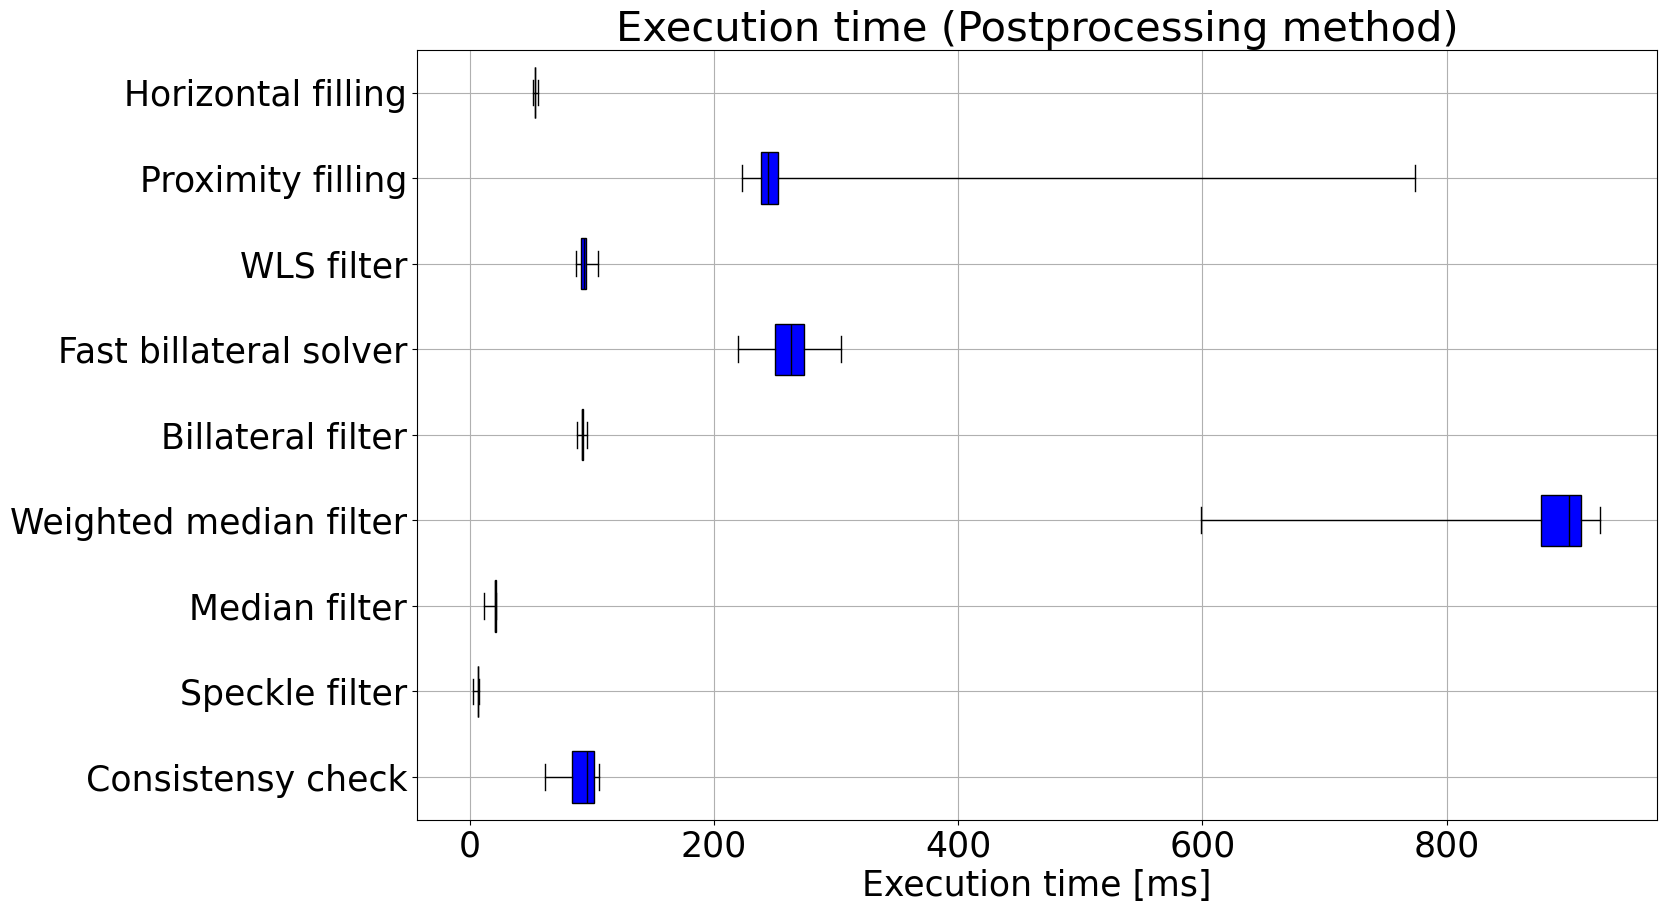

In [131]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import statistics
import seaborn as sns
import pandas as pd


# Show boxplots
colors = ['b']
environments = [""]
show_double_grouped_boxplots(environments,settings_single[:10], [single_hole_counts[:10]], colors, '', 'Holes detected','Noise-based holes detected (Postprocessing method)',True,"../Data/Graphs/Disparity/Postprocessing/post_holes_detected.png")
show_double_grouped_boxplots(environments,settings_single[:10], [single_invalid_percentages[:10]], colors, '', 'Percentage invalid pixels','Percentage invalid pixels (Postprocessing method)',True,"../Data/Graphs/Disparity/Postprocessing/post_invalid_percentage.png")
#show_double_grouped_boxplots(environments,settings_single[:10], [single_incomplete_count[:10]], colors, '', 'Incomplete map distribution','Incomplete map distribution (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/post_speckle_percentage.png")
#show_double_grouped_boxplots(environments,settings_single[:10], [single_consistensy_level[:10]], colors, '', 'Consistensy level','Consistensy (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/post_incomplete.png")
show_double_grouped_boxplots(environments,settings_single[1:10], [single_execution_time[1:10]], colors, '', 'Execution time [ms]','Execution time (Postprocessing method)',True,"../Data/Graphs/Disparity/Postprocessing/post_execution_time.png")


Weighted median filter is way too slow for pseudo "real-time" implementations.
Consistensy checks are also quite slow.
Both consistensy checks and speckle filtering is included in SGBM and is in this case added as another external version.
Weighted median filter gave the best looking results but at the cost of sometimes removing speckles that are actually apart of the structure.
Weighted median filter also results in the lowest amount of invalid pixels as well as holes, which suport the visual inspection of it looking the best.




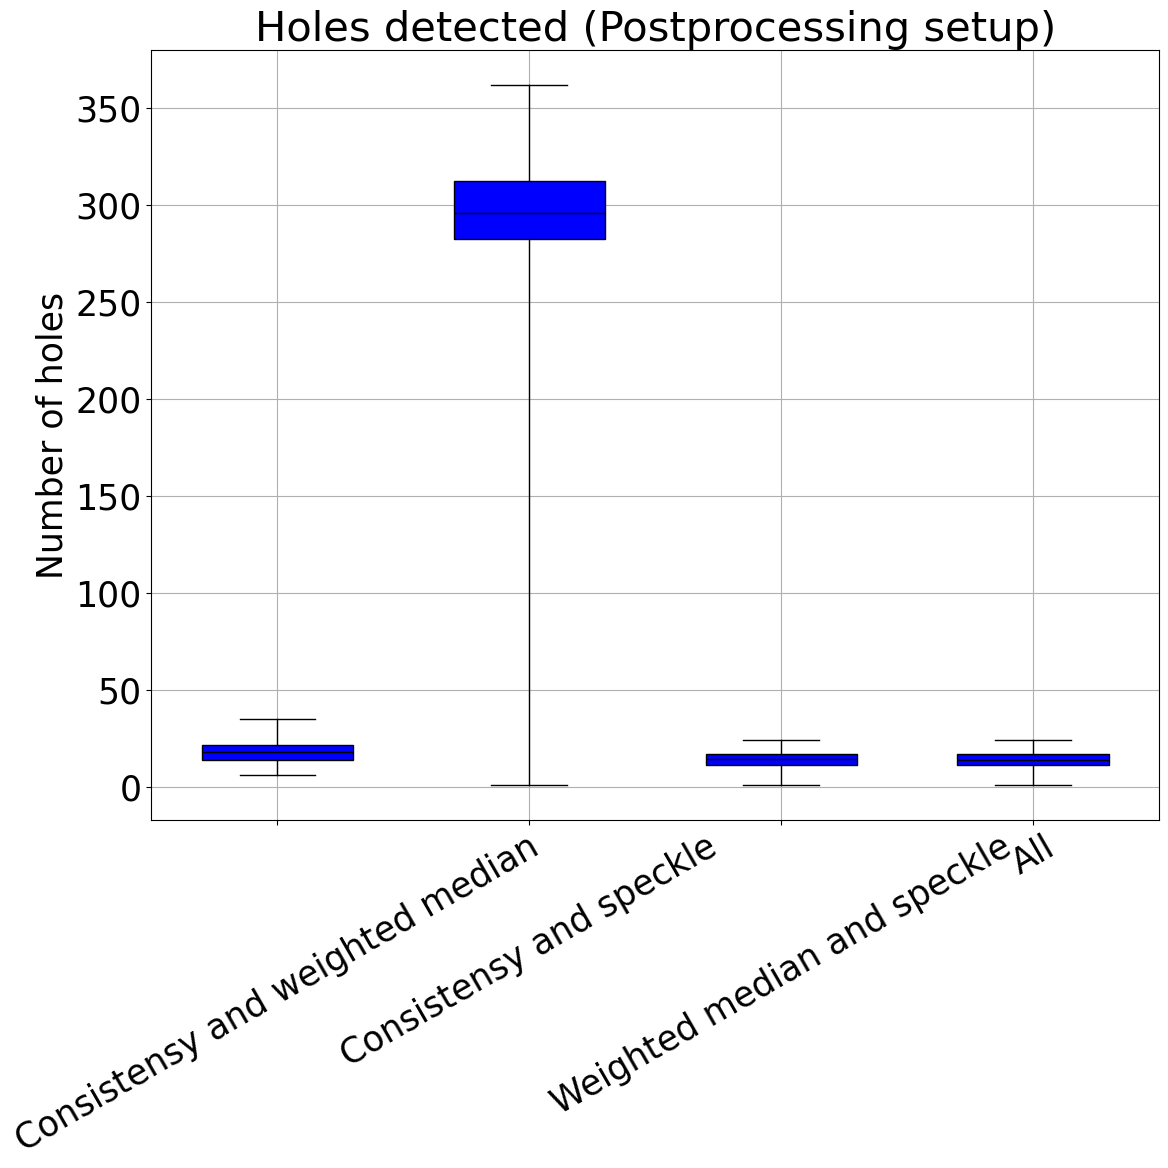

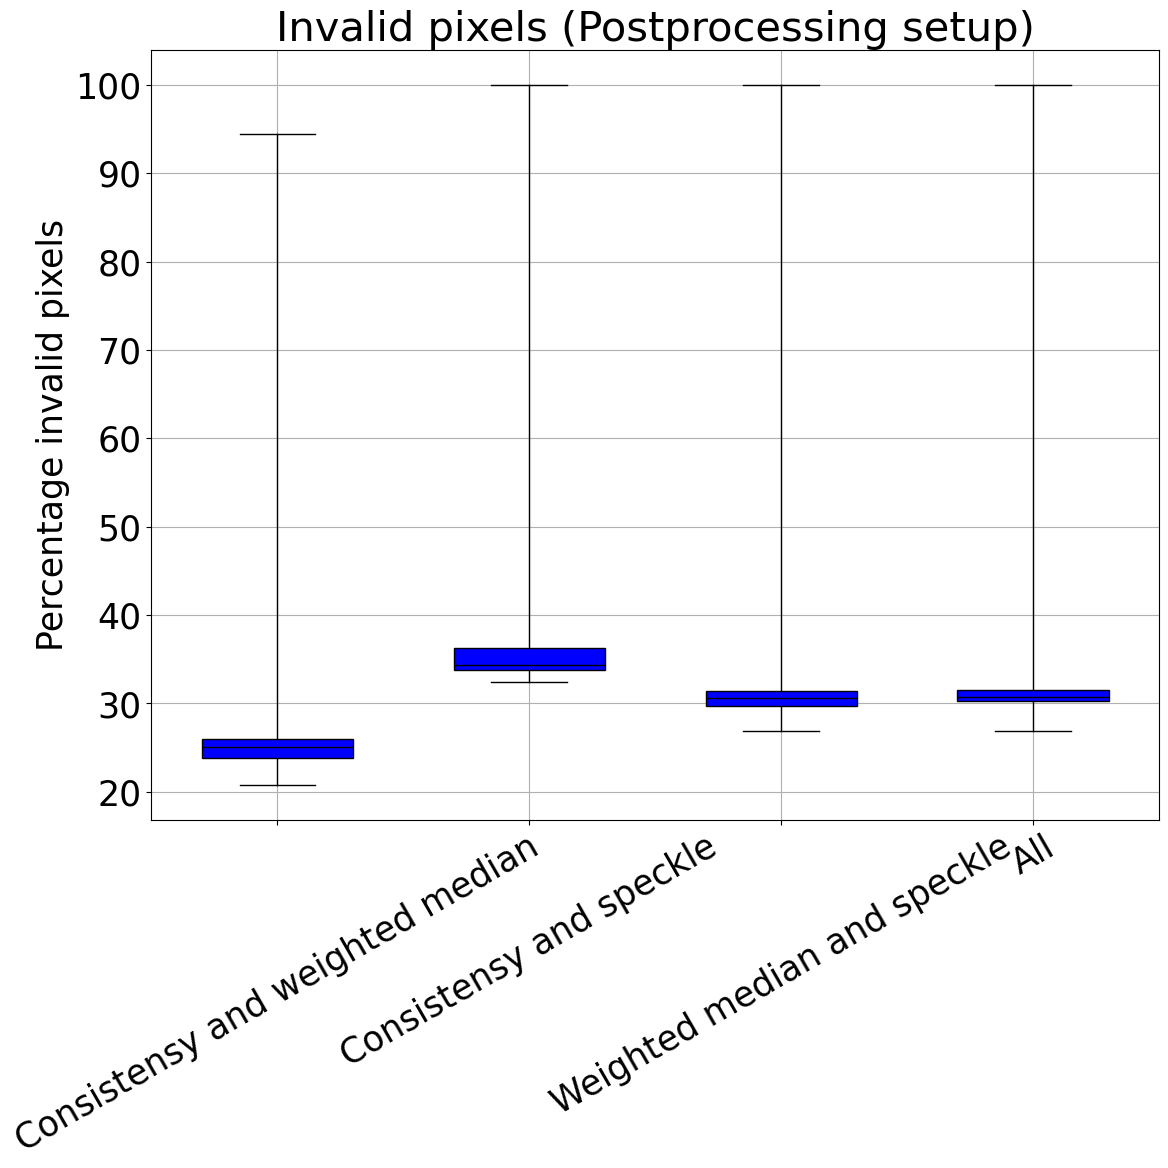

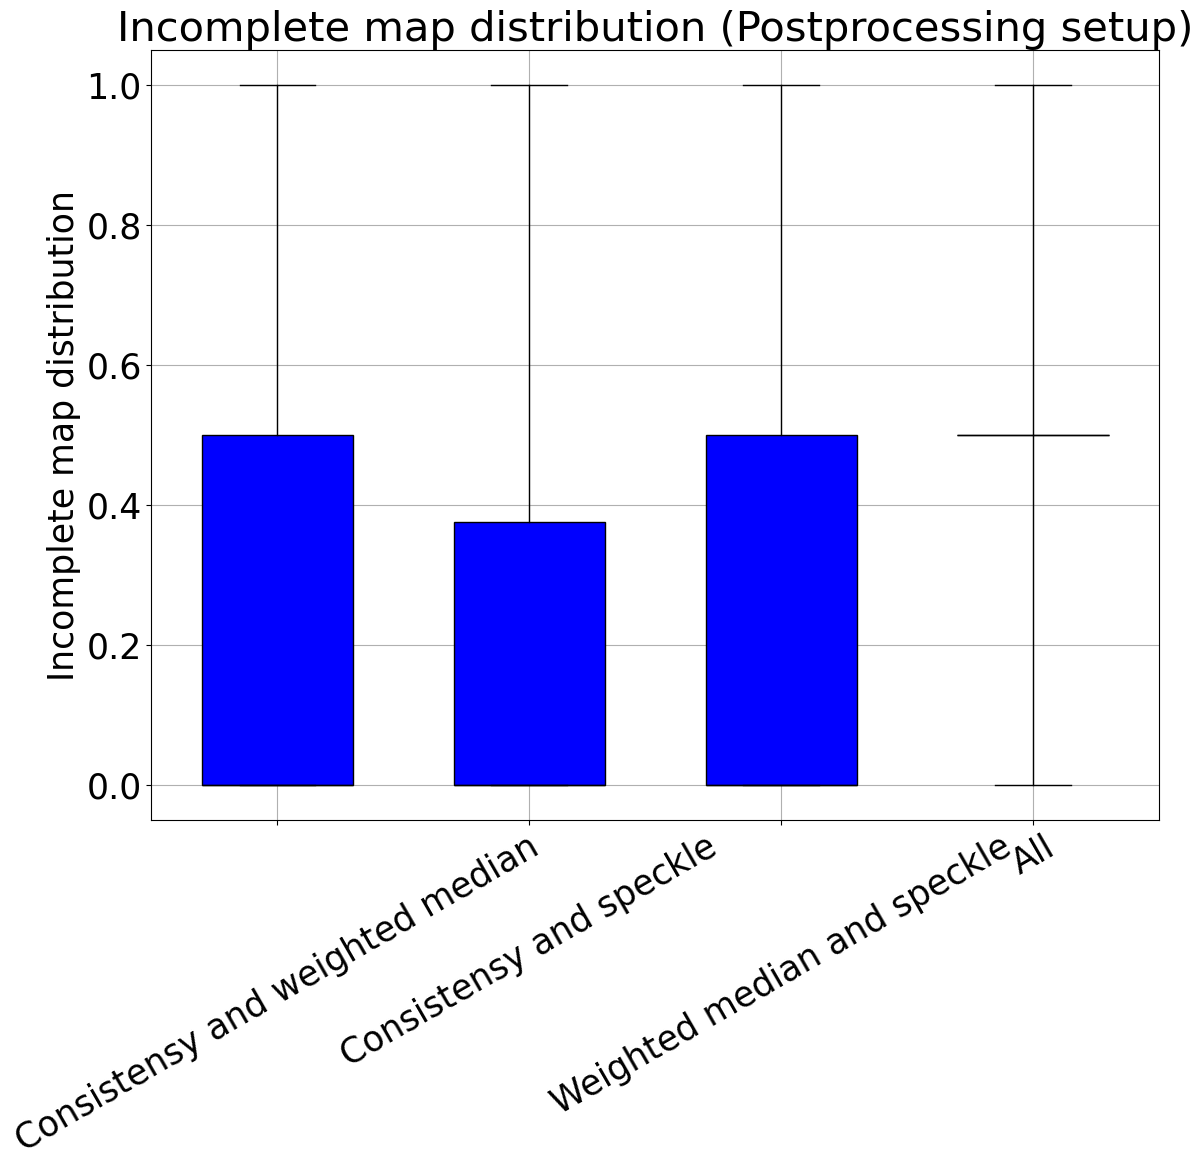

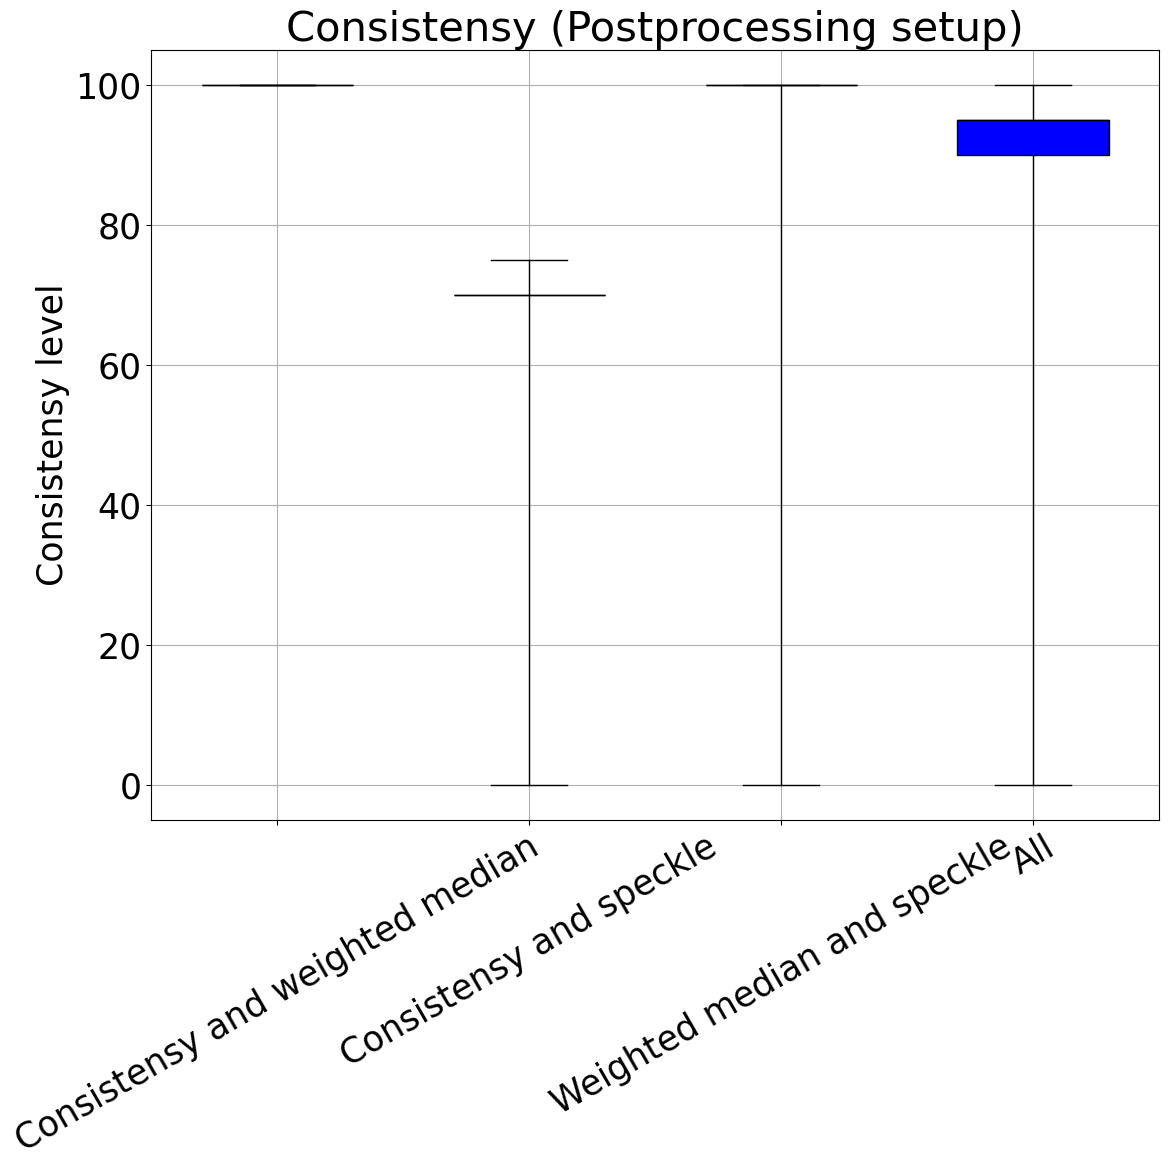

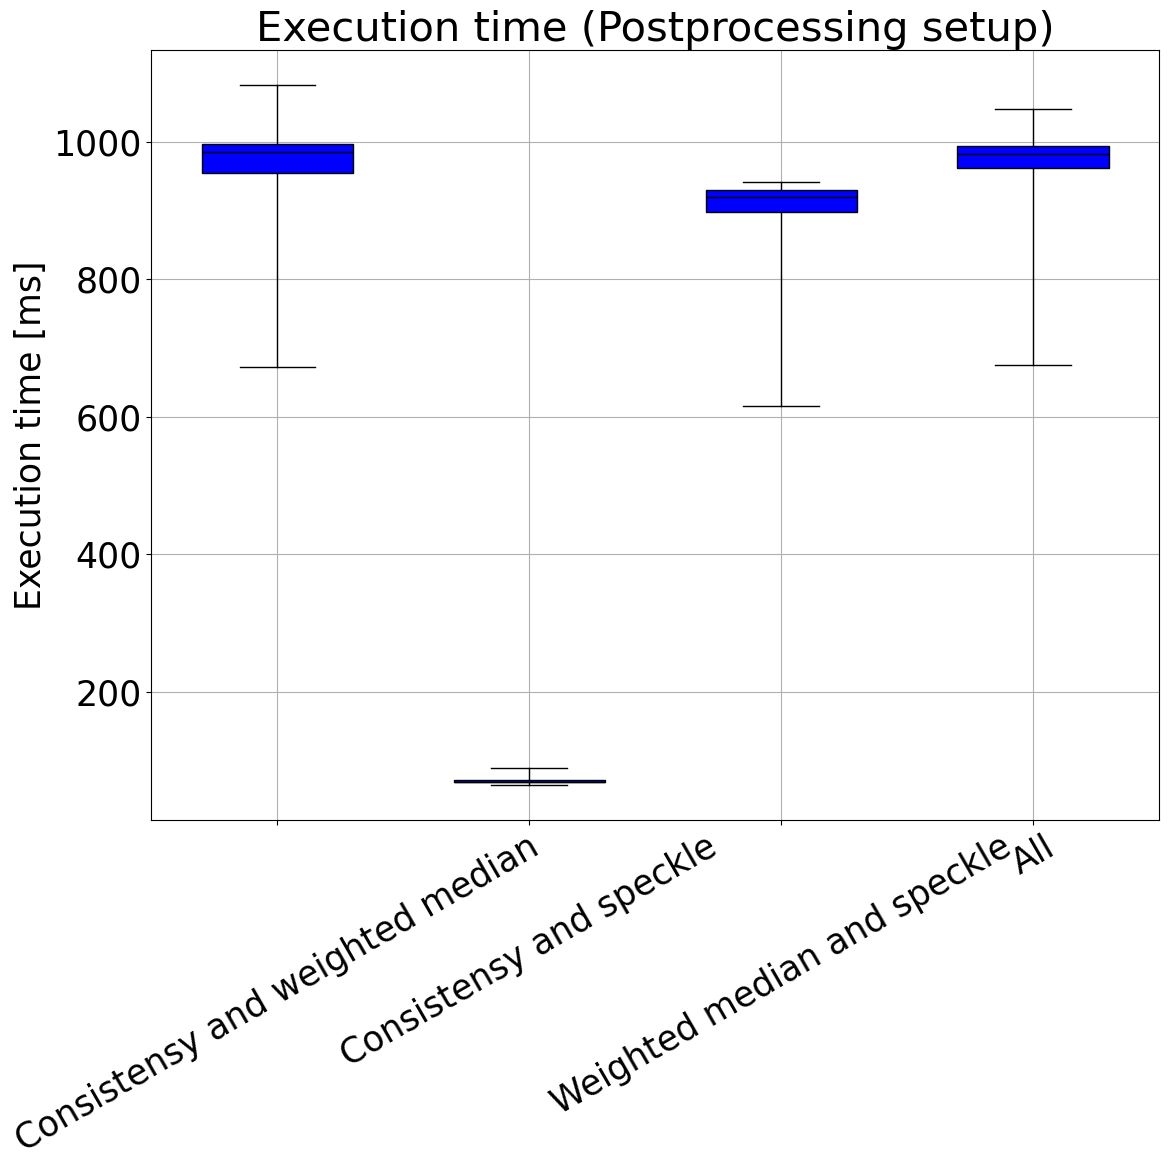

In [121]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import statistics
import seaborn as sns
import pandas as pd


# Show boxplots
colors = ['b']
environments = [""]
show_double_grouped_boxplots(environments,settings_combined, [combined_hole_counts], colors, '', 'Number of holes','Holes detected (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/comb_post_holes_detected.png")
show_double_grouped_boxplots(environments,settings_combined, [combined_invalid_percentages], colors, '', 'Percentage invalid pixels','Invalid pixels (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/comb_post_invalid_percentage.png")
show_double_grouped_boxplots(environments,settings_combined, [combined_incomplete_count], colors, '', 'Incomplete map distribution','Incomplete map distribution (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/comb_post_speckle_percentage.png")
show_double_grouped_boxplots(environments,settings_combined, [combined_consistensy_level], colors, '', 'Consistensy level','Consistensy (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/comb_post_incomplete.png")
show_double_grouped_boxplots(environments,settings_combined, [combined_execution_time], colors, '', 'Execution time [ms]','Execution time (Postprocessing setup)',True,"../Data/Graphs/Disparity/Postprocessing/comb_post_execution_time.png")


Every version that includes weighted median filter are way too slow.
Speckle filter should thus currently be the only post processing method due to speed limitations.
The issue is that a filling algorithm is still desired due to the inconsistensy (holes) of the completed map.